In [1]:
import pandas as pd
import numpy as np

import math
import os

# # Make TensorFlow logs less verbose
# os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import tensorflow as tf

import flwr as fl
import tensorflow_probability as tfp

import keras
from sklearn.model_selection import train_test_split
from utils import model as mod
from flwr.common import NDArrays, Scalar
from scipy.stats import pearsonr
from typing import Dict, Optional, Tuple, List, Union
import typing
import random
import json
np.random.seed(2048)
tf.random.set_seed(2048)
random.seed(2048)
tf.keras.utils.set_random_seed(2048)



NUM_EPOCHS=10
BATCH_SIZE=16
path='resultsbn'
strat='FedAvg'

2023-09-27 15:18:58.979429: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-27 15:18:59.167952: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-27 15:18:59.868999: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-27 15:18:59.870126: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-27 15:19:04.423277: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
!pwd

/rds/user/sc2427/hpc-work/Final/FL


In [3]:
data=pd.read_csv("all_data.csv")

In [4]:
df = pd.DataFrame(columns = data.columns)


In [5]:

dfs_to_concat = []

for i in range(250, 1000):
    mean_data = data.loc[data['Stamp'] == i].mean()
    dfs_to_concat.append(mean_data)

result_df = pd.concat(dfs_to_concat, axis=1).T.reset_index(drop=True)

In [6]:
data_new=result_df

In [7]:
data_new.shape

(750, 38)

In [8]:
y_labels=df.columns[-8:]

In [9]:
x_labels=df.columns[1:-8]

In [10]:
x=np.array(data_new[x_labels])

In [11]:
y=np.array(data_new[y_labels])

In [12]:
x_train,x_test,y_train,y_test=train_test_split(x,y,random_state=1)

In [13]:
x_train.shape

(562, 29)

In [14]:
# y_train=y_train.reshape((1,y_train.shape[0],y_train.shape[1]))
y_train.shape

(562, 8)

In [15]:

model_eval = mod()
model_eval.compile(keras.optimizers.Adam(0.01), loss=tf.keras.metrics.mean_squared_error, metrics=[tf.keras.metrics.RootMeanSquaredError() ])

2023-09-27 15:19:18.549415: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [20]:
def pcc(y_val, y_pred):
  temp={}
  for i in range(len(y_labels)):
    temp[y_labels[i]]=(pearsonr(y_val[:,i],y_pred[:,i])[0])
  return sum(list(temp.values()))/len(list(temp.values()))

In [21]:
class FlowerClient(fl.client.NumPyClient):

    def __init__(self, model,cid, x_train, y_train, x_val, y_val, path) -> None:
        self.model = model
        self.cid=cid
        self.x_train, self.y_train = x_train, y_train
        self.x_val, self.y_val = x_val, y_val
        self.path=path

    def get_parameters(self, config):
        return self.model.get_weights()

    def fit(self, parameters, config):
        self.model.set_weights(parameters)
        self.model.fit(self.x_train, self.y_train, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE)
        return self.model.get_weights(), len(self.x_train), {}

    def evaluate(self, parameters, config):
        self.model.set_weights(parameters)
        # loss, acc = self.model.evaluate(self.x_val, self.y_val, verbose=2)
        # loss, rmse = model.evaluate(self.x_val, self.y_val)
        loss,rmse=self.model.evaluate(self.x_val, self.y_val)

        # result["pr"].append(pr)


        try:
          data=pd.read_csv(f"{self.path}/result_{self.cid}.csv")
          data.drop(["Unnamed: 0"], axis=1, inplace=True)

        except:
          data=pd.DataFrame(columns=["round","Loss", "RMSE"])

        data=pd.concat([data,pd.Series([config['server_round'], loss, rmse ] , index=data.columns ).to_frame().T])
        data.to_csv(f"{self.path}/result_{self.cid}.csv")

        return loss, len(self.x_val), {"accuracy": rmse}


In [22]:

#import pearsonr
def get_eval_fn(model, result,result_train):
    """Return an evaluation function for server-side evaluation."""

    # Load data and model here to avoid the overhead of doing it in `evaluate` itself


    # The `evaluate` function will be called after every round
    def evaluate(server_round: int, weights: fl.common.NDArrays, config: Dict[str, Scalar]) -> Optional[Tuple[float, Dict[str, Scalar]]]:
        model.set_weights(weights)  # Update model with the latest parameters
        loss, rmse = model.evaluate(x_test, y_test)
        loss_train,rmse_train=model.evaluate(x_train, y_train)
        result_train['Losses'].append(loss_train)
        result_train['rmse'].append(rmse_train)

        result["Losses"].append(loss)
        result["rmse"].append(rmse)
        # result["pr"].append(pr)
        for i in range(len(y_labels)):
          result["pearson"][y_labels[i]].append(pearsonr(y_test[:,i],model.predict(x_test)[:,i])[0])
          result_train['pearson'][y_labels[i]].append(pearsonr(y_train[:,i],model.predict(x_train)[:,i])[0])


        return loss, {"accuracy": rmse}

    return evaluate

In [23]:
model_eval.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                480       
                                                                 
 batch_normalization (Batch  (None, 16)                64        
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 16)                272       
                                                                 
 batch_normalization_1 (Bat  (None, 16)                64        
 chNormalization)                                                
                                                                 
 dense_2 (Dense)             (None, 8)                 136       
                                                                 
Total params: 1016 (3.97 KB)
Trainable params: 952 (3.72

In [24]:
def fit_config(server_round: int):
    """Return training configuration dict for each round.

    Perform two rounds of training with one local epoch, increase to two local
    epochs afterwards.
    """
    config = {
        "server_round": server_round,  # The current round of federated learning
    }
    return config

def evaluate_config(server_round: int):
    """Return training configuration dict for each round.

    Perform two rounds of training with one local epoch, increase to two local
    epochs afterwards.
    """
    config = {
        "server_round": server_round,  # The current round of federated learning
    }
    return config

In [25]:

ray_init_args = {
            "num_gpus": 0,
            "num_cpus": 5
        }
client_res={"num_gpus": 0, "num_cpus": 5}

In [26]:
inital=mod()
#for clients from 2 to 10, run the strategy for 10 rounds each and create a list of results
results=[]
results_train=[]
# for i in range(5):
for i in range(2,11):
    try:
        os.mkdir(f"{path}/{i}")
    except:
        print()
    try:
        os.mkdir(f"{path}/{i}/{strat}")
    except:
        print()
    
    NUM_CLIENTS = i
    # losses=[]
    def client_fn(cid: str) -> fl.client.Client:
        # Create model
        model = mod()
        model.compile(keras.optimizers.Adam(0.01), loss=tf.keras.metrics.mean_squared_error, metrics=[tf.keras.metrics.RootMeanSquaredError()])    
        partition_size = math.floor(len(x_train) / NUM_CLIENTS)
        idx_from, idx_to = int(cid) * partition_size, (int(cid) + 1) * partition_size
        full_x_train_cid = x_train[idx_from:idx_to]
        full_y_train_cid = y_train[idx_from:idx_to]
    
    
        partition_size = math.floor(len(x_test) / NUM_CLIENTS)
        idx_from, idx_to = int(cid) * partition_size, (int(cid) + 1) * partition_size
        full_x_test_cid = x_test[idx_from:idx_to]
        full_y_test_cid = y_test[idx_from:idx_to]
    
        # Create and return client
        return FlowerClient(model,cid, full_x_train_cid, full_y_train_cid, full_x_test_cid, full_y_test_cid, f"{path}/{i}/{strat}")


    
    
    result={ 'clients':i  , 'Losses':[], "rmse":[], 'pearson':{y_labels[i]:[] for i in range(len(y_labels))}}
    
    result_train={ 'clients':i  , 'Losses':[], "rmse":[], 'pearson':{y_labels[i]:[] for i in range(len(y_labels))}}
    
    try:
        del strategy
    except:
        print('starting')
    # Create FedAvg strategy
    strategy = fl.server.strategy.FedAvg(
      min_fit_clients=i,  # Never sample less than 10 clients for training
      evaluate_fn=get_eval_fn(model_eval, result,result_train),
      on_fit_config_fn=fit_config,
      on_evaluate_config_fn=evaluate_config,
      initial_parameters=fl.common.ndarrays_to_parameters(inital.get_weights()),
    )
    
    # Start simulation
    fl.simulation.start_simulation(
      client_fn=client_fn,
      num_clients=NUM_CLIENTS,
      config=fl.server.ServerConfig(num_rounds=10),
      strategy=strategy,
      ray_init_args=ray_init_args,
      client_resources=client_res,
    )
    results.append(result)
    results_train.append(result_train)
    # print(result)
    # try:
    #     data=pd.read_csv(f"{path}/combine_random{result['clients']}.csv")
    #     data.drop(["Unnamed: 0"], axis=1, inplace=True)
        
    # except:
    #     data=pd.DataFrame(columns=["Method", "Loss_Task1", "RMSE_Task1"])
    # data=pd.concat([data,pd.Series(["FedAvgEWC_Aug", result['Losses'][-1],result['rmse'][-1]] , index=data.columns ).to_frame().T])
    # data.to_csv(f"{path}/combine_random{result['clients']}.csv")



INFO flwr 2023-09-27 15:19:54,037 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)


starting


2023-09-27 15:19:59,112	ERROR resource_spec.py:199 -- Could not parse gpu information.
Traceback (most recent call last):
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/ray/_private/resource_spec.py", line 193, in resolve
    gpu_types = _get_gpu_types_gputil()
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/ray/_private/resource_spec.py", line 304, in _get_gpu_types_gputil
    gpu_list = GPUtil.getGPUs()
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/GPUtil/GPUtil.py", line 102, in getGPUs
    deviceIds = int(vals[i])
ValueError: invalid literal for int() with base 10: "NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running."
2023-09-27 15:19:59,304	INFO worker.py:1612 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
INFO flwr 2023-09-27 15:20:00,694 | app.py:180 | Flower VCE: Ray initialized with resources: {'node:128.232.224.43': 1.0,

18/18 [==============================] - 0s 933us/step


INFO flwr 2023-09-27 15:20:03,036 | server.py:91 | initial parameters (loss, other metrics): 11.060606956481934, {'accuracy': 3.325749158859253}
INFO flwr 2023-09-27 15:20:03,037 | server.py:101 | FL starting
DEBUG flwr 2023-09-27 15:20:03,037 | server.py:218 | fit_round 1: strategy sampled 2 clients (out of 2)
(pid=188307) 2023-09-27 15:20:03.964904: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
(pid=188307) 2023-09-27 15:20:03.966951: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
(pid=188307) 2023-09-27 15:20:04.017001: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
(pid=188307) 2023-09-27 15:20:04.017466: I tensorflow/core/platform/cpu_feature_gu

(launch_and_fit pid=188307) Epoch 1/10
18/18 [==============================] - 1s 3ms/step - loss: 8.5122 - root_mean_squared_error: 2.9176
(launch_and_fit pid=188307) Epoch 2/10
18/18 [==============================] - 0s 2ms/step - loss: 3.7217 - root_mean_squared_error: 1.9292
(launch_and_fit pid=188307) Epoch 3/10
18/18 [==============================] - 0s 2ms/step - loss: 0.4316 - root_mean_squared_error: 0.6569
(launch_and_fit pid=188307) Epoch 4/10
18/18 [==============================] - 0s 3ms/step - loss: 0.3205 - root_mean_squared_error: 0.5661
(launch_and_fit pid=188307) Epoch 5/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2493 - root_mean_squared_error: 0.4993
(launch_and_fit pid=188307) Epoch 6/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2449 - root_mean_squared_error: 0.4949
(launch_and_fit pid=188307) Epoch 7/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2489 - root_mean_squared_error: 0.4989
(launch_and_f

DEBUG flwr 2023-09-27 15:20:14,446 | server.py:232 | fit_round 1 received 2 results and 0 failures
WARNING flwr 2023-09-27 15:20:14,463 | fedavg.py:243 | No fit_metrics_aggregation_fn provided


18/18 [==============================] - 0s 2ms/step - loss: 0.3158 - root_mean_squared_error: 0.5619
(launch_and_fit pid=188307) Epoch 5/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2538 - root_mean_squared_error: 0.5037
(launch_and_fit pid=188307) Epoch 6/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2480 - root_mean_squared_error: 0.4980
(launch_and_fit pid=188307) Epoch 7/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2301 - root_mean_squared_error: 0.4797
(launch_and_fit pid=188307) Epoch 8/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2357 - root_mean_squared_error: 0.4855
(launch_and_fit pid=188307) Epoch 9/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2351 - root_mean_squared_error: 0.4848
(launch_and_fit pid=188307) Epoch 10/10
18/18 [==============================] - 0s 860us/step


INFO flwr 2023-09-27 15:20:15,836 | server.py:119 | fit progress: (1, 0.2396831065416336, {'accuracy': 0.4895744025707245}, 12.79893043031916)
DEBUG flwr 2023-09-27 15:20:15,837 | server.py:168 | evaluate_round 1: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-09-27 15:20:16,404 | server.py:182 | evaluate_round 1 received 2 results and 0 failures
WARNING flwr 2023-09-27 15:20:16,405 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-09-27 15:20:16,407 | server.py:218 | fit_round 2: strategy sampled 2 clients (out of 2)


3/3 [==============================] - 0s 2ms/step - loss: 0.2478 - root_mean_squared_error: 0.4978
(launch_and_fit pid=188307) Epoch 1/10
18/18 [==============================] - 1s 3ms/step - loss: 0.2497 - root_mean_squared_error: 0.4997
(launch_and_fit pid=188307) Epoch 2/10
18/18 [==============================] - 0s 3ms/step - loss: 0.2499 - root_mean_squared_error: 0.4999
(launch_and_fit pid=188307) Epoch 3/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2408 - root_mean_squared_error: 0.4907
(launch_and_fit pid=188307) Epoch 4/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2522 - root_mean_squared_error: 0.5022
(launch_and_fit pid=188307) Epoch 5/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2261 - root_mean_squared_error: 0.4755
(launch_and_fit pid=188307) Epoch 6/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2388 - root_mean_squared_error: 0.4887
(launch_and_fit pid=188307) Epoch 7/10
18/18 [========

DEBUG flwr 2023-09-27 15:20:19,516 | server.py:232 | fit_round 2 received 2 results and 0 failures


18/18 [==============================] - 0s 2ms/step - loss: 0.2416 - root_mean_squared_error: 0.4915
(launch_and_fit pid=188307) Epoch 5/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2515 - root_mean_squared_error: 0.5015
(launch_and_fit pid=188307) Epoch 6/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2316 - root_mean_squared_error: 0.4813
(launch_and_fit pid=188307) Epoch 7/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2213 - root_mean_squared_error: 0.4704
(launch_and_fit pid=188307) Epoch 8/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2517 - root_mean_squared_error: 0.5017
(launch_and_fit pid=188307) Epoch 9/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2426 - root_mean_squared_error: 0.4926
(launch_and_fit pid=188307) Epoch 10/10
18/18 [==============================] - 0s 1ms/step


INFO flwr 2023-09-27 15:20:21,057 | server.py:119 | fit progress: (2, 0.2562510371208191, {'accuracy': 0.5062124133110046}, 18.019449924118817)
DEBUG flwr 2023-09-27 15:20:21,058 | server.py:168 | evaluate_round 2: strategy sampled 2 clients (out of 2)


3/3 [==============================] - 0s 3ms/step - loss: 0.2531 - root_mean_squared_error: 0.5031


DEBUG flwr 2023-09-27 15:20:21,641 | server.py:182 | evaluate_round 2 received 2 results and 0 failures
DEBUG flwr 2023-09-27 15:20:21,642 | server.py:218 | fit_round 3: strategy sampled 2 clients (out of 2)


3/3 [==============================] - 0s 2ms/step - loss: 0.2594 - root_mean_squared_error: 0.5093
(launch_and_fit pid=188307) Epoch 1/10
18/18 [==============================] - 1s 2ms/step - loss: 0.2386 - root_mean_squared_error: 0.4885
(launch_and_fit pid=188307) Epoch 2/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2178 - root_mean_squared_error: 0.4667
(launch_and_fit pid=188307) Epoch 3/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2298 - root_mean_squared_error: 0.4794
(launch_and_fit pid=188307) Epoch 4/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2080 - root_mean_squared_error: 0.4560
(launch_and_fit pid=188307) Epoch 5/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2226 - root_mean_squared_error: 0.4718
(launch_and_fit pid=188307) Epoch 6/10
18/18 [==============================] - 0s 1ms/step - loss: 0.2287 - root_mean_squared_error: 0.4782
(launch_and_fit pid=188307) Epoch 7/10
18/18 [========

DEBUG flwr 2023-09-27 15:20:24,474 | server.py:232 | fit_round 3 received 2 results and 0 failures


18/18 [==============================] - 0s 2ms/step - loss: 0.2332 - root_mean_squared_error: 0.4829
(launch_and_fit pid=188307) Epoch 5/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2461 - root_mean_squared_error: 0.4961
(launch_and_fit pid=188307) Epoch 6/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2322 - root_mean_squared_error: 0.4819
(launch_and_fit pid=188307) Epoch 7/10
18/18 [==============================] - 0s 1ms/step - loss: 0.2215 - root_mean_squared_error: 0.4707
(launch_and_fit pid=188307) Epoch 8/10
18/18 [==============================] - 0s 1ms/step - loss: 0.2234 - root_mean_squared_error: 0.4727
(launch_and_fit pid=188307) Epoch 9/10
18/18 [==============================] - 0s 1ms/step - loss: 0.2136 - root_mean_squared_error: 0.4622
(launch_and_fit pid=188307) Epoch 10/10
18/18 [==============================] - 0s 2ms/step


INFO flwr 2023-09-27 15:20:26,016 | server.py:119 | fit progress: (3, 0.2578878700733185, {'accuracy': 0.5078266263008118}, 22.978679738007486)
DEBUG flwr 2023-09-27 15:20:26,017 | server.py:168 | evaluate_round 3: strategy sampled 2 clients (out of 2)
(launch_and_evaluate pid=188307) WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.test_function at 0x2bae2bf99af0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


3/3 [==============================] - 0s 2ms/step - loss: 0.2445 - root_mean_squared_error: 0.4945


DEBUG flwr 2023-09-27 15:20:26,657 | server.py:182 | evaluate_round 3 received 2 results and 0 failures
DEBUG flwr 2023-09-27 15:20:26,658 | server.py:218 | fit_round 4: strategy sampled 2 clients (out of 2)
(launch_and_evaluate pid=188307) WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.test_function at 0x2bafcb4ce670> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


3/3 [==============================] - 0s 2ms/step - loss: 0.2712 - root_mean_squared_error: 0.5208
(launch_and_fit pid=188307) Epoch 1/10
18/18 [==============================] - 1s 2ms/step - loss: 0.2615 - root_mean_squared_error: 0.5113
(launch_and_fit pid=188307) Epoch 2/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2474 - root_mean_squared_error: 0.4974
(launch_and_fit pid=188307) Epoch 3/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2235 - root_mean_squared_error: 0.4728
(launch_and_fit pid=188307) Epoch 4/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2182 - root_mean_squared_error: 0.4671
(launch_and_fit pid=188307) Epoch 5/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2161 - root_mean_squared_error: 0.4648
(launch_and_fit pid=188307) Epoch 6/10
18/18 [==============================] - 0s 1ms/step - loss: 0.2222 - root_mean_squared_error: 0.4714
(launch_and_fit pid=188307) Epoch 7/10
18/18 [========

DEBUG flwr 2023-09-27 15:20:29,434 | server.py:232 | fit_round 4 received 2 results and 0 failures


18/18 [==============================] - 0s 2ms/step - loss: 0.2203 - root_mean_squared_error: 0.4693
(launch_and_fit pid=188307) Epoch 8/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2235 - root_mean_squared_error: 0.4728
(launch_and_fit pid=188307) Epoch 9/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2235 - root_mean_squared_error: 0.4727
(launch_and_fit pid=188307) Epoch 10/10
18/18 [==============================] - 0s 1ms/step


INFO flwr 2023-09-27 15:20:30,988 | server.py:119 | fit progress: (4, 0.22356568276882172, {'accuracy': 0.47282731533050537}, 27.950290982145816)
DEBUG flwr 2023-09-27 15:20:30,989 | server.py:168 | evaluate_round 4: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-09-27 15:20:31,553 | server.py:182 | evaluate_round 4 received 2 results and 0 failures
DEBUG flwr 2023-09-27 15:20:31,555 | server.py:218 | fit_round 5: strategy sampled 2 clients (out of 2)


3/3 [==============================] - 0s 2ms/step - loss: 0.2194 - root_mean_squared_error: 0.4684
(launch_and_fit pid=188307) Epoch 1/10
18/18 [==============================] - 1s 2ms/step - loss: 0.2426 - root_mean_squared_error: 0.4926
(launch_and_fit pid=188307) Epoch 2/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2363 - root_mean_squared_error: 0.4861
(launch_and_fit pid=188307) Epoch 3/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2289 - root_mean_squared_error: 0.4785
(launch_and_fit pid=188307) Epoch 4/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2218 - root_mean_squared_error: 0.4710
(launch_and_fit pid=188307) Epoch 5/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2210 - root_mean_squared_error: 0.4701
(launch_and_fit pid=188307) Epoch 6/10
18/18 [==============================] - 0s 1ms/step - loss: 0.2276 - root_mean_squared_error: 0.4771
(launch_and_fit pid=188307) Epoch 7/10
18/18 [========

DEBUG flwr 2023-09-27 15:20:34,345 | server.py:232 | fit_round 5 received 2 results and 0 failures


18/18 [==============================] - 0s 3ms/step - loss: 0.2125 - root_mean_squared_error: 0.4610
(launch_and_fit pid=188307) Epoch 7/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2214 - root_mean_squared_error: 0.4705
(launch_and_fit pid=188307) Epoch 8/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2289 - root_mean_squared_error: 0.4785
(launch_and_fit pid=188307) Epoch 9/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2207 - root_mean_squared_error: 0.4698
(launch_and_fit pid=188307) Epoch 10/10
18/18 [==============================] - 0s 1ms/step


INFO flwr 2023-09-27 15:20:35,912 | server.py:119 | fit progress: (5, 0.22035957872867584, {'accuracy': 0.4694247245788574}, 32.87502798112109)
DEBUG flwr 2023-09-27 15:20:35,913 | server.py:168 | evaluate_round 5: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-09-27 15:20:36,484 | server.py:182 | evaluate_round 5 received 2 results and 0 failures
DEBUG flwr 2023-09-27 15:20:36,485 | server.py:218 | fit_round 6: strategy sampled 2 clients (out of 2)


3/3 [==============================] - 0s 2ms/step - loss: 0.2185 - root_mean_squared_error: 0.4674
(launch_and_fit pid=188307) Epoch 1/10
18/18 [==============================] - 1s 2ms/step - loss: 0.2437 - root_mean_squared_error: 0.4937
(launch_and_fit pid=188307) Epoch 2/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2248 - root_mean_squared_error: 0.4741
(launch_and_fit pid=188307) Epoch 3/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2327 - root_mean_squared_error: 0.4824
(launch_and_fit pid=188307) Epoch 4/10
18/18 [==============================] - 0s 3ms/step - loss: 0.2230 - root_mean_squared_error: 0.4723
(launch_and_fit pid=188307) Epoch 5/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2197 - root_mean_squared_error: 0.4687
(launch_and_fit pid=188307) Epoch 6/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2316 - root_mean_squared_error: 0.4812
(launch_and_fit pid=188307) Epoch 7/10
18/18 [========

DEBUG flwr 2023-09-27 15:20:39,663 | server.py:232 | fit_round 6 received 2 results and 0 failures


18/18 [==============================] - 0s 2ms/step - loss: 0.2000 - root_mean_squared_error: 0.4473
(launch_and_fit pid=188307) Epoch 6/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2184 - root_mean_squared_error: 0.4673
(launch_and_fit pid=188307) Epoch 7/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2103 - root_mean_squared_error: 0.4586
(launch_and_fit pid=188307) Epoch 8/10
18/18 [==============================] - 0s 1ms/step - loss: 0.2214 - root_mean_squared_error: 0.4705
(launch_and_fit pid=188307) Epoch 9/10
18/18 [==============================] - 0s 1ms/step - loss: 0.2058 - root_mean_squared_error: 0.4536
(launch_and_fit pid=188307) Epoch 10/10
18/18 [==============================] - 0s 1ms/step


INFO flwr 2023-09-27 15:20:41,464 | server.py:119 | fit progress: (6, 0.2256726622581482, {'accuracy': 0.475050151348114}, 38.426773538347334)
DEBUG flwr 2023-09-27 15:20:41,465 | server.py:168 | evaluate_round 6: strategy sampled 2 clients (out of 2)


3/3 [==============================] - 0s 2ms/step - loss: 0.2264 - root_mean_squared_error: 0.4758


DEBUG flwr 2023-09-27 15:20:42,032 | server.py:182 | evaluate_round 6 received 2 results and 0 failures
DEBUG flwr 2023-09-27 15:20:42,033 | server.py:218 | fit_round 7: strategy sampled 2 clients (out of 2)


3/3 [==============================] - 0s 2ms/step - loss: 0.2250 - root_mean_squared_error: 0.4743
(launch_and_fit pid=188307) Epoch 1/10
18/18 [==============================] - 1s 2ms/step - loss: 0.2246 - root_mean_squared_error: 0.4739
(launch_and_fit pid=188307) Epoch 2/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2223 - root_mean_squared_error: 0.4715
(launch_and_fit pid=188307) Epoch 3/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2369 - root_mean_squared_error: 0.4867
(launch_and_fit pid=188307) Epoch 4/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2244 - root_mean_squared_error: 0.4737
(launch_and_fit pid=188307) Epoch 5/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2258 - root_mean_squared_error: 0.4752
(launch_and_fit pid=188307) Epoch 6/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2193 - root_mean_squared_error: 0.4683
(launch_and_fit pid=188307) Epoch 7/10
18/18 [========

DEBUG flwr 2023-09-27 15:20:44,977 | server.py:232 | fit_round 7 received 2 results and 0 failures


18/18 [==============================] - 0s 2ms/step - loss: 0.2379 - root_mean_squared_error: 0.4877
(launch_and_fit pid=188307) Epoch 6/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2339 - root_mean_squared_error: 0.4836
(launch_and_fit pid=188307) Epoch 7/10
18/18 [==============================] - 0s 1ms/step - loss: 0.2044 - root_mean_squared_error: 0.4522
(launch_and_fit pid=188307) Epoch 8/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2109 - root_mean_squared_error: 0.4592
(launch_and_fit pid=188307) Epoch 9/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2100 - root_mean_squared_error: 0.4583
(launch_and_fit pid=188307) Epoch 10/10
18/18 [==============================] - 0s 1ms/step


INFO flwr 2023-09-27 15:20:46,724 | server.py:119 | fit progress: (7, 0.2198140174150467, {'accuracy': 0.4688432812690735}, 43.686629282310605)
DEBUG flwr 2023-09-27 15:20:46,725 | server.py:168 | evaluate_round 7: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-09-27 15:20:47,309 | server.py:182 | evaluate_round 7 received 2 results and 0 failures
DEBUG flwr 2023-09-27 15:20:47,311 | server.py:218 | fit_round 8: strategy sampled 2 clients (out of 2)


3/3 [==============================] - 0s 2ms/step - loss: 0.2165 - root_mean_squared_error: 0.4653
(launch_and_fit pid=188307) Epoch 1/10
18/18 [==============================] - 1s 2ms/step - loss: 0.2341 - root_mean_squared_error: 0.4838
(launch_and_fit pid=188307) Epoch 2/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2137 - root_mean_squared_error: 0.4623
(launch_and_fit pid=188307) Epoch 3/10
18/18 [==============================] - 0s 3ms/step - loss: 0.2267 - root_mean_squared_error: 0.4761
(launch_and_fit pid=188307) Epoch 4/10
18/18 [==============================] - 0s 3ms/step - loss: 0.2335 - root_mean_squared_error: 0.4832
(launch_and_fit pid=188307) Epoch 5/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2136 - root_mean_squared_error: 0.4621
(launch_and_fit pid=188307) Epoch 6/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2111 - root_mean_squared_error: 0.4595
(launch_and_fit pid=188307) Epoch 7/10
18/18 [========

DEBUG flwr 2023-09-27 15:20:50,285 | server.py:232 | fit_round 8 received 2 results and 0 failures


18/18 [==============================] - 0s 2ms/step - loss: 0.2051 - root_mean_squared_error: 0.4529
(launch_and_fit pid=188307) Epoch 6/10
18/18 [==============================] - 0s 3ms/step - loss: 0.2116 - root_mean_squared_error: 0.4600
(launch_and_fit pid=188307) Epoch 7/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2091 - root_mean_squared_error: 0.4573
(launch_and_fit pid=188307) Epoch 8/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2115 - root_mean_squared_error: 0.4599
(launch_and_fit pid=188307) Epoch 9/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2193 - root_mean_squared_error: 0.4682
(launch_and_fit pid=188307) Epoch 10/10
18/18 [==============================] - 0s 2ms/step


INFO flwr 2023-09-27 15:20:51,961 | server.py:119 | fit progress: (8, 0.2297787368297577, {'accuracy': 0.4793524146080017}, 48.92404570616782)
DEBUG flwr 2023-09-27 15:20:51,963 | server.py:168 | evaluate_round 8: strategy sampled 2 clients (out of 2)


3/3 [==============================] - 0s 2ms/step - loss: 0.2288 - root_mean_squared_error: 0.4783


DEBUG flwr 2023-09-27 15:20:52,586 | server.py:182 | evaluate_round 8 received 2 results and 0 failures
DEBUG flwr 2023-09-27 15:20:52,588 | server.py:218 | fit_round 9: strategy sampled 2 clients (out of 2)


3/3 [==============================] - 0s 2ms/step - loss: 0.2308 - root_mean_squared_error: 0.4804
(launch_and_fit pid=188307) Epoch 1/10
18/18 [==============================] - 1s 2ms/step - loss: 0.2533 - root_mean_squared_error: 0.5033
(launch_and_fit pid=188307) Epoch 2/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2454 - root_mean_squared_error: 0.4953
(launch_and_fit pid=188307) Epoch 3/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2265 - root_mean_squared_error: 0.4759
(launch_and_fit pid=188307) Epoch 4/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2202 - root_mean_squared_error: 0.4693
(launch_and_fit pid=188307) Epoch 5/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2184 - root_mean_squared_error: 0.4673
(launch_and_fit pid=188307) Epoch 6/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2112 - root_mean_squared_error: 0.4595
(launch_and_fit pid=188307) Epoch 7/10
18/18 [========

DEBUG flwr 2023-09-27 15:20:55,690 | server.py:232 | fit_round 9 received 2 results and 0 failures


18/18 [==============================] - 0s 1ms/step - loss: 0.2096 - root_mean_squared_error: 0.4579
(launch_and_fit pid=188307) Epoch 8/10
18/18 [==============================] - 0s 1ms/step - loss: 0.2186 - root_mean_squared_error: 0.4676
(launch_and_fit pid=188307) Epoch 9/10
18/18 [==============================] - 0s 1ms/step - loss: 0.2053 - root_mean_squared_error: 0.4531
(launch_and_fit pid=188307) Epoch 10/10
18/18 [==============================] - 0s 961us/step


INFO flwr 2023-09-27 15:20:57,122 | server.py:119 | fit progress: (9, 0.22368194162845612, {'accuracy': 0.4729502499103546}, 54.08465481735766)
DEBUG flwr 2023-09-27 15:20:57,123 | server.py:168 | evaluate_round 9: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-09-27 15:20:57,688 | server.py:182 | evaluate_round 9 received 2 results and 0 failures
DEBUG flwr 2023-09-27 15:20:57,689 | server.py:218 | fit_round 10: strategy sampled 2 clients (out of 2)


3/3 [==============================] - 0s 4ms/step - loss: 0.2282 - root_mean_squared_error: 0.4777
(launch_and_fit pid=188307) Epoch 1/10
18/18 [==============================] - 1s 3ms/step - loss: 0.2433 - root_mean_squared_error: 0.4933
(launch_and_fit pid=188307) Epoch 2/10
18/18 [==============================] - 0s 3ms/step - loss: 0.2304 - root_mean_squared_error: 0.4800
(launch_and_fit pid=188307) Epoch 3/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2187 - root_mean_squared_error: 0.4677
(launch_and_fit pid=188307) Epoch 4/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2184 - root_mean_squared_error: 0.4673
(launch_and_fit pid=188307) Epoch 5/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2142 - root_mean_squared_error: 0.4629
(launch_and_fit pid=188307) Epoch 6/10
18/18 [==============================] - 0s 1ms/step - loss: 0.2282 - root_mean_squared_error: 0.4777
(launch_and_fit pid=188307) Epoch 7/10
18/18 [========

DEBUG flwr 2023-09-27 15:21:00,560 | server.py:232 | fit_round 10 received 2 results and 0 failures


18/18 [==============================] - 0s 3ms/step - loss: 0.2106 - root_mean_squared_error: 0.4589
(launch_and_fit pid=188307) Epoch 5/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2216 - root_mean_squared_error: 0.4707
(launch_and_fit pid=188307) Epoch 6/10
18/18 [==============================] - 0s 2ms/step - loss: 0.1999 - root_mean_squared_error: 0.4471
(launch_and_fit pid=188307) Epoch 7/10
18/18 [==============================] - 0s 2ms/step - loss: 0.1984 - root_mean_squared_error: 0.4455
(launch_and_fit pid=188307) Epoch 8/10
18/18 [==============================] - 0s 2ms/step - loss: 0.1988 - root_mean_squared_error: 0.4458
(launch_and_fit pid=188307) Epoch 9/10
18/18 [==============================] - 0s 1ms/step - loss: 0.2123 - root_mean_squared_error: 0.4608
(launch_and_fit pid=188307) Epoch 10/10
18/18 [==============================] - 0s 999us/step


INFO flwr 2023-09-27 15:21:01,887 | server.py:119 | fit progress: (10, 0.2188127040863037, {'accuracy': 0.4677742123603821}, 58.85021585505456)
DEBUG flwr 2023-09-27 15:21:01,888 | server.py:168 | evaluate_round 10: strategy sampled 2 clients (out of 2)


3/3 [==============================] - 0s 3ms/step - loss: 0.2128 - root_mean_squared_error: 0.4613


DEBUG flwr 2023-09-27 15:21:02,507 | server.py:182 | evaluate_round 10 received 2 results and 0 failures
INFO flwr 2023-09-27 15:21:02,508 | server.py:147 | FL finished in 59.47106383135542
INFO flwr 2023-09-27 15:21:02,512 | app.py:218 | app_fit: losses_distributed [(1, 0.2396831214427948), (2, 0.2562510520219803), (3, 0.2578878551721573), (4, 0.2235656902194023), (5, 0.22035957872867584), (6, 0.2256726399064064), (7, 0.2198140025138855), (8, 0.2297787293791771), (9, 0.2236819490790367), (10, 0.21881268918514252)]
INFO flwr 2023-09-27 15:21:02,513 | app.py:219 | app_fit: metrics_distributed_fit {}
INFO flwr 2023-09-27 15:21:02,514 | app.py:220 | app_fit: metrics_distributed {}
INFO flwr 2023-09-27 15:21:02,515 | app.py:221 | app_fit: losses_centralized [(0, 11.060606956481934), (1, 0.2396831065416336), (2, 0.2562510371208191), (3, 0.2578878700733185), (4, 0.22356568276882172), (5, 0.22035957872867584), (6, 0.2256726622581482), (7, 0.2198140174150467), (8, 0.2297787368297577), (9, 0.22

3/3 [==============================] - 0s 5ms/step - loss: 0.2248 - root_mean_squared_error: 0.4742


2023-09-27 15:21:07,812	ERROR resource_spec.py:199 -- Could not parse gpu information.
Traceback (most recent call last):
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/ray/_private/resource_spec.py", line 193, in resolve
    gpu_types = _get_gpu_types_gputil()
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/ray/_private/resource_spec.py", line 304, in _get_gpu_types_gputil
    gpu_list = GPUtil.getGPUs()
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/GPUtil/GPUtil.py", line 102, in getGPUs
    deviceIds = int(vals[i])
ValueError: invalid literal for int() with base 10: "NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running."
2023-09-27 15:21:07,893	INFO worker.py:1612 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
INFO flwr 2023-09-27 15:21:09,327 | app.py:180 | Flower VCE: Ray initialized with resources: {'node:128.232.224.43': 1.0,

18/18 [==============================] - 0s 874us/step


INFO flwr 2023-09-27 15:21:10,750 | server.py:91 | initial parameters (loss, other metrics): 11.060606956481934, {'accuracy': 3.325749158859253}
INFO flwr 2023-09-27 15:21:10,751 | server.py:101 | FL starting
DEBUG flwr 2023-09-27 15:21:10,751 | server.py:218 | fit_round 1: strategy sampled 3 clients (out of 3)
(pid=209865) 2023-09-27 15:21:11.451593: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
(pid=209865) 2023-09-27 15:21:11.453633: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
(pid=209865) 2023-09-27 15:21:11.505338: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
(pid=209865) 2023-09-27 15:21:11.505797: I tensorflow/core/platform/cpu_feature_gu

(launch_and_fit pid=209865) Epoch 1/10
12/12 [==============================] - 1s 4ms/step - loss: 9.3041 - root_mean_squared_error: 3.0503
(launch_and_fit pid=209865) Epoch 2/10
12/12 [==============================] - 0s 2ms/step - loss: 6.6460 - root_mean_squared_error: 2.5780
(launch_and_fit pid=209865) Epoch 3/10
12/12 [==============================] - 0s 2ms/step - loss: 3.0307 - root_mean_squared_error: 1.7409
(launch_and_fit pid=209865) Epoch 4/10
12/12 [==============================] - 0s 2ms/step - loss: 0.5888 - root_mean_squared_error: 0.7673
(launch_and_fit pid=209865) Epoch 5/10
12/12 [==============================] - 0s 2ms/step - loss: 0.4050 - root_mean_squared_error: 0.6364
(launch_and_fit pid=209865) Epoch 6/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2729 - root_mean_squared_error: 0.5224
(launch_and_fit pid=209865) Epoch 7/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2446 - root_mean_squared_error: 0.4946
(launch_and_f

DEBUG flwr 2023-09-27 15:21:19,205 | server.py:232 | fit_round 1 received 3 results and 0 failures
WARNING flwr 2023-09-27 15:21:19,232 | fedavg.py:243 | No fit_metrics_aggregation_fn provided


12/12 [==============================] - 0s 3ms/step - loss: 0.4629 - root_mean_squared_error: 0.6804
(launch_and_fit pid=209865) Epoch 5/10
12/12 [==============================] - 0s 2ms/step - loss: 0.4228 - root_mean_squared_error: 0.6503
(launch_and_fit pid=209865) Epoch 6/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2767 - root_mean_squared_error: 0.5260
(launch_and_fit pid=209865) Epoch 7/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2811 - root_mean_squared_error: 0.5302
(launch_and_fit pid=209865) Epoch 8/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2276 - root_mean_squared_error: 0.4770
(launch_and_fit pid=209865) Epoch 9/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2226 - root_mean_squared_error: 0.4718
(launch_and_fit pid=209865) Epoch 10/10
18/18 [==============================] - 0s 893us/step


INFO flwr 2023-09-27 15:21:20,763 | server.py:119 | fit progress: (1, 0.24225178360939026, {'accuracy': 0.49219080805778503}, 10.012044279836118)
DEBUG flwr 2023-09-27 15:21:20,764 | server.py:168 | evaluate_round 1: strategy sampled 3 clients (out of 3)


2/2 [==============================] - 0s 6ms/step - loss: 0.2105 - root_mean_squared_error: 0.4588


DEBUG flwr 2023-09-27 15:21:21,805 | server.py:182 | evaluate_round 1 received 3 results and 0 failures
WARNING flwr 2023-09-27 15:21:21,806 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-09-27 15:21:21,807 | server.py:218 | fit_round 2: strategy sampled 3 clients (out of 3)


2/2 [==============================] - 0s 3ms/step - loss: 0.3012 - root_mean_squared_error: 0.5488
(launch_and_fit pid=209865) Epoch 1/10
12/12 [==============================] - 1s 2ms/step - loss: 0.2882 - root_mean_squared_error: 0.5369
(launch_and_fit pid=209865) Epoch 2/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2675 - root_mean_squared_error: 0.5172
(launch_and_fit pid=209865) Epoch 3/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2440 - root_mean_squared_error: 0.4940
(launch_and_fit pid=209865) Epoch 4/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2347 - root_mean_squared_error: 0.4845
(launch_and_fit pid=209865) Epoch 5/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2257 - root_mean_squared_error: 0.4751
(launch_and_fit pid=209865) Epoch 6/10
12/12 [==============================] - 0s 3ms/step - loss: 0.2206 - root_mean_squared_error: 0.4697
(launch_and_fit pid=209865) Epoch 7/10
12/12 [========

DEBUG flwr 2023-09-27 15:21:26,426 | server.py:232 | fit_round 2 received 3 results and 0 failures


12/12 [==============================] - 1s 2ms/step - loss: 0.2725 - root_mean_squared_error: 0.5220
(launch_and_fit pid=209865) Epoch 2/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2565 - root_mean_squared_error: 0.5064
(launch_and_fit pid=209865) Epoch 3/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2556 - root_mean_squared_error: 0.5056
(launch_and_fit pid=209865) Epoch 4/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2417 - root_mean_squared_error: 0.4916
(launch_and_fit pid=209865) Epoch 5/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2372 - root_mean_squared_error: 0.4870
(launch_and_fit pid=209865) Epoch 6/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2769 - root_mean_squared_error: 0.5262
(launch_and_fit pid=209865) Epoch 7/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2289 - root_mean_squared_error: 0.4785
(launch_and_fit pid=209865) Epoch 8/10
12/12 [======

INFO flwr 2023-09-27 15:21:27,925 | server.py:119 | fit progress: (2, 0.23920506238937378, {'accuracy': 0.48908594250679016}, 17.17399585666135)
DEBUG flwr 2023-09-27 15:21:27,926 | server.py:168 | evaluate_round 2: strategy sampled 3 clients (out of 3)


2/2 [==============================] - 0s 3ms/step - loss: 0.2112 - root_mean_squared_error: 0.4596


(launch_and_evaluate pid=209865) WARNING:tensorflow:5 out of the last 9 calls to <function Model.make_test_function.<locals>.test_function at 0x2b0e939cc820> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
DEBUG flwr 2023-09-27 15:21:28,751 | server.py:182 | evaluate_round 2 received 3 results and 0 failures
DEBUG flwr 2023-09-27 15:21:28,751 | server.py:218 | fit_round 3: strategy sampled 3 clients (out of 3)
(launch_and_evaluate pid=209865) WARNING:tensorflow:6 out of the la

2/2 [==============================] - 0s 3ms/step - loss: 0.2890 - root_mean_squared_error: 0.5376


2/2 [==============================] - 0s 6ms/step - loss: 0.2184 - root_mean_squared_error: 0.4673
(launch_and_fit pid=209865) Epoch 1/10
12/12 [==============================] - 1s 2ms/step - loss: 0.2592 - root_mean_squared_error: 0.5091
(launch_and_fit pid=209865) Epoch 2/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2389 - root_mean_squared_error: 0.4888
(launch_and_fit pid=209865) Epoch 3/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2402 - root_mean_squared_error: 0.4901
(launch_and_fit pid=209865) Epoch 4/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2368 - root_mean_squared_error: 0.4866
(launch_and_fit pid=209865) Epoch 5/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2462 - root_mean_squared_error: 0.4962
(launch_and_fit pid=209865) Epoch 6/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2314 - root_mean_squared_error: 0.4810
(launch_and_fit pid=209865) Epoch 7/10
12/12 [========

DEBUG flwr 2023-09-27 15:21:32,854 | server.py:232 | fit_round 3 received 3 results and 0 failures


12/12 [==============================] - 0s 2ms/step - loss: 0.2120 - root_mean_squared_error: 0.4604
(launch_and_fit pid=209865) Epoch 7/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2275 - root_mean_squared_error: 0.4770
(launch_and_fit pid=209865) Epoch 8/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2081 - root_mean_squared_error: 0.4562
(launch_and_fit pid=209865) Epoch 9/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2115 - root_mean_squared_error: 0.4599
(launch_and_fit pid=209865) Epoch 10/10
18/18 [==============================] - 0s 1ms/step


INFO flwr 2023-09-27 15:21:34,207 | server.py:119 | fit progress: (3, 0.224777951836586, {'accuracy': 0.4741075336933136}, 23.455815848894417)
DEBUG flwr 2023-09-27 15:21:34,208 | server.py:168 | evaluate_round 3: strategy sampled 3 clients (out of 3)


2/2 [==============================] - 0s 3ms/step - loss: 0.2017 - root_mean_squared_error: 0.4492


DEBUG flwr 2023-09-27 15:21:35,111 | server.py:182 | evaluate_round 3 received 3 results and 0 failures
DEBUG flwr 2023-09-27 15:21:35,112 | server.py:218 | fit_round 4: strategy sampled 3 clients (out of 3)


2/2 [==============================] - 0s 3ms/step - loss: 0.2005 - root_mean_squared_error: 0.4478
(launch_and_fit pid=209865) Epoch 1/10
12/12 [==============================] - 1s 2ms/step - loss: 0.2490 - root_mean_squared_error: 0.4990
(launch_and_fit pid=209865) Epoch 2/10
12/12 [==============================] - 0s 3ms/step - loss: 0.2412 - root_mean_squared_error: 0.4911
(launch_and_fit pid=209865) Epoch 3/10
12/12 [==============================] - 0s 3ms/step - loss: 0.2047 - root_mean_squared_error: 0.4525
(launch_and_fit pid=209865) Epoch 4/10
12/12 [==============================] - 0s 3ms/step - loss: 0.2108 - root_mean_squared_error: 0.4592
(launch_and_fit pid=209865) Epoch 5/10
12/12 [==============================] - 0s 3ms/step - loss: 0.2140 - root_mean_squared_error: 0.4626
(launch_and_fit pid=209865) Epoch 6/10
12/12 [==============================] - 0s 3ms/step - loss: 0.2183 - root_mean_squared_error: 0.4673
(launch_and_fit pid=209865) Epoch 7/10
12/12 [========

DEBUG flwr 2023-09-27 15:21:39,771 | server.py:232 | fit_round 4 received 3 results and 0 failures


12/12 [==============================] - 0s 2ms/step - loss: 0.2196 - root_mean_squared_error: 0.4686
(launch_and_fit pid=209865) Epoch 7/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2164 - root_mean_squared_error: 0.4652
(launch_and_fit pid=209865) Epoch 8/10
12/12 [==============================] - 0s 2ms/step - loss: 0.1995 - root_mean_squared_error: 0.4467
(launch_and_fit pid=209865) Epoch 9/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2154 - root_mean_squared_error: 0.4641
(launch_and_fit pid=209865) Epoch 10/10
18/18 [==============================] - 0s 1ms/step


INFO flwr 2023-09-27 15:21:41,373 | server.py:119 | fit progress: (4, 0.22940698266029358, {'accuracy': 0.4789644777774811}, 30.621368057094514)
DEBUG flwr 2023-09-27 15:21:41,374 | server.py:168 | evaluate_round 4: strategy sampled 3 clients (out of 3)


2/2 [==============================] - 0s 3ms/step - loss: 0.2089 - root_mean_squared_error: 0.4571


DEBUG flwr 2023-09-27 15:21:42,300 | server.py:182 | evaluate_round 4 received 3 results and 0 failures
DEBUG flwr 2023-09-27 15:21:42,302 | server.py:218 | fit_round 5: strategy sampled 3 clients (out of 3)


2/2 [==============================] - 0s 3ms/step - loss: 0.2736 - root_mean_squared_error: 0.5231
(launch_and_fit pid=209865) Epoch 1/10
12/12 [==============================] - 1s 3ms/step - loss: 0.2337 - root_mean_squared_error: 0.4834
(launch_and_fit pid=209865) Epoch 2/10
12/12 [==============================] - 0s 3ms/step - loss: 0.2371 - root_mean_squared_error: 0.4869
(launch_and_fit pid=209865) Epoch 3/10
12/12 [==============================] - 0s 3ms/step - loss: 0.2178 - root_mean_squared_error: 0.4667
(launch_and_fit pid=209865) Epoch 4/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2193 - root_mean_squared_error: 0.4683
(launch_and_fit pid=209865) Epoch 5/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2003 - root_mean_squared_error: 0.4475
(launch_and_fit pid=209865) Epoch 6/10
12/12 [==============================] - 0s 2ms/step - loss: 0.1981 - root_mean_squared_error: 0.4450
(launch_and_fit pid=209865) Epoch 7/10
12/12 [========

DEBUG flwr 2023-09-27 15:21:46,643 | server.py:232 | fit_round 5 received 3 results and 0 failures


12/12 [==============================] - 0s 3ms/step - loss: 0.2040 - root_mean_squared_error: 0.4517
(launch_and_fit pid=209865) Epoch 6/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2219 - root_mean_squared_error: 0.4710
(launch_and_fit pid=209865) Epoch 7/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2128 - root_mean_squared_error: 0.4613
(launch_and_fit pid=209865) Epoch 8/10
12/12 [==============================] - 0s 2ms/step - loss: 0.1938 - root_mean_squared_error: 0.4402
(launch_and_fit pid=209865) Epoch 9/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2093 - root_mean_squared_error: 0.4575
(launch_and_fit pid=209865) Epoch 10/10
18/18 [==============================] - 0s 926us/step


INFO flwr 2023-09-27 15:21:48,086 | server.py:119 | fit progress: (5, 0.23458686470985413, {'accuracy': 0.48434168100357056}, 37.33449263963848)
DEBUG flwr 2023-09-27 15:21:48,087 | server.py:168 | evaluate_round 5: strategy sampled 3 clients (out of 3)


2/2 [==============================] - 0s 3ms/step - loss: 0.2821 - root_mean_squared_error: 0.5311


DEBUG flwr 2023-09-27 15:21:49,053 | server.py:182 | evaluate_round 5 received 3 results and 0 failures
DEBUG flwr 2023-09-27 15:21:49,054 | server.py:218 | fit_round 6: strategy sampled 3 clients (out of 3)


2/2 [==============================] - 0s 3ms/step - loss: 0.2110 - root_mean_squared_error: 0.4593
(launch_and_fit pid=209865) Epoch 1/10
12/12 [==============================] - 1s 2ms/step - loss: 0.2256 - root_mean_squared_error: 0.4749
(launch_and_fit pid=209865) Epoch 2/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2184 - root_mean_squared_error: 0.4673
(launch_and_fit pid=209865) Epoch 3/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2263 - root_mean_squared_error: 0.4757
(launch_and_fit pid=209865) Epoch 4/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2190 - root_mean_squared_error: 0.4679
(launch_and_fit pid=209865) Epoch 5/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2258 - root_mean_squared_error: 0.4752
(launch_and_fit pid=209865) Epoch 6/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2470 - root_mean_squared_error: 0.4970
(launch_and_fit pid=209865) Epoch 7/10
12/12 [========

DEBUG flwr 2023-09-27 15:21:53,730 | server.py:232 | fit_round 6 received 3 results and 0 failures


12/12 [==============================] - 0s 2ms/step - loss: 0.2264 - root_mean_squared_error: 0.4759
(launch_and_fit pid=209865) Epoch 8/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2350 - root_mean_squared_error: 0.4848
(launch_and_fit pid=209865) Epoch 9/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2401 - root_mean_squared_error: 0.4900
(launch_and_fit pid=209865) Epoch 10/10
18/18 [==============================] - 0s 896us/step


INFO flwr 2023-09-27 15:21:55,044 | server.py:119 | fit progress: (6, 0.21938858926296234, {'accuracy': 0.4683893620967865}, 44.29260044172406)
DEBUG flwr 2023-09-27 15:21:55,045 | server.py:168 | evaluate_round 6: strategy sampled 3 clients (out of 3)


2/2 [==============================] - 0s 3ms/step - loss: 0.2011 - root_mean_squared_error: 0.4485


DEBUG flwr 2023-09-27 15:21:55,948 | server.py:182 | evaluate_round 6 received 3 results and 0 failures
DEBUG flwr 2023-09-27 15:21:55,950 | server.py:218 | fit_round 7: strategy sampled 3 clients (out of 3)


2/2 [==============================] - 0s 3ms/step - loss: 0.2027 - root_mean_squared_error: 0.4502
(launch_and_fit pid=209865) Epoch 1/10
12/12 [==============================] - 1s 2ms/step - loss: 0.2300 - root_mean_squared_error: 0.4796
(launch_and_fit pid=209865) Epoch 2/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2275 - root_mean_squared_error: 0.4770
(launch_and_fit pid=209865) Epoch 3/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2058 - root_mean_squared_error: 0.4537
(launch_and_fit pid=209865) Epoch 4/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2088 - root_mean_squared_error: 0.4570
(launch_and_fit pid=209865) Epoch 5/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2062 - root_mean_squared_error: 0.4541
(launch_and_fit pid=209865) Epoch 6/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2062 - root_mean_squared_error: 0.4541
(launch_and_fit pid=209865) Epoch 7/10
12/12 [========

DEBUG flwr 2023-09-27 15:22:00,245 | server.py:232 | fit_round 7 received 3 results and 0 failures


12/12 [==============================] - 0s 3ms/step - loss: 0.2322 - root_mean_squared_error: 0.4818
(launch_and_fit pid=209865) Epoch 5/10
12/12 [==============================] - 0s 3ms/step - loss: 0.2329 - root_mean_squared_error: 0.4826
(launch_and_fit pid=209865) Epoch 6/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2197 - root_mean_squared_error: 0.4687
(launch_and_fit pid=209865) Epoch 7/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2225 - root_mean_squared_error: 0.4717
(launch_and_fit pid=209865) Epoch 8/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2286 - root_mean_squared_error: 0.4781
(launch_and_fit pid=209865) Epoch 9/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2120 - root_mean_squared_error: 0.4605
(launch_and_fit pid=209865) Epoch 10/10
18/18 [==============================] - 0s 896us/step


INFO flwr 2023-09-27 15:22:01,622 | server.py:119 | fit progress: (7, 0.22328715026378632, {'accuracy': 0.4725326895713806}, 50.870707985945046)
DEBUG flwr 2023-09-27 15:22:01,624 | server.py:168 | evaluate_round 7: strategy sampled 3 clients (out of 3)


2/2 [==============================] - 0s 3ms/step - loss: 0.2054 - root_mean_squared_error: 0.4532


DEBUG flwr 2023-09-27 15:22:02,425 | server.py:182 | evaluate_round 7 received 3 results and 0 failures
DEBUG flwr 2023-09-27 15:22:02,428 | server.py:218 | fit_round 8: strategy sampled 3 clients (out of 3)


2/2 [==============================] - 0s 3ms/step - loss: 0.2644 - root_mean_squared_error: 0.5142
(launch_and_fit pid=209865) Epoch 1/10
12/12 [==============================] - 1s 3ms/step - loss: 0.2583 - root_mean_squared_error: 0.5082
(launch_and_fit pid=209865) Epoch 2/10
12/12 [==============================] - 0s 3ms/step - loss: 0.2418 - root_mean_squared_error: 0.4918
(launch_and_fit pid=209865) Epoch 3/10
12/12 [==============================] - 0s 3ms/step - loss: 0.2238 - root_mean_squared_error: 0.4731
(launch_and_fit pid=209865) Epoch 4/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2169 - root_mean_squared_error: 0.4657
(launch_and_fit pid=209865) Epoch 5/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2453 - root_mean_squared_error: 0.4953
(launch_and_fit pid=209865) Epoch 6/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2235 - root_mean_squared_error: 0.4728
(launch_and_fit pid=209865) Epoch 7/10
12/12 [========

DEBUG flwr 2023-09-27 15:22:06,468 | server.py:232 | fit_round 8 received 3 results and 0 failures


12/12 [==============================] - 0s 2ms/step - loss: 0.2054 - root_mean_squared_error: 0.4533
(launch_and_fit pid=209865) Epoch 8/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2047 - root_mean_squared_error: 0.4524
(launch_and_fit pid=209865) Epoch 9/10
12/12 [==============================] - 0s 2ms/step - loss: 0.1941 - root_mean_squared_error: 0.4406
(launch_and_fit pid=209865) Epoch 10/10
18/18 [==============================] - 0s 2ms/step


INFO flwr 2023-09-27 15:22:08,073 | server.py:119 | fit progress: (8, 0.22674179077148438, {'accuracy': 0.47617414593696594}, 57.32114099478349)
DEBUG flwr 2023-09-27 15:22:08,074 | server.py:168 | evaluate_round 8: strategy sampled 3 clients (out of 3)


2/2 [==============================] - 0s 3ms/step - loss: 0.2734 - root_mean_squared_error: 0.5229


DEBUG flwr 2023-09-27 15:22:08,974 | server.py:182 | evaluate_round 8 received 3 results and 0 failures
DEBUG flwr 2023-09-27 15:22:08,976 | server.py:218 | fit_round 9: strategy sampled 3 clients (out of 3)


2/2 [==============================] - 0s 3ms/step - loss: 0.2050 - root_mean_squared_error: 0.4528
(launch_and_fit pid=209865) Epoch 1/10
12/12 [==============================] - 1s 2ms/step - loss: 0.2308 - root_mean_squared_error: 0.4804
(launch_and_fit pid=209865) Epoch 2/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2109 - root_mean_squared_error: 0.4593
(launch_and_fit pid=209865) Epoch 3/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2024 - root_mean_squared_error: 0.4499
(launch_and_fit pid=209865) Epoch 4/10
12/12 [==============================] - 0s 2ms/step - loss: 0.1884 - root_mean_squared_error: 0.4341
(launch_and_fit pid=209865) Epoch 5/10
12/12 [==============================] - 0s 2ms/step - loss: 0.1956 - root_mean_squared_error: 0.4423
(launch_and_fit pid=209865) Epoch 6/10
12/12 [==============================] - 0s 2ms/step - loss: 0.1972 - root_mean_squared_error: 0.4441
(launch_and_fit pid=209865) Epoch 7/10
12/12 [========

DEBUG flwr 2023-09-27 15:22:13,461 | server.py:232 | fit_round 9 received 3 results and 0 failures


12/12 [==============================] - 1s 2ms/step - loss: 0.2419 - root_mean_squared_error: 0.4918
(launch_and_fit pid=209865) Epoch 2/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2329 - root_mean_squared_error: 0.4826
(launch_and_fit pid=209865) Epoch 3/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2251 - root_mean_squared_error: 0.4744
(launch_and_fit pid=209865) Epoch 4/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2331 - root_mean_squared_error: 0.4828
(launch_and_fit pid=209865) Epoch 5/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2203 - root_mean_squared_error: 0.4693
(launch_and_fit pid=209865) Epoch 6/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2328 - root_mean_squared_error: 0.4825
(launch_and_fit pid=209865) Epoch 7/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2106 - root_mean_squared_error: 0.4589
(launch_and_fit pid=209865) Epoch 8/10
12/12 [======

INFO flwr 2023-09-27 15:22:15,031 | server.py:119 | fit progress: (9, 0.21697965264320374, {'accuracy': 0.46581074595451355}, 64.27960227709264)
DEBUG flwr 2023-09-27 15:22:15,032 | server.py:168 | evaluate_round 9: strategy sampled 3 clients (out of 3)


2/2 [==============================] - 0s 3ms/step - loss: 0.1990 - root_mean_squared_error: 0.4461


DEBUG flwr 2023-09-27 15:22:16,040 | server.py:182 | evaluate_round 9 received 3 results and 0 failures
DEBUG flwr 2023-09-27 15:22:16,041 | server.py:218 | fit_round 10: strategy sampled 3 clients (out of 3)


2/2 [==============================] - 0s 3ms/step - loss: 0.1937 - root_mean_squared_error: 0.4401
(launch_and_fit pid=209865) Epoch 1/10
12/12 [==============================] - 1s 3ms/step - loss: 0.2361 - root_mean_squared_error: 0.4859
(launch_and_fit pid=209865) Epoch 2/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2286 - root_mean_squared_error: 0.4781
(launch_and_fit pid=209865) Epoch 3/10
12/12 [==============================] - 0s 3ms/step - loss: 0.2273 - root_mean_squared_error: 0.4767
(launch_and_fit pid=209865) Epoch 4/10
12/12 [==============================] - 0s 3ms/step - loss: 0.2117 - root_mean_squared_error: 0.4601
(launch_and_fit pid=209865) Epoch 5/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2279 - root_mean_squared_error: 0.4774
(launch_and_fit pid=209865) Epoch 6/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2163 - root_mean_squared_error: 0.4651
(launch_and_fit pid=209865) Epoch 7/10
12/12 [========

DEBUG flwr 2023-09-27 15:22:20,202 | server.py:232 | fit_round 10 received 3 results and 0 failures


12/12 [==============================] - 1s 2ms/step - loss: 0.2182 - root_mean_squared_error: 0.4672
(launch_and_fit pid=209865) Epoch 2/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2150 - root_mean_squared_error: 0.4637
(launch_and_fit pid=209865) Epoch 3/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2244 - root_mean_squared_error: 0.4737
(launch_and_fit pid=209865) Epoch 4/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2058 - root_mean_squared_error: 0.4537
(launch_and_fit pid=209865) Epoch 5/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2102 - root_mean_squared_error: 0.4585
(launch_and_fit pid=209865) Epoch 6/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2122 - root_mean_squared_error: 0.4607
(launch_and_fit pid=209865) Epoch 7/10
12/12 [==============================] - 0s 2ms/step - loss: 0.1889 - root_mean_squared_error: 0.4347
(launch_and_fit pid=209865) Epoch 8/10
12/12 [======

INFO flwr 2023-09-27 15:22:21,683 | server.py:119 | fit progress: (10, 0.22246308624744415, {'accuracy': 0.47165992856025696}, 70.9314288799651)
DEBUG flwr 2023-09-27 15:22:21,684 | server.py:168 | evaluate_round 10: strategy sampled 3 clients (out of 3)


2/2 [==============================] - 0s 4ms/step - loss: 0.1986 - root_mean_squared_error: 0.4457


DEBUG flwr 2023-09-27 15:22:22,576 | server.py:182 | evaluate_round 10 received 3 results and 0 failures
INFO flwr 2023-09-27 15:22:22,577 | server.py:147 | FL finished in 71.82558794599026
INFO flwr 2023-09-27 15:22:22,578 | app.py:218 | app_fit: losses_distributed [(1, 0.2422252098719279), (2, 0.2395325849453608), (3, 0.22483929991722107), (4, 0.22961013515790304), (5, 0.2346587727467219), (6, 0.21973646183808646), (7, 0.22364639739195505), (8, 0.22716841101646423), (9, 0.21742726862430573), (10, 0.22293871641159058)]
INFO flwr 2023-09-27 15:22:22,579 | app.py:219 | app_fit: metrics_distributed_fit {}
INFO flwr 2023-09-27 15:22:22,580 | app.py:220 | app_fit: metrics_distributed {}
INFO flwr 2023-09-27 15:22:22,581 | app.py:221 | app_fit: losses_centralized [(0, 11.060606956481934), (1, 0.24225178360939026), (2, 0.23920506238937378), (3, 0.224777951836586), (4, 0.22940698266029358), (5, 0.23458686470985413), (6, 0.21938858926296234), (7, 0.22328715026378632), (8, 0.22674179077148438),

2/2 [==============================] - 0s 3ms/step - loss: 0.2659 - root_mean_squared_error: 0.5157


2023-09-27 15:22:29,341	ERROR resource_spec.py:199 -- Could not parse gpu information.
Traceback (most recent call last):
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/ray/_private/resource_spec.py", line 193, in resolve
    gpu_types = _get_gpu_types_gputil()
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/ray/_private/resource_spec.py", line 304, in _get_gpu_types_gputil
    gpu_list = GPUtil.getGPUs()
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/GPUtil/GPUtil.py", line 102, in getGPUs
    deviceIds = int(vals[i])
ValueError: invalid literal for int() with base 10: "NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running."
2023-09-27 15:22:29,451	INFO worker.py:1612 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
INFO flwr 2023-09-27 15:22:30,888 | app.py:180 | Flower VCE: Ray initialized with resources: {'CPU': 5.0, 'memory': 92022

18/18 [==============================] - 0s 1ms/step


INFO flwr 2023-09-27 15:22:32,533 | server.py:91 | initial parameters (loss, other metrics): 11.060606956481934, {'accuracy': 3.325749158859253}
INFO flwr 2023-09-27 15:22:32,534 | server.py:101 | FL starting
DEBUG flwr 2023-09-27 15:22:32,536 | server.py:218 | fit_round 1: strategy sampled 4 clients (out of 4)
(pid=240269) 2023-09-27 15:22:33.506312: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
(pid=240269) 2023-09-27 15:22:33.508754: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
(pid=240269) 2023-09-27 15:22:33.564724: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
(pid=240269) 2023-09-27 15:22:33.565200: I tensorflow/core/platform/cpu_feature_gu

(launch_and_fit pid=240269) Epoch 1/10
9/9 [==============================] - 1s 4ms/step - loss: 9.3542 - root_mean_squared_error: 3.0585
(launch_and_fit pid=240269) Epoch 2/10
9/9 [==============================] - 0s 2ms/step - loss: 7.4835 - root_mean_squared_error: 2.7356
(launch_and_fit pid=240269) Epoch 3/10
9/9 [==============================] - 0s 2ms/step - loss: 5.1226 - root_mean_squared_error: 2.2633
(launch_and_fit pid=240269) Epoch 4/10
9/9 [==============================] - 0s 2ms/step - loss: 2.2860 - root_mean_squared_error: 1.5120
(launch_and_fit pid=240269) Epoch 5/10
9/9 [==============================] - 0s 2ms/step - loss: 0.4883 - root_mean_squared_error: 0.6988
(launch_and_fit pid=240269) Epoch 6/10
9/9 [==============================] - 0s 2ms/step - loss: 0.3710 - root_mean_squared_error: 0.6091
(launch_and_fit pid=240269) Epoch 7/10
9/9 [==============================] - 0s 2ms/step - loss: 0.3294 - root_mean_squared_error: 0.5740
(launch_and_fit pid=240269)

DEBUG flwr 2023-09-27 15:22:46,742 | server.py:232 | fit_round 1 received 4 results and 0 failures


9/9 [==============================] - 1s 2ms/step - loss: 9.7323 - root_mean_squared_error: 3.1197
(launch_and_fit pid=240269) Epoch 2/10
9/9 [==============================] - 0s 2ms/step - loss: 7.8722 - root_mean_squared_error: 2.8057
(launch_and_fit pid=240269) Epoch 3/10
9/9 [==============================] - 0s 2ms/step - loss: 5.4817 - root_mean_squared_error: 2.3413
(launch_and_fit pid=240269) Epoch 4/10
9/9 [==============================] - 0s 2ms/step - loss: 2.5612 - root_mean_squared_error: 1.6004
(launch_and_fit pid=240269) Epoch 5/10
9/9 [==============================] - 0s 2ms/step - loss: 0.6225 - root_mean_squared_error: 0.7890
(launch_and_fit pid=240269) Epoch 6/10
9/9 [==============================] - 0s 2ms/step - loss: 0.3694 - root_mean_squared_error: 0.6078
(launch_and_fit pid=240269) Epoch 7/10
9/9 [==============================] - 0s 3ms/step - loss: 0.3633 - root_mean_squared_error: 0.6028
(launch_and_fit pid=240269) Epoch 8/10
1/9 [==>...................

WARNING flwr 2023-09-27 15:22:46,769 | fedavg.py:243 | No fit_metrics_aggregation_fn provided


9/9 [==============================] - 0s 3ms/step - loss: 0.2398 - root_mean_squared_error: 0.4897
(launch_and_fit pid=240269) Epoch 9/10
9/9 [==============================] - 0s 3ms/step - loss: 0.2556 - root_mean_squared_error: 0.5055
(launch_and_fit pid=240269) Epoch 10/10
18/18 [==============================] - 0s 902us/step


INFO flwr 2023-09-27 15:22:47,987 | server.py:119 | fit progress: (1, 0.26803067326545715, {'accuracy': 0.5177168250083923}, 15.45189329283312)
DEBUG flwr 2023-09-27 15:22:47,988 | server.py:168 | evaluate_round 1: strategy sampled 4 clients (out of 4)


2/2 [==============================] - 0s 3ms/step - loss: 0.3050 - root_mean_squared_error: 0.5522


DEBUG flwr 2023-09-27 15:22:49,461 | server.py:182 | evaluate_round 1 received 4 results and 0 failures
WARNING flwr 2023-09-27 15:22:49,462 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-09-27 15:22:49,463 | server.py:218 | fit_round 2: strategy sampled 4 clients (out of 4)


2/2 [==============================] - 0s 3ms/step - loss: 0.2353 - root_mean_squared_error: 0.4851
(launch_and_fit pid=240269) Epoch 1/10
9/9 [==============================] - 1s 2ms/step - loss: 0.2591 - root_mean_squared_error: 0.5091
(launch_and_fit pid=240269) Epoch 2/10
9/9 [==============================] - 0s 3ms/step - loss: 0.2850 - root_mean_squared_error: 0.5339
(launch_and_fit pid=240269) Epoch 3/10
9/9 [==============================] - 0s 3ms/step - loss: 0.2459 - root_mean_squared_error: 0.4959
(launch_and_fit pid=240269) Epoch 4/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2568 - root_mean_squared_error: 0.5068
(launch_and_fit pid=240269) Epoch 5/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2436 - root_mean_squared_error: 0.4935
(launch_and_fit pid=240269) Epoch 6/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2292 - root_mean_squared_error: 0.4788
(launch_and_fit pid=240269) Epoch 7/10
9/9 [======================

DEBUG flwr 2023-09-27 15:22:54,858 | server.py:232 | fit_round 2 received 4 results and 0 failures


9/9 [==============================] - 1s 2ms/step - loss: 0.2495 - root_mean_squared_error: 0.4995
(launch_and_fit pid=240269) Epoch 2/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2745 - root_mean_squared_error: 0.5239
(launch_and_fit pid=240269) Epoch 3/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2338 - root_mean_squared_error: 0.4835
(launch_and_fit pid=240269) Epoch 4/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2112 - root_mean_squared_error: 0.4596
(launch_and_fit pid=240269) Epoch 5/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2248 - root_mean_squared_error: 0.4741
(launch_and_fit pid=240269) Epoch 6/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2266 - root_mean_squared_error: 0.4760
(launch_and_fit pid=240269) Epoch 7/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2083 - root_mean_squared_error: 0.4564
(launch_and_fit pid=240269) Epoch 8/10
9/9 [======================

INFO flwr 2023-09-27 15:22:56,143 | server.py:119 | fit progress: (2, 0.23666828870773315, {'accuracy': 0.48648566007614136}, 23.607467418070883)
DEBUG flwr 2023-09-27 15:22:56,144 | server.py:168 | evaluate_round 2: strategy sampled 4 clients (out of 4)
(launch_and_evaluate pid=240269) WARNING:tensorflow:5 out of the last 9 calls to <function Model.make_test_function.<locals>.test_function at 0x2ae7c3c01040> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


2/2 [==============================] - 0s 3ms/step - loss: 0.2648 - root_mean_squared_error: 0.5145


(launch_and_evaluate pid=240269) WARNING:tensorflow:6 out of the last 11 calls to <function Model.make_test_function.<locals>.test_function at 0x2ae65feb4b80> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


2/2 [==============================] - 0s 3ms/step - loss: 0.2200 - root_mean_squared_error: 0.4690


DEBUG flwr 2023-09-27 15:22:57,279 | server.py:182 | evaluate_round 2 received 4 results and 0 failures
DEBUG flwr 2023-09-27 15:22:57,280 | server.py:218 | fit_round 3: strategy sampled 4 clients (out of 4)


2/2 [==============================] - 0s 3ms/step - loss: 0.2181 - root_mean_squared_error: 0.4670
(launch_and_fit pid=240269) Epoch 1/10
9/9 [==============================] - 1s 2ms/step - loss: 0.2513 - root_mean_squared_error: 0.5013
(launch_and_fit pid=240269) Epoch 2/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2410 - root_mean_squared_error: 0.4909
(launch_and_fit pid=240269) Epoch 3/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2242 - root_mean_squared_error: 0.4735
(launch_and_fit pid=240269) Epoch 4/10
9/9 [==============================] - 0s 3ms/step - loss: 0.2119 - root_mean_squared_error: 0.4603
(launch_and_fit pid=240269) Epoch 5/10
9/9 [==============================] - 0s 3ms/step - loss: 0.2047 - root_mean_squared_error: 0.4524
(launch_and_fit pid=240269) Epoch 6/10
9/9 [==============================] - 0s 3ms/step - loss: 0.2009 - root_mean_squared_error: 0.4482
(launch_and_fit pid=240269) Epoch 7/10
9/9 [======================

DEBUG flwr 2023-09-27 15:23:02,912 | server.py:232 | fit_round 3 received 4 results and 0 failures


9/9 [==============================] - 1s 3ms/step - loss: 0.2677 - root_mean_squared_error: 0.5174
(launch_and_fit pid=240269) Epoch 2/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2553 - root_mean_squared_error: 0.5053
(launch_and_fit pid=240269) Epoch 3/10
9/9 [==============================] - 0s 3ms/step - loss: 0.2435 - root_mean_squared_error: 0.4935
(launch_and_fit pid=240269) Epoch 4/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2304 - root_mean_squared_error: 0.4800
(launch_and_fit pid=240269) Epoch 5/10
9/9 [==============================] - 0s 3ms/step - loss: 0.2167 - root_mean_squared_error: 0.4656
(launch_and_fit pid=240269) Epoch 6/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2338 - root_mean_squared_error: 0.4835
(launch_and_fit pid=240269) Epoch 7/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2261 - root_mean_squared_error: 0.4755
(launch_and_fit pid=240269) Epoch 8/10
9/9 [======================

INFO flwr 2023-09-27 15:23:04,112 | server.py:119 | fit progress: (3, 0.23839715123176575, {'accuracy': 0.48825931549072266}, 31.576827806886286)
DEBUG flwr 2023-09-27 15:23:04,113 | server.py:168 | evaluate_round 3: strategy sampled 4 clients (out of 4)


2/2 [==============================] - 0s 3ms/step - loss: 0.2057 - root_mean_squared_error: 0.4535


DEBUG flwr 2023-09-27 15:23:05,387 | server.py:182 | evaluate_round 3 received 4 results and 0 failures
DEBUG flwr 2023-09-27 15:23:05,388 | server.py:218 | fit_round 4: strategy sampled 4 clients (out of 4)


2/2 [==============================] - 0s 4ms/step - loss: 0.2217 - root_mean_squared_error: 0.4709
(launch_and_fit pid=240269) Epoch 1/10
9/9 [==============================] - 1s 3ms/step - loss: 0.2935 - root_mean_squared_error: 0.5417
(launch_and_fit pid=240269) Epoch 2/10
9/9 [==============================] - 0s 4ms/step - loss: 0.2616 - root_mean_squared_error: 0.5115
(launch_and_fit pid=240269) Epoch 3/10
9/9 [==============================] - 0s 3ms/step - loss: 0.2699 - root_mean_squared_error: 0.5195
(launch_and_fit pid=240269) Epoch 4/10
9/9 [==============================] - 0s 3ms/step - loss: 0.2381 - root_mean_squared_error: 0.4879
(launch_and_fit pid=240269) Epoch 5/10
9/9 [==============================] - 0s 3ms/step - loss: 0.2299 - root_mean_squared_error: 0.4795
(launch_and_fit pid=240269) Epoch 6/10
9/9 [==============================] - 0s 3ms/step - loss: 0.2280 - root_mean_squared_error: 0.4775
(launch_and_fit pid=240269) Epoch 7/10
9/9 [======================

DEBUG flwr 2023-09-27 15:23:10,637 | server.py:232 | fit_round 4 received 4 results and 0 failures


9/9 [==============================] - 0s 2ms/step - loss: 0.2111 - root_mean_squared_error: 0.4594
(launch_and_fit pid=240269) Epoch 7/10
9/9 [==============================] - 0s 3ms/step - loss: 0.2014 - root_mean_squared_error: 0.4488
(launch_and_fit pid=240269) Epoch 8/10
9/9 [==============================] - 0s 2ms/step - loss: 0.1963 - root_mean_squared_error: 0.4430
(launch_and_fit pid=240269) Epoch 9/10
9/9 [==============================] - 0s 2ms/step - loss: 0.1954 - root_mean_squared_error: 0.4421
(launch_and_fit pid=240269) Epoch 10/10
18/18 [==============================] - 0s 854us/step


INFO flwr 2023-09-27 15:23:11,909 | server.py:119 | fit progress: (4, 0.2374790906906128, {'accuracy': 0.4873182773590088}, 39.37340473383665)
DEBUG flwr 2023-09-27 15:23:11,910 | server.py:168 | evaluate_round 4: strategy sampled 4 clients (out of 4)


2/2 [==============================] - 0s 3ms/step - loss: 0.2083 - root_mean_squared_error: 0.4564


DEBUG flwr 2023-09-27 15:23:13,103 | server.py:182 | evaluate_round 4 received 4 results and 0 failures
DEBUG flwr 2023-09-27 15:23:13,105 | server.py:218 | fit_round 5: strategy sampled 4 clients (out of 4)


2/2 [==============================] - 0s 3ms/step - loss: 0.2662 - root_mean_squared_error: 0.5159
(launch_and_fit pid=240269) Epoch 1/10
9/9 [==============================] - 1s 2ms/step - loss: 0.2681 - root_mean_squared_error: 0.5177
(launch_and_fit pid=240269) Epoch 2/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2559 - root_mean_squared_error: 0.5059
(launch_and_fit pid=240269) Epoch 3/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2326 - root_mean_squared_error: 0.4823
(launch_and_fit pid=240269) Epoch 4/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2231 - root_mean_squared_error: 0.4723
(launch_and_fit pid=240269) Epoch 5/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2178 - root_mean_squared_error: 0.4667
(launch_and_fit pid=240269) Epoch 6/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2232 - root_mean_squared_error: 0.4725
(launch_and_fit pid=240269) Epoch 7/10
9/9 [======================

DEBUG flwr 2023-09-27 15:23:18,630 | server.py:232 | fit_round 5 received 4 results and 0 failures


9/9 [==============================] - 1s 3ms/step - loss: 0.2544 - root_mean_squared_error: 0.5044
(launch_and_fit pid=240269) Epoch 2/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2300 - root_mean_squared_error: 0.4796
(launch_and_fit pid=240269) Epoch 3/10
9/9 [==============================] - 0s 3ms/step - loss: 0.2125 - root_mean_squared_error: 0.4610
(launch_and_fit pid=240269) Epoch 4/10
9/9 [==============================] - 0s 3ms/step - loss: 0.2179 - root_mean_squared_error: 0.4668
(launch_and_fit pid=240269) Epoch 5/10
9/9 [==============================] - 0s 3ms/step - loss: 0.2053 - root_mean_squared_error: 0.4531
(launch_and_fit pid=240269) Epoch 6/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2072 - root_mean_squared_error: 0.4552
(launch_and_fit pid=240269) Epoch 7/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2080 - root_mean_squared_error: 0.4560
(launch_and_fit pid=240269) Epoch 8/10
9/9 [======================

INFO flwr 2023-09-27 15:23:20,255 | server.py:119 | fit progress: (5, 0.2261553257703781, {'accuracy': 0.47555792331695557}, 47.71975453803316)
DEBUG flwr 2023-09-27 15:23:20,256 | server.py:168 | evaluate_round 5: strategy sampled 4 clients (out of 4)


2/2 [==============================] - 0s 3ms/step - loss: 0.2532 - root_mean_squared_error: 0.5032


DEBUG flwr 2023-09-27 15:23:21,518 | server.py:182 | evaluate_round 5 received 4 results and 0 failures
DEBUG flwr 2023-09-27 15:23:21,520 | server.py:218 | fit_round 6: strategy sampled 4 clients (out of 4)


2/2 [==============================] - 0s 4ms/step - loss: 0.2097 - root_mean_squared_error: 0.4580
(launch_and_fit pid=240269) Epoch 1/10
9/9 [==============================] - 1s 3ms/step - loss: 0.2523 - root_mean_squared_error: 0.5023
(launch_and_fit pid=240269) Epoch 2/10
9/9 [==============================] - 0s 3ms/step - loss: 0.2181 - root_mean_squared_error: 0.4670
(launch_and_fit pid=240269) Epoch 3/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2026 - root_mean_squared_error: 0.4501
(launch_and_fit pid=240269) Epoch 4/10
9/9 [==============================] - 0s 2ms/step - loss: 0.1975 - root_mean_squared_error: 0.4444
(launch_and_fit pid=240269) Epoch 5/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2191 - root_mean_squared_error: 0.4680
(launch_and_fit pid=240269) Epoch 6/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2119 - root_mean_squared_error: 0.4603
(launch_and_fit pid=240269) Epoch 7/10
9/9 [======================

DEBUG flwr 2023-09-27 15:23:27,066 | server.py:232 | fit_round 6 received 4 results and 0 failures


9/9 [==============================] - 1s 3ms/step - loss: 0.2321 - root_mean_squared_error: 0.4817
(launch_and_fit pid=240269) Epoch 2/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2093 - root_mean_squared_error: 0.4575
(launch_and_fit pid=240269) Epoch 3/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2019 - root_mean_squared_error: 0.4493
(launch_and_fit pid=240269) Epoch 4/10
9/9 [==============================] - 0s 2ms/step - loss: 0.1945 - root_mean_squared_error: 0.4410
(launch_and_fit pid=240269) Epoch 5/10
9/9 [==============================] - 0s 2ms/step - loss: 0.1832 - root_mean_squared_error: 0.4280
(launch_and_fit pid=240269) Epoch 6/10
9/9 [==============================] - 0s 2ms/step - loss: 0.1788 - root_mean_squared_error: 0.4228
(launch_and_fit pid=240269) Epoch 7/10
9/9 [==============================] - 0s 2ms/step - loss: 0.1809 - root_mean_squared_error: 0.4253
(launch_and_fit pid=240269) Epoch 8/10
9/9 [======================

INFO flwr 2023-09-27 15:23:28,707 | server.py:119 | fit progress: (6, 0.22472888231277466, {'accuracy': 0.47405576705932617}, 56.1718372721225)
DEBUG flwr 2023-09-27 15:23:28,708 | server.py:168 | evaluate_round 6: strategy sampled 4 clients (out of 4)


2/2 [==============================] - 0s 3ms/step - loss: 0.2331 - root_mean_squared_error: 0.4828


DEBUG flwr 2023-09-27 15:23:29,888 | server.py:182 | evaluate_round 6 received 4 results and 0 failures
DEBUG flwr 2023-09-27 15:23:29,890 | server.py:218 | fit_round 7: strategy sampled 4 clients (out of 4)


2/2 [==============================] - 0s 3ms/step - loss: 0.2037 - root_mean_squared_error: 0.4513
(launch_and_fit pid=240269) Epoch 1/10
9/9 [==============================] - 1s 2ms/step - loss: 0.2295 - root_mean_squared_error: 0.4790
(launch_and_fit pid=240269) Epoch 2/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2053 - root_mean_squared_error: 0.4531
(launch_and_fit pid=240269) Epoch 3/10
9/9 [==============================] - 0s 3ms/step - loss: 0.2010 - root_mean_squared_error: 0.4483
(launch_and_fit pid=240269) Epoch 4/10
9/9 [==============================] - 0s 2ms/step - loss: 0.1983 - root_mean_squared_error: 0.4453
(launch_and_fit pid=240269) Epoch 5/10
9/9 [==============================] - 0s 2ms/step - loss: 0.1886 - root_mean_squared_error: 0.4342
(launch_and_fit pid=240269) Epoch 6/10
9/9 [==============================] - 0s 2ms/step - loss: 0.1835 - root_mean_squared_error: 0.4284
(launch_and_fit pid=240269) Epoch 7/10
9/9 [======================

DEBUG flwr 2023-09-27 15:23:35,816 | server.py:232 | fit_round 7 received 4 results and 0 failures


9/9 [==============================] - 0s 3ms/step - loss: 0.1972 - root_mean_squared_error: 0.4441
(launch_and_fit pid=240269) Epoch 7/10
9/9 [==============================] - 0s 3ms/step - loss: 0.1944 - root_mean_squared_error: 0.4409
(launch_and_fit pid=240269) Epoch 8/10
9/9 [==============================] - 0s 3ms/step - loss: 0.2194 - root_mean_squared_error: 0.4684
(launch_and_fit pid=240269) Epoch 9/10
9/9 [==============================] - 0s 3ms/step - loss: 0.2026 - root_mean_squared_error: 0.4501
(launch_and_fit pid=240269) Epoch 10/10
18/18 [==============================] - 0s 950us/step


INFO flwr 2023-09-27 15:23:37,353 | server.py:119 | fit progress: (7, 0.22495341300964355, {'accuracy': 0.4742925465106964}, 64.81754996394739)
DEBUG flwr 2023-09-27 15:23:37,354 | server.py:168 | evaluate_round 7: strategy sampled 4 clients (out of 4)


2/2 [==============================] - 0s 3ms/step - loss: 0.2094 - root_mean_squared_error: 0.4576


DEBUG flwr 2023-09-27 15:23:38,611 | server.py:182 | evaluate_round 7 received 4 results and 0 failures
DEBUG flwr 2023-09-27 15:23:38,613 | server.py:218 | fit_round 8: strategy sampled 4 clients (out of 4)


2/2 [==============================] - 0s 3ms/step - loss: 0.2435 - root_mean_squared_error: 0.4934
(launch_and_fit pid=240269) Epoch 1/10
9/9 [==============================] - 1s 3ms/step - loss: 0.2347 - root_mean_squared_error: 0.4845
(launch_and_fit pid=240269) Epoch 2/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2090 - root_mean_squared_error: 0.4572
(launch_and_fit pid=240269) Epoch 3/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2081 - root_mean_squared_error: 0.4562
(launch_and_fit pid=240269) Epoch 4/10
9/9 [==============================] - 0s 2ms/step - loss: 0.1989 - root_mean_squared_error: 0.4460
(launch_and_fit pid=240269) Epoch 5/10
9/9 [==============================] - 0s 3ms/step - loss: 0.1906 - root_mean_squared_error: 0.4366
(launch_and_fit pid=240269) Epoch 6/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2052 - root_mean_squared_error: 0.4530
(launch_and_fit pid=240269) Epoch 7/10
9/9 [======================

DEBUG flwr 2023-09-27 15:23:44,032 | server.py:232 | fit_round 8 received 4 results and 0 failures


9/9 [==============================] - 1s 3ms/step - loss: 0.2302 - root_mean_squared_error: 0.4798
(launch_and_fit pid=240269) Epoch 2/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2374 - root_mean_squared_error: 0.4872
(launch_and_fit pid=240269) Epoch 3/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2280 - root_mean_squared_error: 0.4775
(launch_and_fit pid=240269) Epoch 4/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2054 - root_mean_squared_error: 0.4532
(launch_and_fit pid=240269) Epoch 5/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2192 - root_mean_squared_error: 0.4682
(launch_and_fit pid=240269) Epoch 6/10
9/9 [==============================] - 0s 3ms/step - loss: 0.1909 - root_mean_squared_error: 0.4369
(launch_and_fit pid=240269) Epoch 7/10
9/9 [==============================] - 0s 3ms/step - loss: 0.2212 - root_mean_squared_error: 0.4704
(launch_and_fit pid=240269) Epoch 8/10
9/9 [======================

INFO flwr 2023-09-27 15:23:45,394 | server.py:119 | fit progress: (8, 0.2178940325975418, {'accuracy': 0.46679121255874634}, 72.85815016599372)
DEBUG flwr 2023-09-27 15:23:45,395 | server.py:168 | evaluate_round 8: strategy sampled 4 clients (out of 4)


2/2 [==============================] - 0s 3ms/step - loss: 0.1997 - root_mean_squared_error: 0.4469


DEBUG flwr 2023-09-27 15:23:46,745 | server.py:182 | evaluate_round 8 received 4 results and 0 failures
DEBUG flwr 2023-09-27 15:23:46,747 | server.py:218 | fit_round 9: strategy sampled 4 clients (out of 4)


2/2 [==============================] - 0s 3ms/step - loss: 0.2056 - root_mean_squared_error: 0.4534
(launch_and_fit pid=240269) Epoch 1/10
9/9 [==============================] - 1s 4ms/step - loss: 0.2538 - root_mean_squared_error: 0.5038
(launch_and_fit pid=240269) Epoch 2/10
9/9 [==============================] - 0s 3ms/step - loss: 0.2228 - root_mean_squared_error: 0.4720
(launch_and_fit pid=240269) Epoch 3/10
9/9 [==============================] - 0s 3ms/step - loss: 0.2260 - root_mean_squared_error: 0.4754
(launch_and_fit pid=240269) Epoch 4/10
9/9 [==============================] - 0s 3ms/step - loss: 0.2146 - root_mean_squared_error: 0.4633
(launch_and_fit pid=240269) Epoch 5/10
9/9 [==============================] - 0s 3ms/step - loss: 0.2193 - root_mean_squared_error: 0.4683
(launch_and_fit pid=240269) Epoch 6/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2260 - root_mean_squared_error: 0.4754
(launch_and_fit pid=240269) Epoch 7/10
9/9 [======================

DEBUG flwr 2023-09-27 15:23:52,639 | server.py:232 | fit_round 9 received 4 results and 0 failures


9/9 [==============================] - 1s 2ms/step - loss: 0.2271 - root_mean_squared_error: 0.4766
(launch_and_fit pid=240269) Epoch 2/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2197 - root_mean_squared_error: 0.4688
(launch_and_fit pid=240269) Epoch 3/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2155 - root_mean_squared_error: 0.4642
(launch_and_fit pid=240269) Epoch 4/10
9/9 [==============================] - 0s 2ms/step - loss: 0.1965 - root_mean_squared_error: 0.4433
(launch_and_fit pid=240269) Epoch 5/10
9/9 [==============================] - 0s 3ms/step - loss: 0.1914 - root_mean_squared_error: 0.4375
(launch_and_fit pid=240269) Epoch 6/10
9/9 [==============================] - 0s 3ms/step - loss: 0.1919 - root_mean_squared_error: 0.4381
(launch_and_fit pid=240269) Epoch 7/10
9/9 [==============================] - 0s 2ms/step - loss: 0.1912 - root_mean_squared_error: 0.4373
(launch_and_fit pid=240269) Epoch 8/10
9/9 [======================

INFO flwr 2023-09-27 15:23:54,126 | server.py:119 | fit progress: (9, 0.21688853204250336, {'accuracy': 0.46571293473243713}, 81.59007292520255)
DEBUG flwr 2023-09-27 15:23:54,127 | server.py:168 | evaluate_round 9: strategy sampled 4 clients (out of 4)


2/2 [==============================] - 0s 4ms/step - loss: 0.2062 - root_mean_squared_error: 0.4541


DEBUG flwr 2023-09-27 15:23:55,305 | server.py:182 | evaluate_round 9 received 4 results and 0 failures
DEBUG flwr 2023-09-27 15:23:55,306 | server.py:218 | fit_round 10: strategy sampled 4 clients (out of 4)


2/2 [==============================] - 0s 3ms/step - loss: 0.2007 - root_mean_squared_error: 0.4479
(launch_and_fit pid=240269) Epoch 1/10
9/9 [==============================] - 1s 2ms/step - loss: 0.2592 - root_mean_squared_error: 0.5091
(launch_and_fit pid=240269) Epoch 2/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2205 - root_mean_squared_error: 0.4696
(launch_and_fit pid=240269) Epoch 3/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2017 - root_mean_squared_error: 0.4491
(launch_and_fit pid=240269) Epoch 4/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2198 - root_mean_squared_error: 0.4688
(launch_and_fit pid=240269) Epoch 5/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2090 - root_mean_squared_error: 0.4572
(launch_and_fit pid=240269) Epoch 6/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2071 - root_mean_squared_error: 0.4551
(launch_and_fit pid=240269) Epoch 7/10
9/9 [======================

DEBUG flwr 2023-09-27 15:24:00,788 | server.py:232 | fit_round 10 received 4 results and 0 failures


9/9 [==============================] - 1s 2ms/step - loss: 0.2189 - root_mean_squared_error: 0.4679
(launch_and_fit pid=240269) Epoch 2/10
9/9 [==============================] - 0s 2ms/step - loss: 0.1983 - root_mean_squared_error: 0.4454
(launch_and_fit pid=240269) Epoch 3/10
9/9 [==============================] - 0s 3ms/step - loss: 0.1816 - root_mean_squared_error: 0.4261
(launch_and_fit pid=240269) Epoch 4/10
9/9 [==============================] - 0s 2ms/step - loss: 0.1838 - root_mean_squared_error: 0.4287
(launch_and_fit pid=240269) Epoch 5/10
9/9 [==============================] - 0s 3ms/step - loss: 0.1943 - root_mean_squared_error: 0.4407
(launch_and_fit pid=240269) Epoch 6/10
9/9 [==============================] - 0s 3ms/step - loss: 0.1904 - root_mean_squared_error: 0.4363
(launch_and_fit pid=240269) Epoch 7/10
9/9 [==============================] - 0s 3ms/step - loss: 0.1636 - root_mean_squared_error: 0.4045
(launch_and_fit pid=240269) Epoch 8/10
9/9 [======================

INFO flwr 2023-09-27 15:24:02,749 | server.py:119 | fit progress: (10, 0.2245749682188034, {'accuracy': 0.473893404006958}, 90.2131415149197)
DEBUG flwr 2023-09-27 15:24:02,750 | server.py:168 | evaluate_round 10: strategy sampled 4 clients (out of 4)


2/2 [==============================] - 0s 6ms/step - loss: 0.2082 - root_mean_squared_error: 0.4563


DEBUG flwr 2023-09-27 15:24:03,994 | server.py:182 | evaluate_round 10 received 4 results and 0 failures
INFO flwr 2023-09-27 15:24:03,996 | server.py:147 | FL finished in 91.46030476503074
INFO flwr 2023-09-27 15:24:03,997 | app.py:218 | app_fit: losses_distributed [(1, 0.26803068071603775), (2, 0.23666827753186226), (3, 0.23839712888002396), (4, 0.2374790869653225), (5, 0.226155336946249), (6, 0.22472888231277466), (7, 0.22495341673493385), (8, 0.2178940288722515), (9, 0.21688852086663246), (10, 0.2245749644935131)]
INFO flwr 2023-09-27 15:24:03,998 | app.py:219 | app_fit: metrics_distributed_fit {}
INFO flwr 2023-09-27 15:24:03,999 | app.py:220 | app_fit: metrics_distributed {}
INFO flwr 2023-09-27 15:24:04,001 | app.py:221 | app_fit: losses_centralized [(0, 11.060606956481934), (1, 0.26803067326545715), (2, 0.23666828870773315), (3, 0.23839715123176575), (4, 0.2374790906906128), (5, 0.2261553257703781), (6, 0.22472888231277466), (7, 0.22495341300964355), (8, 0.2178940325975418), (9

2/2 [==============================] - 0s 3ms/step - loss: 0.2042 - root_mean_squared_error: 0.4519


WARNING flwr 2023-09-27 15:24:04,066 | fedavg.py:118 | 
Setting `min_available_clients` lower than `min_fit_clients` or
`min_evaluate_clients` can cause the server to fail when there are too few clients
connected to the server. `min_available_clients` must be set to a value larger
than or equal to the values of `min_fit_clients` and `min_evaluate_clients`.

INFO flwr 2023-09-27 15:24:04,067 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
2023-09-27 15:24:09,906	ERROR resource_spec.py:199 -- Could not parse gpu information.
Traceback (most recent call last):
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/ray/_private/resource_spec.py", line 193, in resolve
    gpu_types = _get_gpu_types_gputil()
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/ray/_private/resource_spec.py", line 304, in _get_gpu_types_gputil
    gpu_list = GPUtil.getGPUs()
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/GPUtil/GPU

18/18 [==============================] - 0s 980us/step


INFO flwr 2023-09-27 15:24:12,929 | server.py:91 | initial parameters (loss, other metrics): 11.060606956481934, {'accuracy': 3.325749158859253}
INFO flwr 2023-09-27 15:24:12,930 | server.py:101 | FL starting
DEBUG flwr 2023-09-27 15:24:12,931 | server.py:218 | fit_round 1: strategy sampled 5 clients (out of 5)
(pid=270104) 2023-09-27 15:24:13.797581: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
(pid=270104) 2023-09-27 15:24:13.799678: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
(pid=270104) 2023-09-27 15:24:13.854340: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
(pid=270104) 2023-09-27 15:24:13.854807: I tensorflow/core/platform/cpu_feature_gu

(launch_and_fit pid=270104) Epoch 1/10
7/7 [==============================] - 1s 5ms/step - loss: 9.8615 - root_mean_squared_error: 3.1403
(launch_and_fit pid=270104) Epoch 2/10
7/7 [==============================] - 0s 3ms/step - loss: 8.3607 - root_mean_squared_error: 2.8915
(launch_and_fit pid=270104) Epoch 3/10
7/7 [==============================] - 0s 3ms/step - loss: 6.8370 - root_mean_squared_error: 2.6148
(launch_and_fit pid=270104) Epoch 4/10
7/7 [==============================] - 0s 2ms/step - loss: 4.7572 - root_mean_squared_error: 2.1811
(launch_and_fit pid=270104) Epoch 5/10
7/7 [==============================] - 0s 3ms/step - loss: 2.4470 - root_mean_squared_error: 1.5643
(launch_and_fit pid=270104) Epoch 6/10
7/7 [==============================] - 0s 3ms/step - loss: 0.7879 - root_mean_squared_error: 0.8877
(launch_and_fit pid=270104) Epoch 7/10
7/7 [==============================] - 0s 2ms/step - loss: 0.3162 - root_mean_squared_error: 0.5623
(launch_and_fit pid=270104)

DEBUG flwr 2023-09-27 15:24:26,481 | server.py:232 | fit_round 1 received 5 results and 0 failures
WARNING flwr 2023-09-27 15:24:26,504 | fedavg.py:243 | No fit_metrics_aggregation_fn provided


7/7 [==============================] - 1s 2ms/step - loss: 9.5580 - root_mean_squared_error: 3.0916
(launch_and_fit pid=270104) Epoch 2/10
7/7 [==============================] - 0s 2ms/step - loss: 8.0599 - root_mean_squared_error: 2.8390
(launch_and_fit pid=270104) Epoch 3/10
7/7 [==============================] - 0s 2ms/step - loss: 6.5510 - root_mean_squared_error: 2.5595
(launch_and_fit pid=270104) Epoch 4/10
7/7 [==============================] - 0s 2ms/step - loss: 4.5355 - root_mean_squared_error: 2.1297
(launch_and_fit pid=270104) Epoch 5/10
7/7 [==============================] - 0s 2ms/step - loss: 2.3223 - root_mean_squared_error: 1.5239
(launch_and_fit pid=270104) Epoch 6/10
7/7 [==============================] - 0s 3ms/step - loss: 0.7416 - root_mean_squared_error: 0.8612
(launch_and_fit pid=270104) Epoch 7/10
7/7 [==============================] - 0s 3ms/step - loss: 0.2951 - root_mean_squared_error: 0.5432
(launch_and_fit pid=270104) Epoch 8/10
7/7 [======================

INFO flwr 2023-09-27 15:24:27,864 | server.py:119 | fit progress: (1, 0.30356696248054504, {'accuracy': 0.550969123840332}, 14.933504619635642)
DEBUG flwr 2023-09-27 15:24:27,865 | server.py:168 | evaluate_round 1: strategy sampled 5 clients (out of 5)


2/2 [==============================] - 0s 6ms/step - loss: 0.2445 - root_mean_squared_error: 0.4945


(launch_and_evaluate pid=270104) WARNING:tensorflow:5 out of the last 9 calls to <function Model.make_test_function.<locals>.test_function at 0x2b407440b160> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
DEBUG flwr 2023-09-27 15:24:29,496 | server.py:182 | evaluate_round 1 received 5 results and 0 failures
WARNING flwr 2023-09-27 15:24:29,497 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-09-27 15:24:29,498 | server.py:218 | fit_round 2: strate

2/2 [==============================] - 0s 5ms/step - loss: 0.3495 - root_mean_squared_error: 0.5912
(launch_and_fit pid=270104) Epoch 1/10
7/7 [==============================] - 1s 2ms/step - loss: 0.3241 - root_mean_squared_error: 0.5693
(launch_and_fit pid=270104) Epoch 2/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2426 - root_mean_squared_error: 0.4925
(launch_and_fit pid=270104) Epoch 3/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2457 - root_mean_squared_error: 0.4957
(launch_and_fit pid=270104) Epoch 4/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2454 - root_mean_squared_error: 0.4954
(launch_and_fit pid=270104) Epoch 5/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2161 - root_mean_squared_error: 0.4649
(launch_and_fit pid=270104) Epoch 6/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2208 - root_mean_squared_error: 0.4699
(launch_and_fit pid=270104) Epoch 7/10
7/7 [======================

DEBUG flwr 2023-09-27 15:24:35,532 | server.py:232 | fit_round 2 received 5 results and 0 failures


7/7 [==============================] - 1s 2ms/step - loss: 0.3069 - root_mean_squared_error: 0.5540
(launch_and_fit pid=270104) Epoch 2/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2582 - root_mean_squared_error: 0.5082
(launch_and_fit pid=270104) Epoch 3/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2564 - root_mean_squared_error: 0.5063
(launch_and_fit pid=270104) Epoch 4/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2626 - root_mean_squared_error: 0.5125
(launch_and_fit pid=270104) Epoch 5/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2563 - root_mean_squared_error: 0.5062
(launch_and_fit pid=270104) Epoch 6/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2284 - root_mean_squared_error: 0.4779
(launch_and_fit pid=270104) Epoch 7/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2665 - root_mean_squared_error: 0.5163
(launch_and_fit pid=270104) Epoch 8/10
7/7 [======================

INFO flwr 2023-09-27 15:24:37,027 | server.py:119 | fit progress: (2, 0.24010929465293884, {'accuracy': 0.49000948667526245}, 24.09648708673194)
DEBUG flwr 2023-09-27 15:24:37,028 | server.py:168 | evaluate_round 2: strategy sampled 5 clients (out of 5)


2/2 [==============================] - 0s 3ms/step - loss: 0.2833 - root_mean_squared_error: 0.5323


(launch_and_evaluate pid=270104) WARNING:tensorflow:6 out of the last 11 calls to <function Model.make_test_function.<locals>.test_function at 0x2b3f674a1af0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


2/2 [==============================] - 0s 3ms/step - loss: 0.2811 - root_mean_squared_error: 0.5302


DEBUG flwr 2023-09-27 15:24:38,727 | server.py:182 | evaluate_round 2 received 5 results and 0 failures
DEBUG flwr 2023-09-27 15:24:38,728 | server.py:218 | fit_round 3: strategy sampled 5 clients (out of 5)


2/2 [==============================] - 0s 3ms/step - loss: 0.2254 - root_mean_squared_error: 0.4748
(launch_and_fit pid=270104) Epoch 1/10
7/7 [==============================] - 2s 2ms/step - loss: 0.2421 - root_mean_squared_error: 0.4921
(launch_and_fit pid=270104) Epoch 2/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2135 - root_mean_squared_error: 0.4620
(launch_and_fit pid=270104) Epoch 3/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2051 - root_mean_squared_error: 0.4529
(launch_and_fit pid=270104) Epoch 4/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2325 - root_mean_squared_error: 0.4822
(launch_and_fit pid=270104) Epoch 5/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1991 - root_mean_squared_error: 0.4462
(launch_and_fit pid=270104) Epoch 6/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2194 - root_mean_squared_error: 0.4684
(launch_and_fit pid=270104) Epoch 7/10
7/7 [======================

DEBUG flwr 2023-09-27 15:24:45,438 | server.py:232 | fit_round 3 received 5 results and 0 failures


7/7 [==============================] - 1s 2ms/step - loss: 0.2821 - root_mean_squared_error: 0.5311
(launch_and_fit pid=270104) Epoch 2/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2332 - root_mean_squared_error: 0.4829
(launch_and_fit pid=270104) Epoch 3/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2579 - root_mean_squared_error: 0.5079
(launch_and_fit pid=270104) Epoch 4/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2342 - root_mean_squared_error: 0.4839
(launch_and_fit pid=270104) Epoch 5/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2122 - root_mean_squared_error: 0.4607
(launch_and_fit pid=270104) Epoch 6/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1952 - root_mean_squared_error: 0.4418
(launch_and_fit pid=270104) Epoch 7/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2366 - root_mean_squared_error: 0.4865
(launch_and_fit pid=270104) Epoch 8/10
7/7 [======================

INFO flwr 2023-09-27 15:24:47,025 | server.py:119 | fit progress: (3, 0.24189259111881256, {'accuracy': 0.49182575941085815}, 34.0942863128148)
DEBUG flwr 2023-09-27 15:24:47,026 | server.py:168 | evaluate_round 3: strategy sampled 5 clients (out of 5)


2/2 [==============================] - 0s 3ms/step - loss: 0.2063 - root_mean_squared_error: 0.4542


DEBUG flwr 2023-09-27 15:24:48,346 | server.py:182 | evaluate_round 3 received 5 results and 0 failures
DEBUG flwr 2023-09-27 15:24:48,347 | server.py:218 | fit_round 4: strategy sampled 5 clients (out of 5)


2/2 [==============================] - 0s 3ms/step - loss: 0.2317 - root_mean_squared_error: 0.4814
(launch_and_fit pid=270104) Epoch 1/10
7/7 [==============================] - 1s 2ms/step - loss: 0.2510 - root_mean_squared_error: 0.5010
(launch_and_fit pid=270104) Epoch 2/10
7/7 [==============================] - 0s 3ms/step - loss: 0.2352 - root_mean_squared_error: 0.4850
(launch_and_fit pid=270104) Epoch 3/10
7/7 [==============================] - 0s 3ms/step - loss: 0.2320 - root_mean_squared_error: 0.4816
(launch_and_fit pid=270104) Epoch 4/10
7/7 [==============================] - 0s 3ms/step - loss: 0.2225 - root_mean_squared_error: 0.4717
(launch_and_fit pid=270104) Epoch 5/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2254 - root_mean_squared_error: 0.4748
(launch_and_fit pid=270104) Epoch 6/10
7/7 [==============================] - 0s 3ms/step - loss: 0.2160 - root_mean_squared_error: 0.4648
(launch_and_fit pid=270104) Epoch 7/10
7/7 [======================

DEBUG flwr 2023-09-27 15:24:54,692 | server.py:232 | fit_round 4 received 5 results and 0 failures


7/7 [==============================] - 1s 2ms/step - loss: 0.2968 - root_mean_squared_error: 0.5448
(launch_and_fit pid=270104) Epoch 2/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2653 - root_mean_squared_error: 0.5151
(launch_and_fit pid=270104) Epoch 3/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2407 - root_mean_squared_error: 0.4907
(launch_and_fit pid=270104) Epoch 4/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2320 - root_mean_squared_error: 0.4817
(launch_and_fit pid=270104) Epoch 5/10
7/7 [==============================] - 0s 3ms/step - loss: 0.2118 - root_mean_squared_error: 0.4602
(launch_and_fit pid=270104) Epoch 6/10
7/7 [==============================] - 0s 3ms/step - loss: 0.2203 - root_mean_squared_error: 0.4693
(launch_and_fit pid=270104) Epoch 7/10
7/7 [==============================] - 0s 3ms/step - loss: 0.2311 - root_mean_squared_error: 0.4807
(launch_and_fit pid=270104) Epoch 8/10
7/7 [======================

INFO flwr 2023-09-27 15:24:56,115 | server.py:119 | fit progress: (4, 0.241276353597641, {'accuracy': 0.49119889736175537}, 43.184571059886366)
DEBUG flwr 2023-09-27 15:24:56,116 | server.py:168 | evaluate_round 4: strategy sampled 5 clients (out of 5)


2/2 [==============================] - 0s 3ms/step - loss: 0.2864 - root_mean_squared_error: 0.5352


DEBUG flwr 2023-09-27 15:24:57,515 | server.py:182 | evaluate_round 4 received 5 results and 0 failures
DEBUG flwr 2023-09-27 15:24:57,516 | server.py:218 | fit_round 5: strategy sampled 5 clients (out of 5)


2/2 [==============================] - 0s 7ms/step - loss: 0.2107 - root_mean_squared_error: 0.4590
(launch_and_fit pid=270104) Epoch 1/10
7/7 [==============================] - 1s 2ms/step - loss: 0.2618 - root_mean_squared_error: 0.5117
(launch_and_fit pid=270104) Epoch 2/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2364 - root_mean_squared_error: 0.4862
(launch_and_fit pid=270104) Epoch 3/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2133 - root_mean_squared_error: 0.4618
(launch_and_fit pid=270104) Epoch 4/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2304 - root_mean_squared_error: 0.4800
(launch_and_fit pid=270104) Epoch 5/10
7/7 [==============================] - 0s 3ms/step - loss: 0.2150 - root_mean_squared_error: 0.4636
(launch_and_fit pid=270104) Epoch 6/10
7/7 [==============================] - 0s 3ms/step - loss: 0.2155 - root_mean_squared_error: 0.4642
(launch_and_fit pid=270104) Epoch 7/10
7/7 [======================

DEBUG flwr 2023-09-27 15:25:03,624 | server.py:232 | fit_round 5 received 5 results and 0 failures


7/7 [==============================] - 1s 4ms/step - loss: 0.2660 - root_mean_squared_error: 0.5157
(launch_and_fit pid=270104) Epoch 2/10
7/7 [==============================] - 0s 3ms/step - loss: 0.2288 - root_mean_squared_error: 0.4784
(launch_and_fit pid=270104) Epoch 3/10
7/7 [==============================] - 0s 3ms/step - loss: 0.2107 - root_mean_squared_error: 0.4590
(launch_and_fit pid=270104) Epoch 4/10
7/7 [==============================] - 0s 3ms/step - loss: 0.1960 - root_mean_squared_error: 0.4427
(launch_and_fit pid=270104) Epoch 5/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2171 - root_mean_squared_error: 0.4659
(launch_and_fit pid=270104) Epoch 6/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1960 - root_mean_squared_error: 0.4427
(launch_and_fit pid=270104) Epoch 7/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2083 - root_mean_squared_error: 0.4564
(launch_and_fit pid=270104) Epoch 8/10
7/7 [======================

INFO flwr 2023-09-27 15:25:04,932 | server.py:119 | fit progress: (5, 0.24016588926315308, {'accuracy': 0.4900672435760498}, 52.00088279368356)
DEBUG flwr 2023-09-27 15:25:04,933 | server.py:168 | evaluate_round 5: strategy sampled 5 clients (out of 5)


2/2 [==============================] - 0s 2ms/step - loss: 0.2267 - root_mean_squared_error: 0.4761


DEBUG flwr 2023-09-27 15:25:06,279 | server.py:182 | evaluate_round 5 received 5 results and 0 failures
DEBUG flwr 2023-09-27 15:25:06,280 | server.py:218 | fit_round 6: strategy sampled 5 clients (out of 5)


2/2 [==============================] - 0s 3ms/step - loss: 0.2073 - root_mean_squared_error: 0.4554
(launch_and_fit pid=270104) Epoch 1/10
7/7 [==============================] - 1s 2ms/step - loss: 0.2502 - root_mean_squared_error: 0.5002
(launch_and_fit pid=270104) Epoch 2/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2668 - root_mean_squared_error: 0.5165
(launch_and_fit pid=270104) Epoch 3/10
7/7 [==============================] - 0s 3ms/step - loss: 0.2128 - root_mean_squared_error: 0.4613
(launch_and_fit pid=270104) Epoch 4/10
7/7 [==============================] - 0s 3ms/step - loss: 0.2047 - root_mean_squared_error: 0.4524
(launch_and_fit pid=270104) Epoch 5/10
7/7 [==============================] - 0s 3ms/step - loss: 0.2195 - root_mean_squared_error: 0.4685
(launch_and_fit pid=270104) Epoch 6/10
7/7 [==============================] - 0s 3ms/step - loss: 0.2177 - root_mean_squared_error: 0.4666
(launch_and_fit pid=270104) Epoch 7/10
7/7 [======================

DEBUG flwr 2023-09-27 15:25:12,895 | server.py:232 | fit_round 6 received 5 results and 0 failures


7/7 [==============================] - 1s 2ms/step - loss: 0.2662 - root_mean_squared_error: 0.5160
(launch_and_fit pid=270104) Epoch 2/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2328 - root_mean_squared_error: 0.4825
(launch_and_fit pid=270104) Epoch 3/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2104 - root_mean_squared_error: 0.4587
(launch_and_fit pid=270104) Epoch 4/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2301 - root_mean_squared_error: 0.4797
(launch_and_fit pid=270104) Epoch 5/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2083 - root_mean_squared_error: 0.4564
(launch_and_fit pid=270104) Epoch 6/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2143 - root_mean_squared_error: 0.4630
(launch_and_fit pid=270104) Epoch 7/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2073 - root_mean_squared_error: 0.4553
(launch_and_fit pid=270104) Epoch 8/10
7/7 [======================

INFO flwr 2023-09-27 15:25:14,306 | server.py:119 | fit progress: (6, 0.22865402698516846, {'accuracy': 0.47817784547805786}, 61.3747930387035)
DEBUG flwr 2023-09-27 15:25:14,306 | server.py:168 | evaluate_round 6: strategy sampled 5 clients (out of 5)


2/2 [==============================] - 0s 3ms/step - loss: 0.1968 - root_mean_squared_error: 0.4436


DEBUG flwr 2023-09-27 15:25:15,851 | server.py:182 | evaluate_round 6 received 5 results and 0 failures
DEBUG flwr 2023-09-27 15:25:15,852 | server.py:218 | fit_round 7: strategy sampled 5 clients (out of 5)


2/2 [==============================] - 0s 3ms/step - loss: 0.2655 - root_mean_squared_error: 0.5153
(launch_and_fit pid=270104) Epoch 1/10
7/7 [==============================] - 1s 2ms/step - loss: 0.2410 - root_mean_squared_error: 0.4909
(launch_and_fit pid=270104) Epoch 2/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2134 - root_mean_squared_error: 0.4619
(launch_and_fit pid=270104) Epoch 3/10
7/7 [==============================] - 0s 3ms/step - loss: 0.2009 - root_mean_squared_error: 0.4482
(launch_and_fit pid=270104) Epoch 4/10
7/7 [==============================] - 0s 3ms/step - loss: 0.1865 - root_mean_squared_error: 0.4318
(launch_and_fit pid=270104) Epoch 5/10
7/7 [==============================] - 0s 3ms/step - loss: 0.1879 - root_mean_squared_error: 0.4335
(launch_and_fit pid=270104) Epoch 6/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1793 - root_mean_squared_error: 0.4235
(launch_and_fit pid=270104) Epoch 7/10
7/7 [======================

DEBUG flwr 2023-09-27 15:25:21,809 | server.py:232 | fit_round 7 received 5 results and 0 failures


7/7 [==============================] - 1s 2ms/step - loss: 0.2554 - root_mean_squared_error: 0.5054
(launch_and_fit pid=270104) Epoch 2/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2198 - root_mean_squared_error: 0.4688
(launch_and_fit pid=270104) Epoch 3/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2013 - root_mean_squared_error: 0.4486
(launch_and_fit pid=270104) Epoch 4/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2152 - root_mean_squared_error: 0.4639
(launch_and_fit pid=270104) Epoch 5/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2087 - root_mean_squared_error: 0.4569
(launch_and_fit pid=270104) Epoch 6/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1940 - root_mean_squared_error: 0.4405
(launch_and_fit pid=270104) Epoch 7/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1984 - root_mean_squared_error: 0.4454
(launch_and_fit pid=270104) Epoch 8/10
7/7 [======================

INFO flwr 2023-09-27 15:25:23,394 | server.py:119 | fit progress: (7, 0.22209341824054718, {'accuracy': 0.4712678790092468}, 70.46342445956543)
DEBUG flwr 2023-09-27 15:25:23,396 | server.py:168 | evaluate_round 7: strategy sampled 5 clients (out of 5)


2/2 [==============================] - 0s 3ms/step - loss: 0.1934 - root_mean_squared_error: 0.4398


DEBUG flwr 2023-09-27 15:25:25,189 | server.py:182 | evaluate_round 7 received 5 results and 0 failures
DEBUG flwr 2023-09-27 15:25:25,191 | server.py:218 | fit_round 8: strategy sampled 5 clients (out of 5)


2/2 [==============================] - 0s 3ms/step - loss: 0.2497 - root_mean_squared_error: 0.4997
(launch_and_fit pid=270104) Epoch 1/10
7/7 [==============================] - 1s 2ms/step - loss: 0.2656 - root_mean_squared_error: 0.5153
(launch_and_fit pid=270104) Epoch 2/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2228 - root_mean_squared_error: 0.4720
(launch_and_fit pid=270104) Epoch 3/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2406 - root_mean_squared_error: 0.4905
(launch_and_fit pid=270104) Epoch 4/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2380 - root_mean_squared_error: 0.4878
(launch_and_fit pid=270104) Epoch 5/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2122 - root_mean_squared_error: 0.4606
(launch_and_fit pid=270104) Epoch 6/10
7/7 [==============================] - 0s 3ms/step - loss: 0.2054 - root_mean_squared_error: 0.4532
(launch_and_fit pid=270104) Epoch 7/10
7/7 [======================

DEBUG flwr 2023-09-27 15:25:31,018 | server.py:232 | fit_round 8 received 5 results and 0 failures


7/7 [==============================] - 1s 2ms/step - loss: 0.2317 - root_mean_squared_error: 0.4814
(launch_and_fit pid=270104) Epoch 2/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1918 - root_mean_squared_error: 0.4380
(launch_and_fit pid=270104) Epoch 3/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1956 - root_mean_squared_error: 0.4422
(launch_and_fit pid=270104) Epoch 4/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1936 - root_mean_squared_error: 0.4400
(launch_and_fit pid=270104) Epoch 5/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1780 - root_mean_squared_error: 0.4219
(launch_and_fit pid=270104) Epoch 6/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1890 - root_mean_squared_error: 0.4347
(launch_and_fit pid=270104) Epoch 7/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1882 - root_mean_squared_error: 0.4338
(launch_and_fit pid=270104) Epoch 8/10
7/7 [======================

INFO flwr 2023-09-27 15:25:32,527 | server.py:119 | fit progress: (8, 0.21893267333507538, {'accuracy': 0.46790239214897156}, 79.59614321775734)
DEBUG flwr 2023-09-27 15:25:32,528 | server.py:168 | evaluate_round 8: strategy sampled 5 clients (out of 5)


2/2 [==============================] - 0s 6ms/step - loss: 0.2480 - root_mean_squared_error: 0.4979


DEBUG flwr 2023-09-27 15:25:33,803 | server.py:182 | evaluate_round 8 received 5 results and 0 failures
DEBUG flwr 2023-09-27 15:25:33,804 | server.py:218 | fit_round 9: strategy sampled 5 clients (out of 5)


2/2 [==============================] - 0s 3ms/step - loss: 0.1877 - root_mean_squared_error: 0.4332
(launch_and_fit pid=270104) Epoch 1/10
7/7 [==============================] - 1s 2ms/step - loss: 0.2491 - root_mean_squared_error: 0.4991
(launch_and_fit pid=270104) Epoch 2/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2256 - root_mean_squared_error: 0.4750
(launch_and_fit pid=270104) Epoch 3/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1961 - root_mean_squared_error: 0.4428
(launch_and_fit pid=270104) Epoch 4/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2106 - root_mean_squared_error: 0.4589
(launch_and_fit pid=270104) Epoch 5/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1888 - root_mean_squared_error: 0.4345
(launch_and_fit pid=270104) Epoch 6/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2008 - root_mean_squared_error: 0.4482
(launch_and_fit pid=270104) Epoch 7/10
7/7 [======================

DEBUG flwr 2023-09-27 15:25:40,183 | server.py:232 | fit_round 9 received 5 results and 0 failures


7/7 [==============================] - 1s 2ms/step - loss: 0.2189 - root_mean_squared_error: 0.4679
(launch_and_fit pid=270104) Epoch 2/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2047 - root_mean_squared_error: 0.4524
(launch_and_fit pid=270104) Epoch 3/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1823 - root_mean_squared_error: 0.4270
(launch_and_fit pid=270104) Epoch 4/10
7/7 [==============================] - 0s 3ms/step - loss: 0.1762 - root_mean_squared_error: 0.4198
(launch_and_fit pid=270104) Epoch 5/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1928 - root_mean_squared_error: 0.4391
(launch_and_fit pid=270104) Epoch 6/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1733 - root_mean_squared_error: 0.4163
(launch_and_fit pid=270104) Epoch 7/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1760 - root_mean_squared_error: 0.4195
(launch_and_fit pid=270104) Epoch 8/10
7/7 [======================

INFO flwr 2023-09-27 15:25:41,517 | server.py:119 | fit progress: (9, 0.22687076032161713, {'accuracy': 0.47630950808525085}, 88.58612046390772)
DEBUG flwr 2023-09-27 15:25:41,518 | server.py:168 | evaluate_round 9: strategy sampled 5 clients (out of 5)


2/2 [==============================] - 0s 3ms/step - loss: 0.2128 - root_mean_squared_error: 0.4613


DEBUG flwr 2023-09-27 15:25:42,954 | server.py:182 | evaluate_round 9 received 5 results and 0 failures
DEBUG flwr 2023-09-27 15:25:42,956 | server.py:218 | fit_round 10: strategy sampled 5 clients (out of 5)


2/2 [==============================] - 0s 3ms/step - loss: 0.2019 - root_mean_squared_error: 0.4494
(launch_and_fit pid=270104) Epoch 1/10
7/7 [==============================] - 1s 2ms/step - loss: 0.2436 - root_mean_squared_error: 0.4936
(launch_and_fit pid=270104) Epoch 2/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2193 - root_mean_squared_error: 0.4683
(launch_and_fit pid=270104) Epoch 3/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2046 - root_mean_squared_error: 0.4523
(launch_and_fit pid=270104) Epoch 4/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2079 - root_mean_squared_error: 0.4560
(launch_and_fit pid=270104) Epoch 5/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2065 - root_mean_squared_error: 0.4544
(launch_and_fit pid=270104) Epoch 6/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1833 - root_mean_squared_error: 0.4282
(launch_and_fit pid=270104) Epoch 7/10
7/7 [======================

DEBUG flwr 2023-09-27 15:25:48,811 | server.py:232 | fit_round 10 received 5 results and 0 failures


7/7 [==============================] - 1s 3ms/step - loss: 0.2503 - root_mean_squared_error: 0.5003
(launch_and_fit pid=270104) Epoch 2/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2351 - root_mean_squared_error: 0.4849
(launch_and_fit pid=270104) Epoch 3/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2111 - root_mean_squared_error: 0.4594
(launch_and_fit pid=270104) Epoch 4/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2285 - root_mean_squared_error: 0.4780
(launch_and_fit pid=270104) Epoch 5/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2209 - root_mean_squared_error: 0.4700
(launch_and_fit pid=270104) Epoch 6/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2243 - root_mean_squared_error: 0.4736
(launch_and_fit pid=270104) Epoch 7/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2090 - root_mean_squared_error: 0.4571
(launch_and_fit pid=270104) Epoch 8/10
7/7 [======================

INFO flwr 2023-09-27 15:25:50,108 | server.py:119 | fit progress: (10, 0.2259429544210434, {'accuracy': 0.47533461451530457}, 97.17703359993175)
DEBUG flwr 2023-09-27 15:25:50,109 | server.py:168 | evaluate_round 10: strategy sampled 5 clients (out of 5)


2/2 [==============================] - 0s 3ms/step - loss: 0.1955 - root_mean_squared_error: 0.4421


DEBUG flwr 2023-09-27 15:25:51,706 | server.py:182 | evaluate_round 10 received 5 results and 0 failures
INFO flwr 2023-09-27 15:25:51,707 | server.py:147 | FL finished in 98.77612557262182
INFO flwr 2023-09-27 15:25:51,708 | app.py:218 | app_fit: losses_distributed [(1, 0.30340002179145814), (2, 0.24036459028720855), (3, 0.24230078160762786), (4, 0.24176242649555207), (5, 0.24048508405685426), (6, 0.22911312580108642), (7, 0.22230375111103057), (8, 0.21909849643707274), (9, 0.22723349332809448), (10, 0.22626029551029206)]
INFO flwr 2023-09-27 15:25:51,708 | app.py:219 | app_fit: metrics_distributed_fit {}
INFO flwr 2023-09-27 15:25:51,709 | app.py:220 | app_fit: metrics_distributed {}
INFO flwr 2023-09-27 15:25:51,709 | app.py:221 | app_fit: losses_centralized [(0, 11.060606956481934), (1, 0.30356696248054504), (2, 0.24010929465293884), (3, 0.24189259111881256), (4, 0.241276353597641), (5, 0.24016588926315308), (6, 0.22865402698516846), (7, 0.22209341824054718), (8, 0.2189326733350753

2/2 [==============================] - 0s 3ms/step - loss: 0.2164 - root_mean_squared_error: 0.4652


2023-09-27 15:25:56,797	ERROR resource_spec.py:199 -- Could not parse gpu information.
Traceback (most recent call last):
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/ray/_private/resource_spec.py", line 193, in resolve
    gpu_types = _get_gpu_types_gputil()
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/ray/_private/resource_spec.py", line 304, in _get_gpu_types_gputil
    gpu_list = GPUtil.getGPUs()
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/GPUtil/GPUtil.py", line 102, in getGPUs
    deviceIds = int(vals[i])
ValueError: invalid literal for int() with base 10: "NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running."
2023-09-27 15:25:56,929	INFO worker.py:1612 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
INFO flwr 2023-09-27 15:25:58,487 | app.py:180 | Flower VCE: Ray initialized with resources: {'memory': 91398923674.0, 'C

18/18 [==============================] - 0s 799us/step


INFO flwr 2023-09-27 15:25:59,801 | server.py:91 | initial parameters (loss, other metrics): 11.060606956481934, {'accuracy': 3.325749158859253}
INFO flwr 2023-09-27 15:25:59,802 | server.py:101 | FL starting
DEBUG flwr 2023-09-27 15:25:59,803 | server.py:218 | fit_round 1: strategy sampled 6 clients (out of 6)
(pid=22616) 2023-09-27 15:26:00.800867: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
(pid=22616) 2023-09-27 15:26:00.803730: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
(pid=22616) 2023-09-27 15:26:00.854759: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
(pid=22616) 2023-09-27 15:26:00.855999: I tensorflow/core/platform/cpu_feature_guard.

(launch_and_fit pid=22616) Epoch 1/10
6/6 [==============================] - 1s 8ms/step - loss: 9.9241 - root_mean_squared_error: 3.1503
(launch_and_fit pid=22616) Epoch 2/10
6/6 [==============================] - 0s 4ms/step - loss: 8.5692 - root_mean_squared_error: 2.9273
(launch_and_fit pid=22616) Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 7.3516 - root_mean_squared_error: 2.7114
(launch_and_fit pid=22616) Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 5.7264 - root_mean_squared_error: 2.3930
(launch_and_fit pid=22616) Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 3.8325 - root_mean_squared_error: 1.9577
(launch_and_fit pid=22616) Epoch 6/10
6/6 [==============================] - 0s 2ms/step - loss: 1.9239 - root_mean_squared_error: 1.3870
(launch_and_fit pid=22616) Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6669 - root_mean_squared_error: 0.8167
(launch_and_fit pid=22616) Epoch 8

DEBUG flwr 2023-09-27 15:26:12,868 | server.py:232 | fit_round 1 received 6 results and 0 failures
WARNING flwr 2023-09-27 15:26:12,894 | fedavg.py:243 | No fit_metrics_aggregation_fn provided


6/6 [==============================] - 1s 3ms/step - loss: 10.0092 - root_mean_squared_error: 3.1637
(launch_and_fit pid=22616) Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 8.7131 - root_mean_squared_error: 2.9518
(launch_and_fit pid=22616) Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 7.4774 - root_mean_squared_error: 2.7345
(launch_and_fit pid=22616) Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 5.8806 - root_mean_squared_error: 2.4250
(launch_and_fit pid=22616) Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 3.8551 - root_mean_squared_error: 1.9634
(launch_and_fit pid=22616) Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 1.9063 - root_mean_squared_error: 1.3807
(launch_and_fit pid=22616) Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7018 - root_mean_squared_error: 0.8377
(launch_and_fit pid=22616) Epoch 8/10
6/6 [============================

INFO flwr 2023-09-27 15:26:14,258 | server.py:119 | fit progress: (1, 0.2528819739818573, {'accuracy': 0.5028737187385559}, 14.455241197254509)
DEBUG flwr 2023-09-27 15:26:14,259 | server.py:168 | evaluate_round 1: strategy sampled 6 clients (out of 6)


1/1 [==============================] - 0s 130ms/step - loss: 0.2366 - root_mean_squared_error: 0.4864


(launch_and_evaluate pid=22616) WARNING:tensorflow:5 out of the last 5 calls to <function Model.make_test_function.<locals>.test_function at 0x2af5ebf69280> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


1/1 [==============================] - 0s 126ms/step - loss: 0.2170 - root_mean_squared_error: 0.4659


DEBUG flwr 2023-09-27 15:26:16,065 | server.py:182 | evaluate_round 1 received 6 results and 0 failures
WARNING flwr 2023-09-27 15:26:16,066 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-09-27 15:26:16,068 | server.py:218 | fit_round 2: strategy sampled 6 clients (out of 6)
(launch_and_evaluate pid=22616) WARNING:tensorflow:6 out of the last 6 calls to <function Model.make_test_function.<locals>.test_function at 0x2af7b2c1ac10> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/

1/1 [==============================] - 0s 192ms/step - loss: 0.2849 - root_mean_squared_error: 0.5338
(launch_and_fit pid=22616) Epoch 1/10
6/6 [==============================] - 1s 2ms/step - loss: 0.2527 - root_mean_squared_error: 0.5027
(launch_and_fit pid=22616) Epoch 2/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2520 - root_mean_squared_error: 0.5020
(launch_and_fit pid=22616) Epoch 3/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2260 - root_mean_squared_error: 0.4754
(launch_and_fit pid=22616) Epoch 4/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2132 - root_mean_squared_error: 0.4618
(launch_and_fit pid=22616) Epoch 5/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2199 - root_mean_squared_error: 0.4689
(launch_and_fit pid=22616) Epoch 6/10
6/6 [==============================] - 0s 2ms/step - loss: 0.1949 - root_mean_squared_error: 0.4415
(launch_and_fit pid=22616) Epoch 7/10
6/6 [===========================

DEBUG flwr 2023-09-27 15:26:24,391 | server.py:232 | fit_round 2 received 6 results and 0 failures


6/6 [==============================] - 1s 4ms/step - loss: 0.3272 - root_mean_squared_error: 0.5720
(launch_and_fit pid=22616) Epoch 2/10
6/6 [==============================] - 0s 4ms/step - loss: 0.2607 - root_mean_squared_error: 0.5106
(launch_and_fit pid=22616) Epoch 3/10
6/6 [==============================] - 0s 4ms/step - loss: 0.2669 - root_mean_squared_error: 0.5166
(launch_and_fit pid=22616) Epoch 4/10
6/6 [==============================] - 0s 4ms/step - loss: 0.2423 - root_mean_squared_error: 0.4922
(launch_and_fit pid=22616) Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.2353 - root_mean_squared_error: 0.4851
(launch_and_fit pid=22616) Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.2444 - root_mean_squared_error: 0.4943
(launch_and_fit pid=22616) Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.2300 - root_mean_squared_error: 0.4795
(launch_and_fit pid=22616) Epoch 8/10
6/6 [=============================

INFO flwr 2023-09-27 15:26:25,753 | server.py:119 | fit progress: (2, 0.24140901863574982, {'accuracy': 0.491333931684494}, 25.950619034003466)
DEBUG flwr 2023-09-27 15:26:25,755 | server.py:168 | evaluate_round 2: strategy sampled 6 clients (out of 6)


1/1 [==============================] - 0s 127ms/step - loss: 0.2130 - root_mean_squared_error: 0.4615


DEBUG flwr 2023-09-27 15:26:27,883 | server.py:182 | evaluate_round 2 received 6 results and 0 failures
DEBUG flwr 2023-09-27 15:26:27,886 | server.py:218 | fit_round 3: strategy sampled 6 clients (out of 6)


1/1 [==============================] - 0s 126ms/step - loss: 0.2931 - root_mean_squared_error: 0.5414
(launch_and_fit pid=22616) Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.2891 - root_mean_squared_error: 0.5377
(launch_and_fit pid=22616) Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.2471 - root_mean_squared_error: 0.4971
(launch_and_fit pid=22616) Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.2336 - root_mean_squared_error: 0.4833
(launch_and_fit pid=22616) Epoch 4/10
6/6 [==============================] - 0s 2ms/step - loss: 0.1953 - root_mean_squared_error: 0.4419
(launch_and_fit pid=22616) Epoch 5/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2195 - root_mean_squared_error: 0.4685
(launch_and_fit pid=22616) Epoch 6/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2152 - root_mean_squared_error: 0.4639
(launch_and_fit pid=22616) Epoch 7/10
6/6 [===========================

DEBUG flwr 2023-09-27 15:26:35,923 | server.py:232 | fit_round 3 received 6 results and 0 failures


6/6 [==============================] - 1s 3ms/step - loss: 0.2745 - root_mean_squared_error: 0.5240
(launch_and_fit pid=22616) Epoch 2/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2046 - root_mean_squared_error: 0.4523
(launch_and_fit pid=22616) Epoch 3/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2249 - root_mean_squared_error: 0.4742
(launch_and_fit pid=22616) Epoch 4/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2214 - root_mean_squared_error: 0.4705
(launch_and_fit pid=22616) Epoch 5/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2047 - root_mean_squared_error: 0.4524
(launch_and_fit pid=22616) Epoch 6/10
6/6 [==============================] - 0s 2ms/step - loss: 0.1993 - root_mean_squared_error: 0.4464
(launch_and_fit pid=22616) Epoch 7/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2039 - root_mean_squared_error: 0.4516
(launch_and_fit pid=22616) Epoch 8/10
6/6 [=============================

INFO flwr 2023-09-27 15:26:37,306 | server.py:119 | fit progress: (3, 0.2348264902830124, {'accuracy': 0.48458898067474365}, 37.50351308519021)
DEBUG flwr 2023-09-27 15:26:37,309 | server.py:168 | evaluate_round 3: strategy sampled 6 clients (out of 6)


1/1 [==============================] - 0s 114ms/step - loss: 0.1878 - root_mean_squared_error: 0.4334


DEBUG flwr 2023-09-27 15:26:39,622 | server.py:182 | evaluate_round 3 received 6 results and 0 failures
DEBUG flwr 2023-09-27 15:26:39,624 | server.py:218 | fit_round 4: strategy sampled 6 clients (out of 6)


1/1 [==============================] - 0s 134ms/step - loss: 0.2158 - root_mean_squared_error: 0.4645
(launch_and_fit pid=22616) Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.2855 - root_mean_squared_error: 0.5343
(launch_and_fit pid=22616) Epoch 2/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2515 - root_mean_squared_error: 0.5015
(launch_and_fit pid=22616) Epoch 3/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2219 - root_mean_squared_error: 0.4711
(launch_and_fit pid=22616) Epoch 4/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2045 - root_mean_squared_error: 0.4522
(launch_and_fit pid=22616) Epoch 5/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2105 - root_mean_squared_error: 0.4588
(launch_and_fit pid=22616) Epoch 6/10
6/6 [==============================] - 0s 2ms/step - loss: 0.1975 - root_mean_squared_error: 0.4445
(launch_and_fit pid=22616) Epoch 7/10
6/6 [===========================

DEBUG flwr 2023-09-27 15:26:47,857 | server.py:232 | fit_round 4 received 6 results and 0 failures


6/6 [==============================] - 1s 3ms/step - loss: 0.2602 - root_mean_squared_error: 0.5101
(launch_and_fit pid=22616) Epoch 2/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2211 - root_mean_squared_error: 0.4702
(launch_and_fit pid=22616) Epoch 3/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2147 - root_mean_squared_error: 0.4634
(launch_and_fit pid=22616) Epoch 4/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2044 - root_mean_squared_error: 0.4521
(launch_and_fit pid=22616) Epoch 5/10
6/6 [==============================] - 0s 2ms/step - loss: 0.1973 - root_mean_squared_error: 0.4442
(launch_and_fit pid=22616) Epoch 6/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2032 - root_mean_squared_error: 0.4508
(launch_and_fit pid=22616) Epoch 7/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2053 - root_mean_squared_error: 0.4531
(launch_and_fit pid=22616) Epoch 8/10
6/6 [=============================

INFO flwr 2023-09-27 15:26:49,080 | server.py:119 | fit progress: (4, 0.24781562387943268, {'accuracy': 0.49781084060668945}, 49.277431107126176)
DEBUG flwr 2023-09-27 15:26:49,081 | server.py:168 | evaluate_round 4: strategy sampled 6 clients (out of 6)


1/1 [==============================] - 0s 125ms/step - loss: 0.2146 - root_mean_squared_error: 0.4632


DEBUG flwr 2023-09-27 15:26:50,839 | server.py:182 | evaluate_round 4 received 6 results and 0 failures
DEBUG flwr 2023-09-27 15:26:50,841 | server.py:218 | fit_round 5: strategy sampled 6 clients (out of 6)


1/1 [==============================] - 0s 114ms/step - loss: 0.2484 - root_mean_squared_error: 0.4984
(launch_and_fit pid=22616) Epoch 1/10
6/6 [==============================] - 1s 2ms/step - loss: 0.2616 - root_mean_squared_error: 0.5114
(launch_and_fit pid=22616) Epoch 2/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2465 - root_mean_squared_error: 0.4965
(launch_and_fit pid=22616) Epoch 3/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2266 - root_mean_squared_error: 0.4760
(launch_and_fit pid=22616) Epoch 4/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2546 - root_mean_squared_error: 0.5045
(launch_and_fit pid=22616) Epoch 5/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2166 - root_mean_squared_error: 0.4654
(launch_and_fit pid=22616) Epoch 6/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2024 - root_mean_squared_error: 0.4499
(launch_and_fit pid=22616) Epoch 7/10
6/6 [===========================

DEBUG flwr 2023-09-27 15:26:59,290 | server.py:232 | fit_round 5 received 6 results and 0 failures


6/6 [==============================] - 1s 3ms/step - loss: 0.3087 - root_mean_squared_error: 0.5556
(launch_and_fit pid=22616) Epoch 2/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2554 - root_mean_squared_error: 0.5054
(launch_and_fit pid=22616) Epoch 3/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2414 - root_mean_squared_error: 0.4913
(launch_and_fit pid=22616) Epoch 4/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2509 - root_mean_squared_error: 0.5009
(launch_and_fit pid=22616) Epoch 5/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2275 - root_mean_squared_error: 0.4770
(launch_and_fit pid=22616) Epoch 6/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2167 - root_mean_squared_error: 0.4656
(launch_and_fit pid=22616) Epoch 7/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2120 - root_mean_squared_error: 0.4605
(launch_and_fit pid=22616) Epoch 8/10
6/6 [=============================

INFO flwr 2023-09-27 15:27:00,665 | server.py:119 | fit progress: (5, 0.23832102119922638, {'accuracy': 0.48818132281303406}, 60.86202332004905)
DEBUG flwr 2023-09-27 15:27:00,666 | server.py:168 | evaluate_round 5: strategy sampled 6 clients (out of 6)


1/1 [==============================] - 0s 148ms/step - loss: 0.1959 - root_mean_squared_error: 0.4427


DEBUG flwr 2023-09-27 15:27:02,574 | server.py:182 | evaluate_round 5 received 6 results and 0 failures
DEBUG flwr 2023-09-27 15:27:02,576 | server.py:218 | fit_round 6: strategy sampled 6 clients (out of 6)


1/1 [==============================] - 0s 124ms/step - loss: 0.2816 - root_mean_squared_error: 0.5306
(launch_and_fit pid=22616) Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.2672 - root_mean_squared_error: 0.5169
(launch_and_fit pid=22616) Epoch 2/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2138 - root_mean_squared_error: 0.4624
(launch_and_fit pid=22616) Epoch 3/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2201 - root_mean_squared_error: 0.4692
(launch_and_fit pid=22616) Epoch 4/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2089 - root_mean_squared_error: 0.4571
(launch_and_fit pid=22616) Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.1843 - root_mean_squared_error: 0.4293
(launch_and_fit pid=22616) Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.1919 - root_mean_squared_error: 0.4380
(launch_and_fit pid=22616) Epoch 7/10
6/6 [===========================

DEBUG flwr 2023-09-27 15:27:11,242 | server.py:232 | fit_round 6 received 6 results and 0 failures


6/6 [==============================] - 1s 3ms/step - loss: 0.2487 - root_mean_squared_error: 0.4987
(launch_and_fit pid=22616) Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.2367 - root_mean_squared_error: 0.4865
(launch_and_fit pid=22616) Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.2395 - root_mean_squared_error: 0.4894
(launch_and_fit pid=22616) Epoch 4/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2207 - root_mean_squared_error: 0.4698
(launch_and_fit pid=22616) Epoch 5/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2081 - root_mean_squared_error: 0.4562
(launch_and_fit pid=22616) Epoch 6/10
6/6 [==============================] - 0s 2ms/step - loss: 0.1881 - root_mean_squared_error: 0.4337
(launch_and_fit pid=22616) Epoch 7/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2038 - root_mean_squared_error: 0.4514
(launch_and_fit pid=22616) Epoch 8/10
6/6 [=============================

INFO flwr 2023-09-27 15:27:12,740 | server.py:119 | fit progress: (6, 0.22257238626480103, {'accuracy': 0.47177577018737793}, 72.93764494499192)
DEBUG flwr 2023-09-27 15:27:12,742 | server.py:168 | evaluate_round 6: strategy sampled 6 clients (out of 6)


1/1 [==============================] - 0s 106ms/step - loss: 0.2177 - root_mean_squared_error: 0.4665


DEBUG flwr 2023-09-27 15:27:14,544 | server.py:182 | evaluate_round 6 received 6 results and 0 failures
DEBUG flwr 2023-09-27 15:27:14,546 | server.py:218 | fit_round 7: strategy sampled 6 clients (out of 6)


1/1 [==============================] - 0s 128ms/step - loss: 0.1859 - root_mean_squared_error: 0.4312
(launch_and_fit pid=22616) Epoch 1/10
6/6 [==============================] - 1s 2ms/step - loss: 0.2657 - root_mean_squared_error: 0.5155
(launch_and_fit pid=22616) Epoch 2/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2165 - root_mean_squared_error: 0.4653
(launch_and_fit pid=22616) Epoch 3/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2224 - root_mean_squared_error: 0.4716
(launch_and_fit pid=22616) Epoch 4/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2098 - root_mean_squared_error: 0.4580
(launch_and_fit pid=22616) Epoch 5/10
6/6 [==============================] - 0s 2ms/step - loss: 0.1785 - root_mean_squared_error: 0.4224
(launch_and_fit pid=22616) Epoch 6/10
6/6 [==============================] - 0s 2ms/step - loss: 0.1967 - root_mean_squared_error: 0.4435
(launch_and_fit pid=22616) Epoch 7/10
6/6 [===========================

DEBUG flwr 2023-09-27 15:27:22,953 | server.py:232 | fit_round 7 received 6 results and 0 failures


6/6 [==============================] - 1s 2ms/step - loss: 0.2355 - root_mean_squared_error: 0.4853
(launch_and_fit pid=22616) Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.2063 - root_mean_squared_error: 0.4542
(launch_and_fit pid=22616) Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.2153 - root_mean_squared_error: 0.4640
(launch_and_fit pid=22616) Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.1987 - root_mean_squared_error: 0.4458
(launch_and_fit pid=22616) Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.2144 - root_mean_squared_error: 0.4631
(launch_and_fit pid=22616) Epoch 6/10
6/6 [==============================] - 0s 2ms/step - loss: 0.1830 - root_mean_squared_error: 0.4278
(launch_and_fit pid=22616) Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.1902 - root_mean_squared_error: 0.4361
(launch_and_fit pid=22616) Epoch 8/10
6/6 [=============================

INFO flwr 2023-09-27 15:27:24,460 | server.py:119 | fit progress: (7, 0.2292410433292389, {'accuracy': 0.4787912368774414}, 84.65756878303364)
DEBUG flwr 2023-09-27 15:27:24,461 | server.py:168 | evaluate_round 7: strategy sampled 6 clients (out of 6)


1/1 [==============================] - 0s 110ms/step - loss: 0.2767 - root_mean_squared_error: 0.5260


DEBUG flwr 2023-09-27 15:27:26,040 | server.py:182 | evaluate_round 7 received 6 results and 0 failures
DEBUG flwr 2023-09-27 15:27:26,041 | server.py:218 | fit_round 8: strategy sampled 6 clients (out of 6)


1/1 [==============================] - 0s 125ms/step - loss: 0.2205 - root_mean_squared_error: 0.4695
(launch_and_fit pid=22616) Epoch 1/10
6/6 [==============================] - 1s 2ms/step - loss: 0.2663 - root_mean_squared_error: 0.5160
(launch_and_fit pid=22616) Epoch 2/10
6/6 [==============================] - 0s 2ms/step - loss: 0.1931 - root_mean_squared_error: 0.4394
(launch_and_fit pid=22616) Epoch 3/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2194 - root_mean_squared_error: 0.4684
(launch_and_fit pid=22616) Epoch 4/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2071 - root_mean_squared_error: 0.4551
(launch_and_fit pid=22616) Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.2080 - root_mean_squared_error: 0.4560
(launch_and_fit pid=22616) Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.1911 - root_mean_squared_error: 0.4371
(launch_and_fit pid=22616) Epoch 7/10
6/6 [===========================

DEBUG flwr 2023-09-27 15:27:34,033 | server.py:232 | fit_round 8 received 6 results and 0 failures


6/6 [==============================] - 1s 4ms/step - loss: 0.2548 - root_mean_squared_error: 0.5048
(launch_and_fit pid=22616) Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.2026 - root_mean_squared_error: 0.4501
(launch_and_fit pid=22616) Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.2328 - root_mean_squared_error: 0.4825
(launch_and_fit pid=22616) Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.1818 - root_mean_squared_error: 0.4263
(launch_and_fit pid=22616) Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.1867 - root_mean_squared_error: 0.4321
(launch_and_fit pid=22616) Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.1924 - root_mean_squared_error: 0.4386
(launch_and_fit pid=22616) Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.1928 - root_mean_squared_error: 0.4391
(launch_and_fit pid=22616) Epoch 8/10
6/6 [=============================

INFO flwr 2023-09-27 15:27:35,648 | server.py:119 | fit progress: (8, 0.22276604175567627, {'accuracy': 0.4719809889793396}, 95.8449917701073)
DEBUG flwr 2023-09-27 15:27:35,649 | server.py:168 | evaluate_round 8: strategy sampled 6 clients (out of 6)


1/1 [==============================] - 0s 127ms/step - loss: 0.1930 - root_mean_squared_error: 0.4393


DEBUG flwr 2023-09-27 15:27:37,276 | server.py:182 | evaluate_round 8 received 6 results and 0 failures
DEBUG flwr 2023-09-27 15:27:37,277 | server.py:218 | fit_round 9: strategy sampled 6 clients (out of 6)


1/1 [==============================] - 0s 122ms/step - loss: 0.2538 - root_mean_squared_error: 0.5038
(launch_and_fit pid=22616) Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.2558 - root_mean_squared_error: 0.5057
(launch_and_fit pid=22616) Epoch 2/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2042 - root_mean_squared_error: 0.4519
(launch_and_fit pid=22616) Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.1936 - root_mean_squared_error: 0.4400
(launch_and_fit pid=22616) Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.1890 - root_mean_squared_error: 0.4348
(launch_and_fit pid=22616) Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.1899 - root_mean_squared_error: 0.4358
(launch_and_fit pid=22616) Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.1897 - root_mean_squared_error: 0.4355
(launch_and_fit pid=22616) Epoch 7/10
6/6 [===========================

DEBUG flwr 2023-09-27 15:27:44,767 | server.py:232 | fit_round 9 received 6 results and 0 failures


6/6 [==============================] - 1s 2ms/step - loss: 0.2234 - root_mean_squared_error: 0.4727
(launch_and_fit pid=22616) Epoch 2/10
6/6 [==============================] - 0s 2ms/step - loss: 0.1901 - root_mean_squared_error: 0.4360
(launch_and_fit pid=22616) Epoch 3/10
6/6 [==============================] - 0s 2ms/step - loss: 0.1991 - root_mean_squared_error: 0.4462
(launch_and_fit pid=22616) Epoch 4/10
6/6 [==============================] - 0s 2ms/step - loss: 0.1927 - root_mean_squared_error: 0.4389
(launch_and_fit pid=22616) Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.1989 - root_mean_squared_error: 0.4460
(launch_and_fit pid=22616) Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.2005 - root_mean_squared_error: 0.4477
(launch_and_fit pid=22616) Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.1882 - root_mean_squared_error: 0.4338
(launch_and_fit pid=22616) Epoch 8/10
6/6 [=============================

INFO flwr 2023-09-27 15:27:46,280 | server.py:119 | fit progress: (9, 0.22506821155548096, {'accuracy': 0.47441354393959045}, 106.47691463911906)
DEBUG flwr 2023-09-27 15:27:46,281 | server.py:168 | evaluate_round 9: strategy sampled 6 clients (out of 6)


1/1 [==============================] - 0s 130ms/step - loss: 0.2203 - root_mean_squared_error: 0.4694


DEBUG flwr 2023-09-27 15:27:48,226 | server.py:182 | evaluate_round 9 received 6 results and 0 failures
DEBUG flwr 2023-09-27 15:27:48,227 | server.py:218 | fit_round 10: strategy sampled 6 clients (out of 6)


1/1 [==============================] - 0s 108ms/step - loss: 0.2641 - root_mean_squared_error: 0.5139
(launch_and_fit pid=22616) Epoch 1/10
6/6 [==============================] - 1s 2ms/step - loss: 0.2416 - root_mean_squared_error: 0.4916
(launch_and_fit pid=22616) Epoch 2/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2084 - root_mean_squared_error: 0.4565
(launch_and_fit pid=22616) Epoch 3/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2102 - root_mean_squared_error: 0.4585
(launch_and_fit pid=22616) Epoch 4/10
6/6 [==============================] - 0s 2ms/step - loss: 0.1892 - root_mean_squared_error: 0.4350
(launch_and_fit pid=22616) Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.1888 - root_mean_squared_error: 0.4345
(launch_and_fit pid=22616) Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.1751 - root_mean_squared_error: 0.4184
(launch_and_fit pid=22616) Epoch 7/10
6/6 [===========================

DEBUG flwr 2023-09-27 15:27:55,957 | server.py:232 | fit_round 10 received 6 results and 0 failures


6/6 [==============================] - 1s 2ms/step - loss: 0.2326 - root_mean_squared_error: 0.4822
(launch_and_fit pid=22616) Epoch 2/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2099 - root_mean_squared_error: 0.4581
(launch_and_fit pid=22616) Epoch 3/10
6/6 [==============================] - 0s 2ms/step - loss: 0.1955 - root_mean_squared_error: 0.4421
(launch_and_fit pid=22616) Epoch 4/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2091 - root_mean_squared_error: 0.4573
(launch_and_fit pid=22616) Epoch 5/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2219 - root_mean_squared_error: 0.4711
(launch_and_fit pid=22616) Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.1930 - root_mean_squared_error: 0.4393
(launch_and_fit pid=22616) Epoch 7/10
6/6 [==============================] - 0s 2ms/step - loss: 0.1804 - root_mean_squared_error: 0.4247
(launch_and_fit pid=22616) Epoch 8/10
6/6 [=============================

INFO flwr 2023-09-27 15:27:57,278 | server.py:119 | fit progress: (10, 0.22351717948913574, {'accuracy': 0.47277602553367615}, 117.47511219605803)
DEBUG flwr 2023-09-27 15:27:57,279 | server.py:168 | evaluate_round 10: strategy sampled 6 clients (out of 6)


1/1 [==============================] - 0s 122ms/step - loss: 0.2218 - root_mean_squared_error: 0.4709


DEBUG flwr 2023-09-27 15:27:58,920 | server.py:182 | evaluate_round 10 received 6 results and 0 failures
INFO flwr 2023-09-27 15:27:58,921 | server.py:147 | FL finished in 119.11843771999702
INFO flwr 2023-09-27 15:27:58,922 | app.py:218 | app_fit: losses_distributed [(1, 0.2532225822408994), (2, 0.24122742066780725), (3, 0.23476028442382812), (4, 0.24792266885439554), (5, 0.2386364365617434), (6, 0.222798153758049), (7, 0.22961878528197607), (8, 0.2232466066877047), (9, 0.22553786635398865), (10, 0.22389869391918182)]
INFO flwr 2023-09-27 15:27:58,923 | app.py:219 | app_fit: metrics_distributed_fit {}
INFO flwr 2023-09-27 15:27:58,924 | app.py:220 | app_fit: metrics_distributed {}
INFO flwr 2023-09-27 15:27:58,925 | app.py:221 | app_fit: losses_centralized [(0, 11.060606956481934), (1, 0.2528819739818573), (2, 0.24140901863574982), (3, 0.2348264902830124), (4, 0.24781562387943268), (5, 0.23832102119922638), (6, 0.22257238626480103), (7, 0.2292410433292389), (8, 0.22276604175567627), (

1/1 [==============================] - 0s 106ms/step - loss: 0.2583 - root_mean_squared_error: 0.5082


WARNING flwr 2023-09-27 15:27:58,972 | fedavg.py:118 | 
Setting `min_available_clients` lower than `min_fit_clients` or
`min_evaluate_clients` can cause the server to fail when there are too few clients
connected to the server. `min_available_clients` must be set to a value larger
than or equal to the values of `min_fit_clients` and `min_evaluate_clients`.

INFO flwr 2023-09-27 15:27:58,974 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)


1/1 [==============================] - 0s 111ms/step - loss: 0.2187 - root_mean_squared_error: 0.4677


2023-09-27 15:28:05,578	ERROR resource_spec.py:199 -- Could not parse gpu information.
Traceback (most recent call last):
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/ray/_private/resource_spec.py", line 193, in resolve
    gpu_types = _get_gpu_types_gputil()
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/ray/_private/resource_spec.py", line 304, in _get_gpu_types_gputil
    gpu_list = GPUtil.getGPUs()
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/GPUtil/GPUtil.py", line 102, in getGPUs
    deviceIds = int(vals[i])
ValueError: invalid literal for int() with base 10: "NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running."
2023-09-27 15:28:05,696	INFO worker.py:1612 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
INFO flwr 2023-09-27 15:28:07,122 | app.py:180 | Flower VCE: Ray initialized with resources: {'memory': 93080261223.0, 'C

18/18 [==============================] - 0s 1ms/step


INFO flwr 2023-09-27 15:28:08,645 | server.py:91 | initial parameters (loss, other metrics): 11.060606956481934, {'accuracy': 3.325749158859253}
INFO flwr 2023-09-27 15:28:08,645 | server.py:101 | FL starting
DEBUG flwr 2023-09-27 15:28:08,646 | server.py:218 | fit_round 1: strategy sampled 7 clients (out of 7)
(pid=84225) 2023-09-27 15:28:09.545483: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
(pid=84225) 2023-09-27 15:28:09.547541: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
(pid=84225) 2023-09-27 15:28:09.597705: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
(pid=84225) 2023-09-27 15:28:09.598162: I tensorflow/core/platform/cpu_feature_guard.

(launch_and_fit pid=84225) Epoch 1/10
5/5 [==============================] - 1s 5ms/step - loss: 10.2634 - root_mean_squared_error: 3.2037
(launch_and_fit pid=84225) Epoch 2/10
5/5 [==============================] - 0s 3ms/step - loss: 9.0811 - root_mean_squared_error: 3.0135
(launch_and_fit pid=84225) Epoch 3/10
5/5 [==============================] - 0s 4ms/step - loss: 8.1345 - root_mean_squared_error: 2.8521
(launch_and_fit pid=84225) Epoch 4/10
5/5 [==============================] - 0s 3ms/step - loss: 7.0279 - root_mean_squared_error: 2.6510
(launch_and_fit pid=84225) Epoch 5/10
5/5 [==============================] - 0s 3ms/step - loss: 5.5229 - root_mean_squared_error: 2.3501
(launch_and_fit pid=84225) Epoch 6/10
5/5 [==============================] - 0s 3ms/step - loss: 3.8056 - root_mean_squared_error: 1.9508
(launch_and_fit pid=84225) Epoch 7/10
5/5 [==============================] - 0s 3ms/step - loss: 2.1477 - root_mean_squared_error: 1.4655
(launch_and_fit pid=84225) Epoch 

DEBUG flwr 2023-09-27 15:28:24,643 | server.py:232 | fit_round 1 received 7 results and 0 failures
WARNING flwr 2023-09-27 15:28:24,673 | fedavg.py:243 | No fit_metrics_aggregation_fn provided


5/5 [==============================] - 1s 2ms/step - loss: 9.3397 - root_mean_squared_error: 3.0561
(launch_and_fit pid=84225) Epoch 2/10
5/5 [==============================] - 0s 2ms/step - loss: 8.2061 - root_mean_squared_error: 2.8646
(launch_and_fit pid=84225) Epoch 3/10
5/5 [==============================] - 0s 2ms/step - loss: 7.3051 - root_mean_squared_error: 2.7028
(launch_and_fit pid=84225) Epoch 4/10
5/5 [==============================] - 0s 2ms/step - loss: 6.2182 - root_mean_squared_error: 2.4936
(launch_and_fit pid=84225) Epoch 5/10
5/5 [==============================] - 0s 2ms/step - loss: 4.8367 - root_mean_squared_error: 2.1993
(launch_and_fit pid=84225) Epoch 6/10
5/5 [==============================] - 0s 3ms/step - loss: 3.2855 - root_mean_squared_error: 1.8126
(launch_and_fit pid=84225) Epoch 7/10
5/5 [==============================] - 0s 3ms/step - loss: 1.8219 - root_mean_squared_error: 1.3498
(launch_and_fit pid=84225) Epoch 8/10
5/5 [=============================

INFO flwr 2023-09-27 15:28:26,134 | server.py:119 | fit progress: (1, 0.290180504322052, {'accuracy': 0.538684070110321}, 17.48858174914494)
DEBUG flwr 2023-09-27 15:28:26,135 | server.py:168 | evaluate_round 1: strategy sampled 7 clients (out of 7)


1/1 [==============================] - 0s 147ms/step - loss: 0.2389 - root_mean_squared_error: 0.4888


(launch_and_evaluate pid=84225) WARNING:tensorflow:5 out of the last 5 calls to <function Model.make_test_function.<locals>.test_function at 0x2b731fcddaf0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


1/1 [==============================] - 0s 128ms/step - loss: 0.2862 - root_mean_squared_error: 0.5350


(launch_and_evaluate pid=84225) WARNING:tensorflow:6 out of the last 6 calls to <function Model.make_test_function.<locals>.test_function at 0x2b731fb2aa60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


1/1 [==============================] - 0s 159ms/step - loss: 0.3207 - root_mean_squared_error: 0.5663


DEBUG flwr 2023-09-27 15:28:28,569 | server.py:182 | evaluate_round 1 received 7 results and 0 failures
WARNING flwr 2023-09-27 15:28:28,570 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-09-27 15:28:28,572 | server.py:218 | fit_round 2: strategy sampled 7 clients (out of 7)


1/1 [==============================] - 0s 125ms/step - loss: 0.3123 - root_mean_squared_error: 0.5589
(launch_and_fit pid=84225) Epoch 1/10
5/5 [==============================] - 1s 3ms/step - loss: 0.2791 - root_mean_squared_error: 0.5283
(launch_and_fit pid=84225) Epoch 2/10
5/5 [==============================] - 0s 3ms/step - loss: 0.2398 - root_mean_squared_error: 0.4897
(launch_and_fit pid=84225) Epoch 3/10
5/5 [==============================] - 0s 3ms/step - loss: 0.2450 - root_mean_squared_error: 0.4950
(launch_and_fit pid=84225) Epoch 4/10
5/5 [==============================] - 0s 3ms/step - loss: 0.2288 - root_mean_squared_error: 0.4784
(launch_and_fit pid=84225) Epoch 5/10
5/5 [==============================] - 0s 3ms/step - loss: 0.1969 - root_mean_squared_error: 0.4438
(launch_and_fit pid=84225) Epoch 6/10
5/5 [==============================] - 0s 3ms/step - loss: 0.1915 - root_mean_squared_error: 0.4376
(launch_and_fit pid=84225) Epoch 7/10
5/5 [===========================

DEBUG flwr 2023-09-27 15:28:37,425 | server.py:232 | fit_round 2 received 7 results and 0 failures


5/5 [==============================] - 1s 3ms/step - loss: 0.4137 - root_mean_squared_error: 0.6432
(launch_and_fit pid=84225) Epoch 2/10
5/5 [==============================] - 0s 2ms/step - loss: 0.3052 - root_mean_squared_error: 0.5524
(launch_and_fit pid=84225) Epoch 3/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2608 - root_mean_squared_error: 0.5107
(launch_and_fit pid=84225) Epoch 4/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2557 - root_mean_squared_error: 0.5057
(launch_and_fit pid=84225) Epoch 5/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2431 - root_mean_squared_error: 0.4930
(launch_and_fit pid=84225) Epoch 6/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2182 - root_mean_squared_error: 0.4671
(launch_and_fit pid=84225) Epoch 7/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2216 - root_mean_squared_error: 0.4707
(launch_and_fit pid=84225) Epoch 8/10
5/5 [=============================

INFO flwr 2023-09-27 15:28:39,024 | server.py:119 | fit progress: (2, 0.2551170587539673, {'accuracy': 0.50509113073349}, 30.37815582100302)
DEBUG flwr 2023-09-27 15:28:39,025 | server.py:168 | evaluate_round 2: strategy sampled 7 clients (out of 7)


1/1 [==============================] - 0s 110ms/step - loss: 0.2466 - root_mean_squared_error: 0.4965


DEBUG flwr 2023-09-27 15:28:40,862 | server.py:182 | evaluate_round 2 received 7 results and 0 failures
DEBUG flwr 2023-09-27 15:28:40,863 | server.py:218 | fit_round 3: strategy sampled 7 clients (out of 7)


1/1 [==============================] - 0s 121ms/step - loss: 0.2675 - root_mean_squared_error: 0.5172
(launch_and_fit pid=84225) Epoch 1/10
5/5 [==============================] - 1s 4ms/step - loss: 0.2235 - root_mean_squared_error: 0.4727
(launch_and_fit pid=84225) Epoch 2/10
5/5 [==============================] - 0s 3ms/step - loss: 0.1875 - root_mean_squared_error: 0.4330
(launch_and_fit pid=84225) Epoch 3/10
5/5 [==============================] - 0s 3ms/step - loss: 0.2018 - root_mean_squared_error: 0.4492
(launch_and_fit pid=84225) Epoch 4/10
5/5 [==============================] - 0s 3ms/step - loss: 0.1944 - root_mean_squared_error: 0.4409
(launch_and_fit pid=84225) Epoch 5/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1933 - root_mean_squared_error: 0.4397
(launch_and_fit pid=84225) Epoch 6/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1618 - root_mean_squared_error: 0.4022
(launch_and_fit pid=84225) Epoch 7/10
5/5 [===========================

DEBUG flwr 2023-09-27 15:28:49,409 | server.py:232 | fit_round 3 received 7 results and 0 failures


5/5 [==============================] - 1s 2ms/step - loss: 0.2471 - root_mean_squared_error: 0.4971
(launch_and_fit pid=84225) Epoch 2/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2476 - root_mean_squared_error: 0.4976
(launch_and_fit pid=84225) Epoch 3/10
5/5 [==============================] - 0s 3ms/step - loss: 0.1854 - root_mean_squared_error: 0.4306
(launch_and_fit pid=84225) Epoch 4/10
5/5 [==============================] - 0s 3ms/step - loss: 0.1920 - root_mean_squared_error: 0.4381
(launch_and_fit pid=84225) Epoch 5/10
5/5 [==============================] - 0s 3ms/step - loss: 0.1879 - root_mean_squared_error: 0.4334
(launch_and_fit pid=84225) Epoch 6/10
5/5 [==============================] - 0s 3ms/step - loss: 0.1873 - root_mean_squared_error: 0.4328
(launch_and_fit pid=84225) Epoch 7/10
5/5 [==============================] - 0s 3ms/step - loss: 0.1849 - root_mean_squared_error: 0.4300
(launch_and_fit pid=84225) Epoch 8/10
5/5 [=============================

INFO flwr 2023-09-27 15:28:50,840 | server.py:119 | fit progress: (3, 0.25317010283470154, {'accuracy': 0.5031601190567017}, 42.193849402014166)
DEBUG flwr 2023-09-27 15:28:50,841 | server.py:168 | evaluate_round 3: strategy sampled 7 clients (out of 7)


1/1 [==============================] - 0s 123ms/step - loss: 0.2443 - root_mean_squared_error: 0.4942


DEBUG flwr 2023-09-27 15:28:52,903 | server.py:182 | evaluate_round 3 received 7 results and 0 failures
DEBUG flwr 2023-09-27 15:28:52,904 | server.py:218 | fit_round 4: strategy sampled 7 clients (out of 7)


1/1 [==============================] - 0s 117ms/step - loss: 0.3232 - root_mean_squared_error: 0.5685
(launch_and_fit pid=84225) Epoch 1/10
5/5 [==============================] - 1s 3ms/step - loss: 0.2603 - root_mean_squared_error: 0.5102
(launch_and_fit pid=84225) Epoch 2/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2498 - root_mean_squared_error: 0.4998
(launch_and_fit pid=84225) Epoch 3/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2002 - root_mean_squared_error: 0.4474
(launch_and_fit pid=84225) Epoch 4/10
5/5 [==============================] - 0s 3ms/step - loss: 0.1940 - root_mean_squared_error: 0.4404
(launch_and_fit pid=84225) Epoch 5/10
5/5 [==============================] - 0s 3ms/step - loss: 0.1933 - root_mean_squared_error: 0.4397
(launch_and_fit pid=84225) Epoch 6/10
5/5 [==============================] - 0s 3ms/step - loss: 0.1911 - root_mean_squared_error: 0.4371
(launch_and_fit pid=84225) Epoch 7/10
5/5 [===========================

DEBUG flwr 2023-09-27 15:29:01,773 | server.py:232 | fit_round 4 received 7 results and 0 failures


5/5 [==============================] - 1s 2ms/step - loss: 0.2347 - root_mean_squared_error: 0.4845
(launch_and_fit pid=84225) Epoch 2/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2323 - root_mean_squared_error: 0.4819
(launch_and_fit pid=84225) Epoch 3/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2132 - root_mean_squared_error: 0.4617
(launch_and_fit pid=84225) Epoch 4/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1834 - root_mean_squared_error: 0.4282
(launch_and_fit pid=84225) Epoch 5/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1867 - root_mean_squared_error: 0.4321
(launch_and_fit pid=84225) Epoch 6/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1797 - root_mean_squared_error: 0.4239
(launch_and_fit pid=84225) Epoch 7/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1707 - root_mean_squared_error: 0.4131
(launch_and_fit pid=84225) Epoch 8/10
5/5 [=============================

INFO flwr 2023-09-27 15:29:03,277 | server.py:119 | fit progress: (4, 0.2482590526342392, {'accuracy': 0.49825599789619446}, 54.631302488967776)
DEBUG flwr 2023-09-27 15:29:03,278 | server.py:168 | evaluate_round 4: strategy sampled 7 clients (out of 7)


1/1 [==============================] - 0s 110ms/step - loss: 0.2386 - root_mean_squared_error: 0.4884


DEBUG flwr 2023-09-27 15:29:04,953 | server.py:182 | evaluate_round 4 received 7 results and 0 failures
DEBUG flwr 2023-09-27 15:29:04,954 | server.py:218 | fit_round 5: strategy sampled 7 clients (out of 7)


1/1 [==============================] - 0s 106ms/step - loss: 0.2560 - root_mean_squared_error: 0.5060
(launch_and_fit pid=84225) Epoch 1/10
5/5 [==============================] - 1s 3ms/step - loss: 0.2359 - root_mean_squared_error: 0.4857
(launch_and_fit pid=84225) Epoch 2/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2011 - root_mean_squared_error: 0.4485
(launch_and_fit pid=84225) Epoch 3/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2182 - root_mean_squared_error: 0.4671
(launch_and_fit pid=84225) Epoch 4/10
5/5 [==============================] - 0s 3ms/step - loss: 0.2192 - root_mean_squared_error: 0.4682
(launch_and_fit pid=84225) Epoch 5/10
5/5 [==============================] - 0s 3ms/step - loss: 0.1768 - root_mean_squared_error: 0.4205
(launch_and_fit pid=84225) Epoch 6/10
5/5 [==============================] - 0s 3ms/step - loss: 0.1888 - root_mean_squared_error: 0.4345
(launch_and_fit pid=84225) Epoch 7/10
5/5 [===========================

DEBUG flwr 2023-09-27 15:29:13,286 | server.py:232 | fit_round 5 received 7 results and 0 failures


5/5 [==============================] - 1s 2ms/step - loss: 0.2110 - root_mean_squared_error: 0.4594
(launch_and_fit pid=84225) Epoch 2/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2068 - root_mean_squared_error: 0.4548
(launch_and_fit pid=84225) Epoch 3/10
5/5 [==============================] - 0s 3ms/step - loss: 0.2174 - root_mean_squared_error: 0.4662
(launch_and_fit pid=84225) Epoch 4/10
5/5 [==============================] - 0s 3ms/step - loss: 0.2191 - root_mean_squared_error: 0.4681
(launch_and_fit pid=84225) Epoch 5/10
5/5 [==============================] - 0s 3ms/step - loss: 0.1829 - root_mean_squared_error: 0.4277
(launch_and_fit pid=84225) Epoch 6/10
5/5 [==============================] - 0s 4ms/step - loss: 0.1847 - root_mean_squared_error: 0.4297
(launch_and_fit pid=84225) Epoch 7/10
5/5 [==============================] - 0s 3ms/step - loss: 0.2050 - root_mean_squared_error: 0.4527
(launch_and_fit pid=84225) Epoch 8/10
5/5 [=============================

INFO flwr 2023-09-27 15:29:14,643 | server.py:119 | fit progress: (5, 0.25421464443206787, {'accuracy': 0.5041970014572144}, 65.99685054924339)
DEBUG flwr 2023-09-27 15:29:14,644 | server.py:168 | evaluate_round 5: strategy sampled 7 clients (out of 7)


1/1 [==============================] - 0s 107ms/step - loss: 0.2520 - root_mean_squared_error: 0.5020


DEBUG flwr 2023-09-27 15:29:16,374 | server.py:182 | evaluate_round 5 received 7 results and 0 failures
DEBUG flwr 2023-09-27 15:29:16,376 | server.py:218 | fit_round 6: strategy sampled 7 clients (out of 7)


1/1 [==============================] - 0s 113ms/step - loss: 0.2072 - root_mean_squared_error: 0.4552
(launch_and_fit pid=84225) Epoch 1/10
5/5 [==============================] - 1s 3ms/step - loss: 0.2401 - root_mean_squared_error: 0.4900
(launch_and_fit pid=84225) Epoch 2/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2018 - root_mean_squared_error: 0.4492
(launch_and_fit pid=84225) Epoch 3/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2074 - root_mean_squared_error: 0.4554
(launch_and_fit pid=84225) Epoch 4/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1821 - root_mean_squared_error: 0.4267
(launch_and_fit pid=84225) Epoch 5/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1891 - root_mean_squared_error: 0.4349
(launch_and_fit pid=84225) Epoch 6/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1689 - root_mean_squared_error: 0.4110
(launch_and_fit pid=84225) Epoch 7/10
5/5 [===========================

DEBUG flwr 2023-09-27 15:29:24,265 | server.py:232 | fit_round 6 received 7 results and 0 failures


5/5 [==============================] - 1s 2ms/step - loss: 0.2706 - root_mean_squared_error: 0.5202
(launch_and_fit pid=84225) Epoch 2/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2696 - root_mean_squared_error: 0.5192
(launch_and_fit pid=84225) Epoch 3/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2367 - root_mean_squared_error: 0.4865
(launch_and_fit pid=84225) Epoch 4/10
5/5 [==============================] - 0s 3ms/step - loss: 0.2269 - root_mean_squared_error: 0.4764
(launch_and_fit pid=84225) Epoch 5/10
5/5 [==============================] - 0s 3ms/step - loss: 0.1982 - root_mean_squared_error: 0.4452
(launch_and_fit pid=84225) Epoch 6/10
5/5 [==============================] - 0s 3ms/step - loss: 0.1974 - root_mean_squared_error: 0.4443
(launch_and_fit pid=84225) Epoch 7/10
5/5 [==============================] - 0s 3ms/step - loss: 0.2115 - root_mean_squared_error: 0.4599
(launch_and_fit pid=84225) Epoch 8/10
5/5 [=============================

INFO flwr 2023-09-27 15:29:25,777 | server.py:119 | fit progress: (6, 0.2395162433385849, {'accuracy': 0.48940396308898926}, 77.13166969735175)
DEBUG flwr 2023-09-27 15:29:25,779 | server.py:168 | evaluate_round 6: strategy sampled 7 clients (out of 7)


1/1 [==============================] - 0s 136ms/step - loss: 0.2405 - root_mean_squared_error: 0.4904


DEBUG flwr 2023-09-27 15:29:27,998 | server.py:182 | evaluate_round 6 received 7 results and 0 failures
DEBUG flwr 2023-09-27 15:29:27,999 | server.py:218 | fit_round 7: strategy sampled 7 clients (out of 7)


1/1 [==============================] - 0s 123ms/step - loss: 0.3012 - root_mean_squared_error: 0.5489
(launch_and_fit pid=84225) Epoch 1/10
5/5 [==============================] - 1s 2ms/step - loss: 0.2591 - root_mean_squared_error: 0.5091
(launch_and_fit pid=84225) Epoch 2/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2261 - root_mean_squared_error: 0.4755
(launch_and_fit pid=84225) Epoch 3/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2503 - root_mean_squared_error: 0.5003
(launch_and_fit pid=84225) Epoch 4/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2190 - root_mean_squared_error: 0.4680
(launch_and_fit pid=84225) Epoch 5/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2137 - root_mean_squared_error: 0.4622
(launch_and_fit pid=84225) Epoch 6/10
5/5 [==============================] - 0s 4ms/step - loss: 0.2269 - root_mean_squared_error: 0.4763
(launch_and_fit pid=84225) Epoch 7/10
5/5 [===========================

DEBUG flwr 2023-09-27 15:29:36,555 | server.py:232 | fit_round 7 received 7 results and 0 failures


5/5 [==============================] - 1s 3ms/step - loss: 0.1984 - root_mean_squared_error: 0.4454
(launch_and_fit pid=84225) Epoch 2/10
5/5 [==============================] - 0s 3ms/step - loss: 0.1839 - root_mean_squared_error: 0.4288
(launch_and_fit pid=84225) Epoch 3/10
5/5 [==============================] - 0s 3ms/step - loss: 0.1548 - root_mean_squared_error: 0.3935
(launch_and_fit pid=84225) Epoch 4/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1797 - root_mean_squared_error: 0.4239
(launch_and_fit pid=84225) Epoch 5/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1534 - root_mean_squared_error: 0.3916
(launch_and_fit pid=84225) Epoch 6/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1773 - root_mean_squared_error: 0.4210
(launch_and_fit pid=84225) Epoch 7/10
5/5 [==============================] - 0s 3ms/step - loss: 0.1551 - root_mean_squared_error: 0.3938
(launch_and_fit pid=84225) Epoch 8/10
5/5 [=============================

INFO flwr 2023-09-27 15:29:38,046 | server.py:119 | fit progress: (7, 0.23214632272720337, {'accuracy': 0.4818156659603119}, 89.40053059533238)
DEBUG flwr 2023-09-27 15:29:38,047 | server.py:168 | evaluate_round 7: strategy sampled 7 clients (out of 7)


1/1 [==============================] - 0s 112ms/step - loss: 0.2393 - root_mean_squared_error: 0.4892


DEBUG flwr 2023-09-27 15:29:39,863 | server.py:182 | evaluate_round 7 received 7 results and 0 failures
DEBUG flwr 2023-09-27 15:29:39,864 | server.py:218 | fit_round 8: strategy sampled 7 clients (out of 7)


1/1 [==============================] - 0s 105ms/step - loss: 0.1930 - root_mean_squared_error: 0.4393
(launch_and_fit pid=84225) Epoch 1/10
5/5 [==============================] - 1s 2ms/step - loss: 0.2420 - root_mean_squared_error: 0.4920
(launch_and_fit pid=84225) Epoch 2/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2386 - root_mean_squared_error: 0.4884
(launch_and_fit pid=84225) Epoch 3/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2073 - root_mean_squared_error: 0.4553
(launch_and_fit pid=84225) Epoch 4/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2216 - root_mean_squared_error: 0.4708
(launch_and_fit pid=84225) Epoch 5/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2144 - root_mean_squared_error: 0.4630
(launch_and_fit pid=84225) Epoch 6/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1984 - root_mean_squared_error: 0.4455
(launch_and_fit pid=84225) Epoch 7/10
5/5 [===========================

DEBUG flwr 2023-09-27 15:29:48,397 | server.py:232 | fit_round 8 received 7 results and 0 failures


5/5 [==============================] - 1s 3ms/step - loss: 0.2275 - root_mean_squared_error: 0.4770
(launch_and_fit pid=84225) Epoch 2/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1901 - root_mean_squared_error: 0.4360
(launch_and_fit pid=84225) Epoch 3/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1870 - root_mean_squared_error: 0.4325
(launch_and_fit pid=84225) Epoch 4/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1947 - root_mean_squared_error: 0.4413
(launch_and_fit pid=84225) Epoch 5/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1762 - root_mean_squared_error: 0.4197
(launch_and_fit pid=84225) Epoch 6/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1643 - root_mean_squared_error: 0.4054
(launch_and_fit pid=84225) Epoch 7/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1921 - root_mean_squared_error: 0.4382
(launch_and_fit pid=84225) Epoch 8/10
5/5 [=============================

INFO flwr 2023-09-27 15:29:49,889 | server.py:119 | fit progress: (8, 0.22547706961631775, {'accuracy': 0.4748442471027374}, 101.24291889509186)
DEBUG flwr 2023-09-27 15:29:49,889 | server.py:168 | evaluate_round 8: strategy sampled 7 clients (out of 7)


1/1 [==============================] - 0s 123ms/step - loss: 0.2387 - root_mean_squared_error: 0.4885


DEBUG flwr 2023-09-27 15:29:51,778 | server.py:182 | evaluate_round 8 received 7 results and 0 failures
DEBUG flwr 2023-09-27 15:29:51,780 | server.py:218 | fit_round 9: strategy sampled 7 clients (out of 7)


1/1 [==============================] - 0s 123ms/step - loss: 0.2757 - root_mean_squared_error: 0.5251
(launch_and_fit pid=84225) Epoch 1/10
5/5 [==============================] - 1s 2ms/step - loss: 0.2398 - root_mean_squared_error: 0.4896
(launch_and_fit pid=84225) Epoch 2/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2004 - root_mean_squared_error: 0.4476
(launch_and_fit pid=84225) Epoch 3/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1916 - root_mean_squared_error: 0.4377
(launch_and_fit pid=84225) Epoch 4/10
5/5 [==============================] - 0s 3ms/step - loss: 0.1918 - root_mean_squared_error: 0.4380
(launch_and_fit pid=84225) Epoch 5/10
5/5 [==============================] - 0s 3ms/step - loss: 0.1689 - root_mean_squared_error: 0.4109
(launch_and_fit pid=84225) Epoch 6/10
5/5 [==============================] - 0s 3ms/step - loss: 0.1667 - root_mean_squared_error: 0.4083
(launch_and_fit pid=84225) Epoch 7/10
5/5 [===========================

DEBUG flwr 2023-09-27 15:29:59,884 | server.py:232 | fit_round 9 received 7 results and 0 failures


5/5 [==============================] - 1s 2ms/step - loss: 0.2198 - root_mean_squared_error: 0.4688
(launch_and_fit pid=84225) Epoch 2/10
5/5 [==============================] - 0s 3ms/step - loss: 0.1984 - root_mean_squared_error: 0.4454
(launch_and_fit pid=84225) Epoch 3/10
5/5 [==============================] - 0s 3ms/step - loss: 0.1735 - root_mean_squared_error: 0.4166
(launch_and_fit pid=84225) Epoch 4/10
5/5 [==============================] - 0s 3ms/step - loss: 0.1680 - root_mean_squared_error: 0.4099
(launch_and_fit pid=84225) Epoch 5/10
5/5 [==============================] - 0s 3ms/step - loss: 0.1602 - root_mean_squared_error: 0.4002
(launch_and_fit pid=84225) Epoch 6/10
5/5 [==============================] - 0s 3ms/step - loss: 0.1644 - root_mean_squared_error: 0.4055
(launch_and_fit pid=84225) Epoch 7/10
5/5 [==============================] - 0s 3ms/step - loss: 0.1831 - root_mean_squared_error: 0.4279
(launch_and_fit pid=84225) Epoch 8/10
5/5 [=============================

INFO flwr 2023-09-27 15:30:01,289 | server.py:119 | fit progress: (9, 0.2316174954175949, {'accuracy': 0.4812665581703186}, 112.6429828000255)
DEBUG flwr 2023-09-27 15:30:01,290 | server.py:168 | evaluate_round 9: strategy sampled 7 clients (out of 7)


1/1 [==============================] - 0s 117ms/step - loss: 0.2008 - root_mean_squared_error: 0.4481


DEBUG flwr 2023-09-27 15:30:03,121 | server.py:182 | evaluate_round 9 received 7 results and 0 failures
DEBUG flwr 2023-09-27 15:30:03,122 | server.py:218 | fit_round 10: strategy sampled 7 clients (out of 7)


1/1 [==============================] - 0s 117ms/step - loss: 0.2905 - root_mean_squared_error: 0.5390
(launch_and_fit pid=84225) Epoch 1/10
5/5 [==============================] - 1s 2ms/step - loss: 0.2492 - root_mean_squared_error: 0.4992
(launch_and_fit pid=84225) Epoch 2/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2318 - root_mean_squared_error: 0.4815
(launch_and_fit pid=84225) Epoch 3/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1960 - root_mean_squared_error: 0.4427
(launch_and_fit pid=84225) Epoch 4/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1997 - root_mean_squared_error: 0.4469
(launch_and_fit pid=84225) Epoch 5/10
5/5 [==============================] - 0s 3ms/step - loss: 0.1975 - root_mean_squared_error: 0.4445
(launch_and_fit pid=84225) Epoch 6/10
5/5 [==============================] - 0s 3ms/step - loss: 0.1978 - root_mean_squared_error: 0.4447
(launch_and_fit pid=84225) Epoch 7/10
5/5 [===========================

DEBUG flwr 2023-09-27 15:30:11,517 | server.py:232 | fit_round 10 received 7 results and 0 failures


5/5 [==============================] - 1s 3ms/step - loss: 0.2476 - root_mean_squared_error: 0.4976
(launch_and_fit pid=84225) Epoch 2/10
5/5 [==============================] - 0s 4ms/step - loss: 0.2010 - root_mean_squared_error: 0.4483
(launch_and_fit pid=84225) Epoch 3/10
5/5 [==============================] - 0s 3ms/step - loss: 0.1671 - root_mean_squared_error: 0.4088
(launch_and_fit pid=84225) Epoch 4/10
5/5 [==============================] - 0s 3ms/step - loss: 0.1508 - root_mean_squared_error: 0.3883
(launch_and_fit pid=84225) Epoch 5/10
5/5 [==============================] - 0s 3ms/step - loss: 0.1569 - root_mean_squared_error: 0.3961
(launch_and_fit pid=84225) Epoch 6/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1548 - root_mean_squared_error: 0.3935
(launch_and_fit pid=84225) Epoch 7/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1695 - root_mean_squared_error: 0.4117
(launch_and_fit pid=84225) Epoch 8/10
5/5 [=============================

INFO flwr 2023-09-27 15:30:13,044 | server.py:119 | fit progress: (10, 0.225111722946167, {'accuracy': 0.4744594097137451}, 124.39854478929192)
DEBUG flwr 2023-09-27 15:30:13,045 | server.py:168 | evaluate_round 10: strategy sampled 7 clients (out of 7)


1/1 [==============================] - 0s 116ms/step - loss: 0.2818 - root_mean_squared_error: 0.5309


DEBUG flwr 2023-09-27 15:30:14,851 | server.py:182 | evaluate_round 10 received 7 results and 0 failures
INFO flwr 2023-09-27 15:30:14,852 | server.py:147 | FL finished in 126.20585348224267
INFO flwr 2023-09-27 15:30:14,852 | app.py:218 | app_fit: losses_distributed [(1, 0.28966326798711506), (2, 0.2578824907541275), (3, 0.2562289131539209), (4, 0.25130142484392437), (5, 0.25732824419225964), (6, 0.24235663456576212), (7, 0.2347912277494158), (8, 0.22774695285729), (9, 0.23430721248899186), (10, 0.22764569308076585)]
INFO flwr 2023-09-27 15:30:14,853 | app.py:219 | app_fit: metrics_distributed_fit {}
INFO flwr 2023-09-27 15:30:14,854 | app.py:220 | app_fit: metrics_distributed {}
INFO flwr 2023-09-27 15:30:14,854 | app.py:221 | app_fit: losses_centralized [(0, 11.060606956481934), (1, 0.290180504322052), (2, 0.2551170587539673), (3, 0.25317010283470154), (4, 0.2482590526342392), (5, 0.25421464443206787), (6, 0.2395162433385849), (7, 0.23214632272720337), (8, 0.22547706961631775), (9, 

1/1 [==============================] - 0s 132ms/step - loss: 0.1986 - root_mean_squared_error: 0.4456


2023-09-27 15:30:21,151	ERROR resource_spec.py:199 -- Could not parse gpu information.
Traceback (most recent call last):
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/ray/_private/resource_spec.py", line 193, in resolve
    gpu_types = _get_gpu_types_gputil()
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/ray/_private/resource_spec.py", line 304, in _get_gpu_types_gputil
    gpu_list = GPUtil.getGPUs()
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/GPUtil/GPUtil.py", line 102, in getGPUs
    deviceIds = int(vals[i])
ValueError: invalid literal for int() with base 10: "NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running."
2023-09-27 15:30:21,281	INFO worker.py:1612 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
INFO flwr 2023-09-27 15:30:22,879 | app.py:180 | Flower VCE: Ray initialized with resources: {'object_store_memory': 4301

18/18 [==============================] - 0s 1ms/step


INFO flwr 2023-09-27 15:30:24,447 | server.py:91 | initial parameters (loss, other metrics): 11.060606956481934, {'accuracy': 3.325749158859253}
INFO flwr 2023-09-27 15:30:24,447 | server.py:101 | FL starting
DEBUG flwr 2023-09-27 15:30:24,448 | server.py:218 | fit_round 1: strategy sampled 8 clients (out of 8)
(pid=147511) 2023-09-27 15:30:25.304506: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
(pid=147511) 2023-09-27 15:30:25.306546: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
(pid=147511) 2023-09-27 15:30:25.365295: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
(pid=147511) 2023-09-27 15:30:25.366551: I tensorflow/core/platform/cpu_feature_gu

(launch_and_fit pid=147511) Epoch 1/10
5/5 [==============================] - 1s 10ms/step - loss: 10.4423 - root_mean_squared_error: 3.2315
(launch_and_fit pid=147511) Epoch 2/10
5/5 [==============================] - 0s 4ms/step - loss: 9.1706 - root_mean_squared_error: 3.0283
(launch_and_fit pid=147511) Epoch 3/10
5/5 [==============================] - 0s 4ms/step - loss: 8.2285 - root_mean_squared_error: 2.8685
(launch_and_fit pid=147511) Epoch 4/10
5/5 [==============================] - 0s 3ms/step - loss: 7.0438 - root_mean_squared_error: 2.6540
(launch_and_fit pid=147511) Epoch 5/10
5/5 [==============================] - 0s 4ms/step - loss: 5.5408 - root_mean_squared_error: 2.3539
(launch_and_fit pid=147511) Epoch 6/10
5/5 [==============================] - 0s 4ms/step - loss: 3.7864 - root_mean_squared_error: 1.9459
(launch_and_fit pid=147511) Epoch 7/10
5/5 [==============================] - 0s 4ms/step - loss: 2.1241 - root_mean_squared_error: 1.4574
(launch_and_fit pid=14751

DEBUG flwr 2023-09-27 15:30:40,240 | server.py:232 | fit_round 1 received 8 results and 0 failures
WARNING flwr 2023-09-27 15:30:40,287 | fedavg.py:243 | No fit_metrics_aggregation_fn provided


5/5 [==============================] - 1s 3ms/step - loss: 10.1343 - root_mean_squared_error: 3.1834
(launch_and_fit pid=147511) Epoch 2/10
5/5 [==============================] - 0s 3ms/step - loss: 8.7906 - root_mean_squared_error: 2.9649
(launch_and_fit pid=147511) Epoch 3/10
5/5 [==============================] - 0s 2ms/step - loss: 7.9113 - root_mean_squared_error: 2.8127
(launch_and_fit pid=147511) Epoch 4/10
5/5 [==============================] - 0s 2ms/step - loss: 6.8718 - root_mean_squared_error: 2.6214
(launch_and_fit pid=147511) Epoch 5/10
5/5 [==============================] - 0s 2ms/step - loss: 5.5182 - root_mean_squared_error: 2.3491
(launch_and_fit pid=147511) Epoch 6/10
5/5 [==============================] - 0s 3ms/step - loss: 3.9455 - root_mean_squared_error: 1.9863
(launch_and_fit pid=147511) Epoch 7/10
5/5 [==============================] - 0s 3ms/step - loss: 2.3660 - root_mean_squared_error: 1.5382
(launch_and_fit pid=147511) Epoch 8/10
5/5 [=====================

INFO flwr 2023-09-27 15:30:41,930 | server.py:119 | fit progress: (1, 0.2834639549255371, {'accuracy': 0.5324133038520813}, 17.48220371827483)
DEBUG flwr 2023-09-27 15:30:41,931 | server.py:168 | evaluate_round 1: strategy sampled 8 clients (out of 8)


1/1 [==============================] - 0s 106ms/step - loss: 0.3690 - root_mean_squared_error: 0.6075


(launch_and_evaluate pid=147511) WARNING:tensorflow:5 out of the last 5 calls to <function Model.make_test_function.<locals>.test_function at 0x2adb600ebb80> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


1/1 [==============================] - 0s 172ms/step - loss: 0.3225 - root_mean_squared_error: 0.5679


(launch_and_evaluate pid=147511) WARNING:tensorflow:6 out of the last 6 calls to <function Model.make_test_function.<locals>.test_function at 0x2adb6012fb80> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


1/1 [==============================] - 0s 128ms/step - loss: 0.3092 - root_mean_squared_error: 0.5560


DEBUG flwr 2023-09-27 15:30:44,397 | server.py:182 | evaluate_round 1 received 8 results and 0 failures
WARNING flwr 2023-09-27 15:30:44,398 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-09-27 15:30:44,399 | server.py:218 | fit_round 2: strategy sampled 8 clients (out of 8)


1/1 [==============================] - 0s 121ms/step - loss: 0.2730 - root_mean_squared_error: 0.5225
(launch_and_fit pid=147511) Epoch 1/10
5/5 [==============================] - 1s 3ms/step - loss: 0.3829 - root_mean_squared_error: 0.6188
(launch_and_fit pid=147511) Epoch 2/10
5/5 [==============================] - 0s 3ms/step - loss: 0.2483 - root_mean_squared_error: 0.4983
(launch_and_fit pid=147511) Epoch 3/10
5/5 [==============================] - 0s 3ms/step - loss: 0.2607 - root_mean_squared_error: 0.5106
(launch_and_fit pid=147511) Epoch 4/10
5/5 [==============================] - 0s 3ms/step - loss: 0.2363 - root_mean_squared_error: 0.4861
(launch_and_fit pid=147511) Epoch 5/10
5/5 [==============================] - 0s 3ms/step - loss: 0.2381 - root_mean_squared_error: 0.4879
(launch_and_fit pid=147511) Epoch 6/10
5/5 [==============================] - 0s 3ms/step - loss: 0.2248 - root_mean_squared_error: 0.4741
(launch_and_fit pid=147511) Epoch 7/10
5/5 [====================

DEBUG flwr 2023-09-27 15:30:55,849 | server.py:232 | fit_round 2 received 8 results and 0 failures


5/5 [==============================] - 1s 3ms/step - loss: 0.2894 - root_mean_squared_error: 0.5379
(launch_and_fit pid=147511) Epoch 2/10
5/5 [==============================] - 0s 2ms/step - loss: 0.3191 - root_mean_squared_error: 0.5649
(launch_and_fit pid=147511) Epoch 3/10
5/5 [==============================] - 0s 3ms/step - loss: 0.2452 - root_mean_squared_error: 0.4952
(launch_and_fit pid=147511) Epoch 4/10
5/5 [==============================] - 0s 4ms/step - loss: 0.2255 - root_mean_squared_error: 0.4749
(launch_and_fit pid=147511) Epoch 5/10
5/5 [==============================] - 0s 4ms/step - loss: 0.2051 - root_mean_squared_error: 0.4529
(launch_and_fit pid=147511) Epoch 6/10
5/5 [==============================] - 0s 3ms/step - loss: 0.2131 - root_mean_squared_error: 0.4617
(launch_and_fit pid=147511) Epoch 7/10
5/5 [==============================] - 0s 3ms/step - loss: 0.1936 - root_mean_squared_error: 0.4400
(launch_and_fit pid=147511) Epoch 8/10
5/5 [======================

INFO flwr 2023-09-27 15:30:57,491 | server.py:119 | fit progress: (2, 0.24856606125831604, {'accuracy': 0.4985639750957489}, 33.04236318310723)
DEBUG flwr 2023-09-27 15:30:57,491 | server.py:168 | evaluate_round 2: strategy sampled 8 clients (out of 8)


1/1 [==============================] - 0s 142ms/step - loss: 0.2244 - root_mean_squared_error: 0.4737


DEBUG flwr 2023-09-27 15:30:59,787 | server.py:182 | evaluate_round 2 received 8 results and 0 failures
DEBUG flwr 2023-09-27 15:30:59,789 | server.py:218 | fit_round 3: strategy sampled 8 clients (out of 8)


1/1 [==============================] - 0s 122ms/step - loss: 0.2896 - root_mean_squared_error: 0.5381
(launch_and_fit pid=147511) Epoch 1/10
5/5 [==============================] - 1s 3ms/step - loss: 0.2778 - root_mean_squared_error: 0.5271
(launch_and_fit pid=147511) Epoch 2/10
5/5 [==============================] - 0s 3ms/step - loss: 0.2258 - root_mean_squared_error: 0.4752
(launch_and_fit pid=147511) Epoch 3/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2051 - root_mean_squared_error: 0.4529
(launch_and_fit pid=147511) Epoch 4/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1902 - root_mean_squared_error: 0.4361
(launch_and_fit pid=147511) Epoch 5/10
5/5 [==============================] - 0s 3ms/step - loss: 0.1851 - root_mean_squared_error: 0.4303
(launch_and_fit pid=147511) Epoch 6/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1704 - root_mean_squared_error: 0.4128
(launch_and_fit pid=147511) Epoch 7/10
5/5 [====================

DEBUG flwr 2023-09-27 15:31:11,066 | server.py:232 | fit_round 3 received 8 results and 0 failures


5/5 [==============================] - 1s 5ms/step - loss: 0.3259 - root_mean_squared_error: 0.5709
(launch_and_fit pid=147511) Epoch 2/10
5/5 [==============================] - 0s 4ms/step - loss: 0.2819 - root_mean_squared_error: 0.5309
(launch_and_fit pid=147511) Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.2745 - root_mean_squared_error: 0.5240
(launch_and_fit pid=147511) Epoch 4/10
5/5 [==============================] - 0s 3ms/step - loss: 0.2466 - root_mean_squared_error: 0.4966
(launch_and_fit pid=147511) Epoch 5/10
5/5 [==============================] - 0s 3ms/step - loss: 0.2338 - root_mean_squared_error: 0.4836
(launch_and_fit pid=147511) Epoch 6/10
5/5 [==============================] - 0s 3ms/step - loss: 0.2123 - root_mean_squared_error: 0.4608
(launch_and_fit pid=147511) Epoch 7/10
5/5 [==============================] - 0s 4ms/step - loss: 0.2227 - root_mean_squared_error: 0.4719
(launch_and_fit pid=147511) Epoch 8/10
5/5 [======================

INFO flwr 2023-09-27 15:31:12,561 | server.py:119 | fit progress: (3, 0.23702864348888397, {'accuracy': 0.4868558645248413}, 48.112569637130946)
DEBUG flwr 2023-09-27 15:31:12,562 | server.py:168 | evaluate_round 3: strategy sampled 8 clients (out of 8)


1/1 [==============================] - 0s 145ms/step - loss: 0.2278 - root_mean_squared_error: 0.4772


DEBUG flwr 2023-09-27 15:31:15,068 | server.py:182 | evaluate_round 3 received 8 results and 0 failures
DEBUG flwr 2023-09-27 15:31:15,069 | server.py:218 | fit_round 4: strategy sampled 8 clients (out of 8)


1/1 [==============================] - 0s 131ms/step - loss: 0.2206 - root_mean_squared_error: 0.4696
(launch_and_fit pid=147511) Epoch 1/10
5/5 [==============================] - 2s 3ms/step - loss: 0.2554 - root_mean_squared_error: 0.5054
(launch_and_fit pid=147511) Epoch 2/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2048 - root_mean_squared_error: 0.4526
(launch_and_fit pid=147511) Epoch 3/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2081 - root_mean_squared_error: 0.4562
(launch_and_fit pid=147511) Epoch 4/10
5/5 [==============================] - 0s 3ms/step - loss: 0.1916 - root_mean_squared_error: 0.4377
(launch_and_fit pid=147511) Epoch 5/10
5/5 [==============================] - 0s 3ms/step - loss: 0.1803 - root_mean_squared_error: 0.4246
(launch_and_fit pid=147511) Epoch 6/10
5/5 [==============================] - 0s 3ms/step - loss: 0.1743 - root_mean_squared_error: 0.4174
(launch_and_fit pid=147511) Epoch 7/10
5/5 [====================

DEBUG flwr 2023-09-27 15:31:26,122 | server.py:232 | fit_round 4 received 8 results and 0 failures


5/5 [==============================] - 1s 3ms/step - loss: 0.3015 - root_mean_squared_error: 0.5491
(launch_and_fit pid=147511) Epoch 2/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2889 - root_mean_squared_error: 0.5375
(launch_and_fit pid=147511) Epoch 3/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2780 - root_mean_squared_error: 0.5273
(launch_and_fit pid=147511) Epoch 4/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2357 - root_mean_squared_error: 0.4855
(launch_and_fit pid=147511) Epoch 5/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2087 - root_mean_squared_error: 0.4569
(launch_and_fit pid=147511) Epoch 6/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2148 - root_mean_squared_error: 0.4634
(launch_and_fit pid=147511) Epoch 7/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2224 - root_mean_squared_error: 0.4716
(launch_and_fit pid=147511) Epoch 8/10
5/5 [======================

INFO flwr 2023-09-27 15:31:27,623 | server.py:119 | fit progress: (4, 0.23786768317222595, {'accuracy': 0.48771679401397705}, 63.17516818130389)
DEBUG flwr 2023-09-27 15:31:27,625 | server.py:168 | evaluate_round 4: strategy sampled 8 clients (out of 8)


1/1 [==============================] - 0s 121ms/step - loss: 0.2218 - root_mean_squared_error: 0.4709


DEBUG flwr 2023-09-27 15:31:30,447 | server.py:182 | evaluate_round 4 received 8 results and 0 failures
DEBUG flwr 2023-09-27 15:31:30,450 | server.py:218 | fit_round 5: strategy sampled 8 clients (out of 8)


1/1 [==============================] - 0s 135ms/step - loss: 0.2244 - root_mean_squared_error: 0.4737
(launch_and_fit pid=147511) Epoch 1/10
5/5 [==============================] - 1s 3ms/step - loss: 0.2773 - root_mean_squared_error: 0.5266
(launch_and_fit pid=147511) Epoch 2/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2216 - root_mean_squared_error: 0.4708
(launch_and_fit pid=147511) Epoch 3/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1839 - root_mean_squared_error: 0.4288
(launch_and_fit pid=147511) Epoch 4/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1857 - root_mean_squared_error: 0.4309
(launch_and_fit pid=147511) Epoch 5/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1800 - root_mean_squared_error: 0.4243
(launch_and_fit pid=147511) Epoch 6/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1695 - root_mean_squared_error: 0.4118
(launch_and_fit pid=147511) Epoch 7/10
5/5 [====================

DEBUG flwr 2023-09-27 15:31:41,645 | server.py:232 | fit_round 5 received 8 results and 0 failures


5/5 [==============================] - 1s 3ms/step - loss: 0.2911 - root_mean_squared_error: 0.5396
(launch_and_fit pid=147511) Epoch 2/10
5/5 [==============================] - 0s 3ms/step - loss: 0.2381 - root_mean_squared_error: 0.4879
(launch_and_fit pid=147511) Epoch 3/10
5/5 [==============================] - 0s 3ms/step - loss: 0.2303 - root_mean_squared_error: 0.4799
(launch_and_fit pid=147511) Epoch 4/10
5/5 [==============================] - 0s 3ms/step - loss: 0.1950 - root_mean_squared_error: 0.4416
(launch_and_fit pid=147511) Epoch 5/10
5/5 [==============================] - 0s 3ms/step - loss: 0.2255 - root_mean_squared_error: 0.4748
(launch_and_fit pid=147511) Epoch 6/10
5/5 [==============================] - 0s 4ms/step - loss: 0.2005 - root_mean_squared_error: 0.4477
(launch_and_fit pid=147511) Epoch 7/10
5/5 [==============================] - 0s 3ms/step - loss: 0.1996 - root_mean_squared_error: 0.4467
(launch_and_fit pid=147511) Epoch 8/10
5/5 [======================

INFO flwr 2023-09-27 15:31:43,108 | server.py:119 | fit progress: (5, 0.23525267839431763, {'accuracy': 0.4850285053253174}, 78.65985719300807)
DEBUG flwr 2023-09-27 15:31:43,109 | server.py:168 | evaluate_round 5: strategy sampled 8 clients (out of 8)


1/1 [==============================] - 0s 110ms/step - loss: 0.2876 - root_mean_squared_error: 0.5363


DEBUG flwr 2023-09-27 15:31:45,349 | server.py:182 | evaluate_round 5 received 8 results and 0 failures
DEBUG flwr 2023-09-27 15:31:45,351 | server.py:218 | fit_round 6: strategy sampled 8 clients (out of 8)


1/1 [==============================] - 0s 177ms/step - loss: 0.2810 - root_mean_squared_error: 0.5301
(launch_and_fit pid=147511) Epoch 1/10
5/5 [==============================] - 1s 3ms/step - loss: 0.2264 - root_mean_squared_error: 0.4758
(launch_and_fit pid=147511) Epoch 2/10
5/5 [==============================] - 0s 3ms/step - loss: 0.2310 - root_mean_squared_error: 0.4806
(launch_and_fit pid=147511) Epoch 3/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2026 - root_mean_squared_error: 0.4501
(launch_and_fit pid=147511) Epoch 4/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1776 - root_mean_squared_error: 0.4214
(launch_and_fit pid=147511) Epoch 5/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1742 - root_mean_squared_error: 0.4173
(launch_and_fit pid=147511) Epoch 6/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1931 - root_mean_squared_error: 0.4394
(launch_and_fit pid=147511) Epoch 7/10
5/5 [====================

DEBUG flwr 2023-09-27 15:31:56,575 | server.py:232 | fit_round 6 received 8 results and 0 failures


5/5 [==============================] - 1s 3ms/step - loss: 0.2179 - root_mean_squared_error: 0.4668
(launch_and_fit pid=147511) Epoch 2/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2255 - root_mean_squared_error: 0.4748
(launch_and_fit pid=147511) Epoch 3/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2498 - root_mean_squared_error: 0.4998
(launch_and_fit pid=147511) Epoch 4/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1874 - root_mean_squared_error: 0.4329
(launch_and_fit pid=147511) Epoch 5/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1913 - root_mean_squared_error: 0.4374
(launch_and_fit pid=147511) Epoch 6/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1854 - root_mean_squared_error: 0.4306
(launch_and_fit pid=147511) Epoch 7/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2221 - root_mean_squared_error: 0.4713
(launch_and_fit pid=147511) Epoch 8/10
5/5 [======================

INFO flwr 2023-09-27 15:31:58,076 | server.py:119 | fit progress: (6, 0.23957712948322296, {'accuracy': 0.48946613073349}, 93.62789304088801)
DEBUG flwr 2023-09-27 15:31:58,077 | server.py:168 | evaluate_round 6: strategy sampled 8 clients (out of 8)


1/1 [==============================] - 0s 119ms/step - loss: 0.2225 - root_mean_squared_error: 0.4717


DEBUG flwr 2023-09-27 15:32:00,190 | server.py:182 | evaluate_round 6 received 8 results and 0 failures
DEBUG flwr 2023-09-27 15:32:00,192 | server.py:218 | fit_round 7: strategy sampled 8 clients (out of 8)


1/1 [==============================] - 0s 108ms/step - loss: 0.2832 - root_mean_squared_error: 0.5322
(launch_and_fit pid=147511) Epoch 1/10
5/5 [==============================] - 1s 4ms/step - loss: 0.2758 - root_mean_squared_error: 0.5252
(launch_and_fit pid=147511) Epoch 2/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2042 - root_mean_squared_error: 0.4519
(launch_and_fit pid=147511) Epoch 3/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2343 - root_mean_squared_error: 0.4840
(launch_and_fit pid=147511) Epoch 4/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2506 - root_mean_squared_error: 0.5006
(launch_and_fit pid=147511) Epoch 5/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2155 - root_mean_squared_error: 0.4642
(launch_and_fit pid=147511) Epoch 6/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2278 - root_mean_squared_error: 0.4773
(launch_and_fit pid=147511) Epoch 7/10
5/5 [====================

DEBUG flwr 2023-09-27 15:32:11,435 | server.py:232 | fit_round 7 received 8 results and 0 failures


5/5 [==============================] - 1s 3ms/step - loss: 0.2474 - root_mean_squared_error: 0.4974
(launch_and_fit pid=147511) Epoch 2/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1850 - root_mean_squared_error: 0.4302
(launch_and_fit pid=147511) Epoch 3/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1731 - root_mean_squared_error: 0.4160
(launch_and_fit pid=147511) Epoch 4/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1433 - root_mean_squared_error: 0.3786
(launch_and_fit pid=147511) Epoch 5/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1678 - root_mean_squared_error: 0.4097
(launch_and_fit pid=147511) Epoch 6/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1711 - root_mean_squared_error: 0.4136
(launch_and_fit pid=147511) Epoch 7/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1630 - root_mean_squared_error: 0.4037
(launch_and_fit pid=147511) Epoch 8/10
5/5 [======================

INFO flwr 2023-09-27 15:32:13,052 | server.py:119 | fit progress: (7, 0.2248767465353012, {'accuracy': 0.474211722612381}, 108.60363904712722)
DEBUG flwr 2023-09-27 15:32:13,053 | server.py:168 | evaluate_round 7: strategy sampled 8 clients (out of 8)


1/1 [==============================] - 0s 132ms/step - loss: 0.1987 - root_mean_squared_error: 0.4458


DEBUG flwr 2023-09-27 15:32:15,515 | server.py:182 | evaluate_round 7 received 8 results and 0 failures
DEBUG flwr 2023-09-27 15:32:15,516 | server.py:218 | fit_round 8: strategy sampled 8 clients (out of 8)


1/1 [==============================] - 0s 179ms/step - loss: 0.2155 - root_mean_squared_error: 0.4642
(launch_and_fit pid=147511) Epoch 1/10
5/5 [==============================] - 1s 3ms/step - loss: 0.2641 - root_mean_squared_error: 0.5139
(launch_and_fit pid=147511) Epoch 2/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1898 - root_mean_squared_error: 0.4356
(launch_and_fit pid=147511) Epoch 3/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2183 - root_mean_squared_error: 0.4672
(launch_and_fit pid=147511) Epoch 4/10
5/5 [==============================] - 0s 3ms/step - loss: 0.2102 - root_mean_squared_error: 0.4585
(launch_and_fit pid=147511) Epoch 5/10
5/5 [==============================] - 0s 3ms/step - loss: 0.2103 - root_mean_squared_error: 0.4586
(launch_and_fit pid=147511) Epoch 6/10
5/5 [==============================] - 0s 3ms/step - loss: 0.1847 - root_mean_squared_error: 0.4298
(launch_and_fit pid=147511) Epoch 7/10
5/5 [====================

DEBUG flwr 2023-09-27 15:32:27,083 | server.py:232 | fit_round 8 received 8 results and 0 failures


5/5 [==============================] - 1s 3ms/step - loss: 0.2267 - root_mean_squared_error: 0.4761
(launch_and_fit pid=147511) Epoch 2/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2194 - root_mean_squared_error: 0.4684
(launch_and_fit pid=147511) Epoch 3/10
5/5 [==============================] - 0s 3ms/step - loss: 0.1753 - root_mean_squared_error: 0.4187
(launch_and_fit pid=147511) Epoch 4/10
5/5 [==============================] - 0s 3ms/step - loss: 0.1774 - root_mean_squared_error: 0.4212
(launch_and_fit pid=147511) Epoch 5/10
5/5 [==============================] - 0s 3ms/step - loss: 0.1753 - root_mean_squared_error: 0.4187
(launch_and_fit pid=147511) Epoch 6/10
5/5 [==============================] - 0s 3ms/step - loss: 0.1756 - root_mean_squared_error: 0.4190
(launch_and_fit pid=147511) Epoch 7/10
5/5 [==============================] - 0s 3ms/step - loss: 0.1601 - root_mean_squared_error: 0.4001
(launch_and_fit pid=147511) Epoch 8/10
5/5 [======================

INFO flwr 2023-09-27 15:32:28,683 | server.py:119 | fit progress: (8, 0.226568341255188, {'accuracy': 0.47599196434020996}, 124.23514315625653)
DEBUG flwr 2023-09-27 15:32:28,685 | server.py:168 | evaluate_round 8: strategy sampled 8 clients (out of 8)


1/1 [==============================] - 0s 166ms/step - loss: 0.2212 - root_mean_squared_error: 0.4703


DEBUG flwr 2023-09-27 15:32:31,251 | server.py:182 | evaluate_round 8 received 8 results and 0 failures
DEBUG flwr 2023-09-27 15:32:31,253 | server.py:218 | fit_round 9: strategy sampled 8 clients (out of 8)


1/1 [==============================] - 0s 128ms/step - loss: 0.2376 - root_mean_squared_error: 0.4874
(launch_and_fit pid=147511) Epoch 1/10
5/5 [==============================] - 1s 3ms/step - loss: 0.2973 - root_mean_squared_error: 0.5453
(launch_and_fit pid=147511) Epoch 2/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2355 - root_mean_squared_error: 0.4852
(launch_and_fit pid=147511) Epoch 3/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2510 - root_mean_squared_error: 0.5010
(launch_and_fit pid=147511) Epoch 4/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2296 - root_mean_squared_error: 0.4792
(launch_and_fit pid=147511) Epoch 5/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2478 - root_mean_squared_error: 0.4978
(launch_and_fit pid=147511) Epoch 6/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2003 - root_mean_squared_error: 0.4476
(launch_and_fit pid=147511) Epoch 7/10
5/5 [====================

DEBUG flwr 2023-09-27 15:32:42,535 | server.py:232 | fit_round 9 received 8 results and 0 failures


5/5 [==============================] - 1s 2ms/step - loss: 0.2697 - root_mean_squared_error: 0.5194
(launch_and_fit pid=147511) Epoch 2/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2158 - root_mean_squared_error: 0.4646
(launch_and_fit pid=147511) Epoch 3/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2301 - root_mean_squared_error: 0.4797
(launch_and_fit pid=147511) Epoch 4/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2321 - root_mean_squared_error: 0.4818
(launch_and_fit pid=147511) Epoch 5/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2189 - root_mean_squared_error: 0.4678
(launch_and_fit pid=147511) Epoch 6/10
5/5 [==============================] - 0s 3ms/step - loss: 0.1828 - root_mean_squared_error: 0.4276
(launch_and_fit pid=147511) Epoch 7/10
5/5 [==============================] - 0s 3ms/step - loss: 0.2025 - root_mean_squared_error: 0.4500
(launch_and_fit pid=147511) Epoch 8/10
5/5 [======================

INFO flwr 2023-09-27 15:32:44,104 | server.py:119 | fit progress: (9, 0.2234673947095871, {'accuracy': 0.4727233946323395}, 139.65574392816052)
DEBUG flwr 2023-09-27 15:32:44,105 | server.py:168 | evaluate_round 9: strategy sampled 8 clients (out of 8)


1/1 [==============================] - 0s 125ms/step - loss: 0.2135 - root_mean_squared_error: 0.4621


DEBUG flwr 2023-09-27 15:32:46,451 | server.py:182 | evaluate_round 9 received 8 results and 0 failures
DEBUG flwr 2023-09-27 15:32:46,453 | server.py:218 | fit_round 10: strategy sampled 8 clients (out of 8)


1/1 [==============================] - 0s 155ms/step - loss: 0.2233 - root_mean_squared_error: 0.4725
(launch_and_fit pid=147511) Epoch 1/10
5/5 [==============================] - 1s 3ms/step - loss: 0.3203 - root_mean_squared_error: 0.5659
(launch_and_fit pid=147511) Epoch 2/10
5/5 [==============================] - 0s 2ms/step - loss: 0.3142 - root_mean_squared_error: 0.5605
(launch_and_fit pid=147511) Epoch 3/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2536 - root_mean_squared_error: 0.5036
(launch_and_fit pid=147511) Epoch 4/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2733 - root_mean_squared_error: 0.5227
(launch_and_fit pid=147511) Epoch 5/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2370 - root_mean_squared_error: 0.4868
(launch_and_fit pid=147511) Epoch 6/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2410 - root_mean_squared_error: 0.4910
(launch_and_fit pid=147511) Epoch 7/10
5/5 [====================

DEBUG flwr 2023-09-27 15:32:57,961 | server.py:232 | fit_round 10 received 8 results and 0 failures


5/5 [==============================] - 1s 3ms/step - loss: 0.2591 - root_mean_squared_error: 0.5090
(launch_and_fit pid=147511) Epoch 2/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2255 - root_mean_squared_error: 0.4749
(launch_and_fit pid=147511) Epoch 3/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2128 - root_mean_squared_error: 0.4613
(launch_and_fit pid=147511) Epoch 4/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2310 - root_mean_squared_error: 0.4807
(launch_and_fit pid=147511) Epoch 5/10
5/5 [==============================] - 0s 3ms/step - loss: 0.1937 - root_mean_squared_error: 0.4401
(launch_and_fit pid=147511) Epoch 6/10
5/5 [==============================] - 0s 3ms/step - loss: 0.2133 - root_mean_squared_error: 0.4619
(launch_and_fit pid=147511) Epoch 7/10
5/5 [==============================] - 0s 3ms/step - loss: 0.1857 - root_mean_squared_error: 0.4310
(launch_and_fit pid=147511) Epoch 8/10
5/5 [======================

INFO flwr 2023-09-27 15:32:59,658 | server.py:119 | fit progress: (10, 0.21706698834896088, {'accuracy': 0.46590447425842285}, 155.20950731402263)
DEBUG flwr 2023-09-27 15:32:59,659 | server.py:168 | evaluate_round 10: strategy sampled 8 clients (out of 8)


1/1 [==============================] - 0s 115ms/step - loss: 0.2514 - root_mean_squared_error: 0.5014


DEBUG flwr 2023-09-27 15:33:02,313 | server.py:182 | evaluate_round 10 received 8 results and 0 failures
INFO flwr 2023-09-27 15:33:02,315 | server.py:147 | FL finished in 157.86644549109042
INFO flwr 2023-09-27 15:33:02,319 | app.py:218 | app_fit: losses_distributed [(1, 0.28404777497053146), (2, 0.2498603593558073), (3, 0.23833862878382206), (4, 0.23922609351575375), (5, 0.2366697434335947), (6, 0.24081692844629288), (7, 0.22622959315776825), (8, 0.22785349749028683), (9, 0.22484569251537323), (10, 0.2182092536240816)]
INFO flwr 2023-09-27 15:33:02,320 | app.py:219 | app_fit: metrics_distributed_fit {}
INFO flwr 2023-09-27 15:33:02,322 | app.py:220 | app_fit: metrics_distributed {}
INFO flwr 2023-09-27 15:33:02,323 | app.py:221 | app_fit: losses_centralized [(0, 11.060606956481934), (1, 0.2834639549255371), (2, 0.24856606125831604), (3, 0.23702864348888397), (4, 0.23786768317222595), (5, 0.23525267839431763), (6, 0.23957712948322296), (7, 0.2248767465353012), (8, 0.226568341255188), 

1/1 [==============================] - 0s 128ms/step - loss: 0.2002 - root_mean_squared_error: 0.4475


2023-09-27 15:33:08,484	ERROR resource_spec.py:199 -- Could not parse gpu information.
Traceback (most recent call last):
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/ray/_private/resource_spec.py", line 193, in resolve
    gpu_types = _get_gpu_types_gputil()
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/ray/_private/resource_spec.py", line 304, in _get_gpu_types_gputil
    gpu_list = GPUtil.getGPUs()
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/GPUtil/GPUtil.py", line 102, in getGPUs
    deviceIds = int(vals[i])
ValueError: invalid literal for int() with base 10: "NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running."
2023-09-27 15:33:08,623	INFO worker.py:1612 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
INFO flwr 2023-09-27 15:33:10,158 | app.py:180 | Flower VCE: Ray initialized with resources: {'object_store_memory': 4318

18/18 [==============================] - 0s 1ms/step


INFO flwr 2023-09-27 15:33:11,777 | server.py:91 | initial parameters (loss, other metrics): 11.060606956481934, {'accuracy': 3.325749158859253}
INFO flwr 2023-09-27 15:33:11,778 | server.py:101 | FL starting
DEBUG flwr 2023-09-27 15:33:11,779 | server.py:218 | fit_round 1: strategy sampled 9 clients (out of 9)
(pid=225072) 2023-09-27 15:33:13.010898: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
(pid=225072) 2023-09-27 15:33:13.014163: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
(pid=225072) 2023-09-27 15:33:13.071020: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
(pid=225072) 2023-09-27 15:33:13.072610: I tensorflow/core/platform/cpu_feature_gu

(launch_and_fit pid=225072) Epoch 1/10
4/4 [==============================] - 1s 7ms/step - loss: 10.0437 - root_mean_squared_error: 3.1692
(launch_and_fit pid=225072) Epoch 2/10
4/4 [==============================] - 0s 3ms/step - loss: 8.8750 - root_mean_squared_error: 2.9791
(launch_and_fit pid=225072) Epoch 3/10
4/4 [==============================] - 0s 3ms/step - loss: 8.1602 - root_mean_squared_error: 2.8566
(launch_and_fit pid=225072) Epoch 4/10
4/4 [==============================] - 0s 3ms/step - loss: 7.4095 - root_mean_squared_error: 2.7220
(launch_and_fit pid=225072) Epoch 5/10
4/4 [==============================] - 0s 4ms/step - loss: 6.4770 - root_mean_squared_error: 2.5450
(launch_and_fit pid=225072) Epoch 6/10
4/4 [==============================] - 0s 4ms/step - loss: 5.3371 - root_mean_squared_error: 2.3102
(launch_and_fit pid=225072) Epoch 7/10
4/4 [==============================] - 0s 4ms/step - loss: 4.0929 - root_mean_squared_error: 2.0231
(launch_and_fit pid=225072

DEBUG flwr 2023-09-27 15:33:32,346 | server.py:232 | fit_round 1 received 9 results and 0 failures
WARNING flwr 2023-09-27 15:33:32,381 | fedavg.py:243 | No fit_metrics_aggregation_fn provided


4/4 [==============================] - 1s 3ms/step - loss: 10.2240 - root_mean_squared_error: 3.1975
(launch_and_fit pid=225072) Epoch 2/10
4/4 [==============================] - 0s 2ms/step - loss: 9.1293 - root_mean_squared_error: 3.0215
(launch_and_fit pid=225072) Epoch 3/10
4/4 [==============================] - 0s 2ms/step - loss: 8.3938 - root_mean_squared_error: 2.8972
(launch_and_fit pid=225072) Epoch 4/10
4/4 [==============================] - 0s 2ms/step - loss: 7.5690 - root_mean_squared_error: 2.7512
(launch_and_fit pid=225072) Epoch 5/10
4/4 [==============================] - 0s 2ms/step - loss: 6.5980 - root_mean_squared_error: 2.5687
(launch_and_fit pid=225072) Epoch 6/10
4/4 [==============================] - 0s 2ms/step - loss: 5.3829 - root_mean_squared_error: 2.3201
(launch_and_fit pid=225072) Epoch 7/10
4/4 [==============================] - 0s 2ms/step - loss: 4.0874 - root_mean_squared_error: 2.0217
(launch_and_fit pid=225072) Epoch 8/10
4/4 [=====================

INFO flwr 2023-09-27 15:33:34,581 | server.py:119 | fit progress: (1, 0.626933753490448, {'accuracy': 0.7917914986610413}, 22.802157544065267)
DEBUG flwr 2023-09-27 15:33:34,582 | server.py:168 | evaluate_round 1: strategy sampled 9 clients (out of 9)


1/1 [==============================] - 0s 148ms/step - loss: 0.6555 - root_mean_squared_error: 0.8096


(launch_and_evaluate pid=225072) WARNING:tensorflow:5 out of the last 5 calls to <function Model.make_test_function.<locals>.test_function at 0x2b0e6b23ea60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


1/1 [==============================] - 0s 127ms/step - loss: 0.7863 - root_mean_squared_error: 0.8868


(launch_and_evaluate pid=225072) WARNING:tensorflow:6 out of the last 6 calls to <function Model.make_test_function.<locals>.test_function at 0x2b0e6b291940> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


1/1 [==============================] - 0s 111ms/step - loss: 0.6374 - root_mean_squared_error: 0.7983


DEBUG flwr 2023-09-27 15:33:37,351 | server.py:182 | evaluate_round 1 received 9 results and 0 failures
WARNING flwr 2023-09-27 15:33:37,352 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-09-27 15:33:37,353 | server.py:218 | fit_round 2: strategy sampled 9 clients (out of 9)


1/1 [==============================] - 0s 154ms/step - loss: 0.8248 - root_mean_squared_error: 0.9082
(launch_and_fit pid=225072) Epoch 1/10
4/4 [==============================] - 1s 3ms/step - loss: 0.3997 - root_mean_squared_error: 0.6322
(launch_and_fit pid=225072) Epoch 2/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2458 - root_mean_squared_error: 0.4958
(launch_and_fit pid=225072) Epoch 3/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2728 - root_mean_squared_error: 0.5223
(launch_and_fit pid=225072) Epoch 4/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2253 - root_mean_squared_error: 0.4746
(launch_and_fit pid=225072) Epoch 5/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2040 - root_mean_squared_error: 0.4516
(launch_and_fit pid=225072) Epoch 6/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1993 - root_mean_squared_error: 0.4464
(launch_and_fit pid=225072) Epoch 7/10
4/4 [====================

DEBUG flwr 2023-09-27 15:33:49,003 | server.py:232 | fit_round 2 received 9 results and 0 failures


4/4 [==============================] - 1s 3ms/step - loss: 0.4332 - root_mean_squared_error: 0.6581
(launch_and_fit pid=225072) Epoch 2/10
4/4 [==============================] - 0s 2ms/step - loss: 0.3283 - root_mean_squared_error: 0.5730
(launch_and_fit pid=225072) Epoch 3/10
4/4 [==============================] - 0s 2ms/step - loss: 0.3404 - root_mean_squared_error: 0.5835
(launch_and_fit pid=225072) Epoch 4/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2948 - root_mean_squared_error: 0.5430
(launch_and_fit pid=225072) Epoch 5/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2852 - root_mean_squared_error: 0.5341
(launch_and_fit pid=225072) Epoch 6/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2605 - root_mean_squared_error: 0.5104
(launch_and_fit pid=225072) Epoch 7/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2508 - root_mean_squared_error: 0.5008
(launch_and_fit pid=225072) Epoch 8/10
4/4 [======================

INFO flwr 2023-09-27 15:33:50,617 | server.py:119 | fit progress: (2, 0.25949329137802124, {'accuracy': 0.5094048380851746}, 38.83847834169865)
DEBUG flwr 2023-09-27 15:33:50,618 | server.py:168 | evaluate_round 2: strategy sampled 9 clients (out of 9)


1/1 [==============================] - 0s 125ms/step - loss: 0.3397 - root_mean_squared_error: 0.5829


DEBUG flwr 2023-09-27 15:33:53,146 | server.py:182 | evaluate_round 2 received 9 results and 0 failures
DEBUG flwr 2023-09-27 15:33:53,147 | server.py:218 | fit_round 3: strategy sampled 9 clients (out of 9)


1/1 [==============================] - 0s 119ms/step - loss: 0.2056 - root_mean_squared_error: 0.4534
(launch_and_fit pid=225072) Epoch 1/10
4/4 [==============================] - 1s 3ms/step - loss: 0.2335 - root_mean_squared_error: 0.4832
(launch_and_fit pid=225072) Epoch 2/10
4/4 [==============================] - 0s 3ms/step - loss: 0.2035 - root_mean_squared_error: 0.4511
(launch_and_fit pid=225072) Epoch 3/10
4/4 [==============================] - 0s 3ms/step - loss: 0.1881 - root_mean_squared_error: 0.4337
(launch_and_fit pid=225072) Epoch 4/10
4/4 [==============================] - 0s 3ms/step - loss: 0.1660 - root_mean_squared_error: 0.4075
(launch_and_fit pid=225072) Epoch 5/10
4/4 [==============================] - 0s 3ms/step - loss: 0.1593 - root_mean_squared_error: 0.3991
(launch_and_fit pid=225072) Epoch 6/10
4/4 [==============================] - 0s 3ms/step - loss: 0.1575 - root_mean_squared_error: 0.3969
(launch_and_fit pid=225072) Epoch 7/10
4/4 [====================

DEBUG flwr 2023-09-27 15:34:04,974 | server.py:232 | fit_round 3 received 9 results and 0 failures


4/4 [==============================] - 1s 3ms/step - loss: 0.2420 - root_mean_squared_error: 0.4919
(launch_and_fit pid=225072) Epoch 2/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2111 - root_mean_squared_error: 0.4595
(launch_and_fit pid=225072) Epoch 3/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1812 - root_mean_squared_error: 0.4256
(launch_and_fit pid=225072) Epoch 4/10
4/4 [==============================] - 0s 3ms/step - loss: 0.1654 - root_mean_squared_error: 0.4067
(launch_and_fit pid=225072) Epoch 5/10
4/4 [==============================] - 0s 3ms/step - loss: 0.1466 - root_mean_squared_error: 0.3829
(launch_and_fit pid=225072) Epoch 6/10
4/4 [==============================] - 0s 3ms/step - loss: 0.1579 - root_mean_squared_error: 0.3974
(launch_and_fit pid=225072) Epoch 7/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1565 - root_mean_squared_error: 0.3956
(launch_and_fit pid=225072) Epoch 8/10
4/4 [======================

INFO flwr 2023-09-27 15:34:06,535 | server.py:119 | fit progress: (3, 0.2531489431858063, {'accuracy': 0.5031391382217407}, 54.755677577108145)
DEBUG flwr 2023-09-27 15:34:06,536 | server.py:168 | evaluate_round 3: strategy sampled 9 clients (out of 9)


1/1 [==============================] - 0s 123ms/step - loss: 0.3230 - root_mean_squared_error: 0.5684


DEBUG flwr 2023-09-27 15:34:09,097 | server.py:182 | evaluate_round 3 received 9 results and 0 failures
DEBUG flwr 2023-09-27 15:34:09,099 | server.py:218 | fit_round 4: strategy sampled 9 clients (out of 9)


1/1 [==============================] - 0s 127ms/step - loss: 0.2369 - root_mean_squared_error: 0.4867
(launch_and_fit pid=225072) Epoch 1/10
4/4 [==============================] - 1s 3ms/step - loss: 0.2647 - root_mean_squared_error: 0.5145
(launch_and_fit pid=225072) Epoch 2/10
4/4 [==============================] - 0s 3ms/step - loss: 0.1791 - root_mean_squared_error: 0.4232
(launch_and_fit pid=225072) Epoch 3/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1797 - root_mean_squared_error: 0.4239
(launch_and_fit pid=225072) Epoch 4/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1529 - root_mean_squared_error: 0.3910
(launch_and_fit pid=225072) Epoch 5/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1514 - root_mean_squared_error: 0.3892
(launch_and_fit pid=225072) Epoch 6/10
4/4 [==============================] - 0s 3ms/step - loss: 0.1440 - root_mean_squared_error: 0.3795
(launch_and_fit pid=225072) Epoch 7/10
4/4 [====================

DEBUG flwr 2023-09-27 15:34:21,165 | server.py:232 | fit_round 4 received 9 results and 0 failures


4/4 [==============================] - 1s 3ms/step - loss: 0.2902 - root_mean_squared_error: 0.5387
(launch_and_fit pid=225072) Epoch 2/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2331 - root_mean_squared_error: 0.4828
(launch_and_fit pid=225072) Epoch 3/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2033 - root_mean_squared_error: 0.4508
(launch_and_fit pid=225072) Epoch 4/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1999 - root_mean_squared_error: 0.4471
(launch_and_fit pid=225072) Epoch 5/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1860 - root_mean_squared_error: 0.4312
(launch_and_fit pid=225072) Epoch 6/10
4/4 [==============================] - 0s 3ms/step - loss: 0.1805 - root_mean_squared_error: 0.4249
(launch_and_fit pid=225072) Epoch 7/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1915 - root_mean_squared_error: 0.4376
(launch_and_fit pid=225072) Epoch 8/10
4/4 [======================

INFO flwr 2023-09-27 15:34:22,714 | server.py:119 | fit progress: (4, 0.24700789153575897, {'accuracy': 0.4969988763332367}, 70.93465861398727)
DEBUG flwr 2023-09-27 15:34:22,715 | server.py:168 | evaluate_round 4: strategy sampled 9 clients (out of 9)


1/1 [==============================] - 0s 118ms/step - loss: 0.2640 - root_mean_squared_error: 0.5138


DEBUG flwr 2023-09-27 15:34:25,279 | server.py:182 | evaluate_round 4 received 9 results and 0 failures
DEBUG flwr 2023-09-27 15:34:25,280 | server.py:218 | fit_round 5: strategy sampled 9 clients (out of 9)


1/1 [==============================] - 0s 111ms/step - loss: 0.3354 - root_mean_squared_error: 0.5792
(launch_and_fit pid=225072) Epoch 1/10
4/4 [==============================] - 1s 3ms/step - loss: 0.2101 - root_mean_squared_error: 0.4583
(launch_and_fit pid=225072) Epoch 2/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1756 - root_mean_squared_error: 0.4190
(launch_and_fit pid=225072) Epoch 3/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1693 - root_mean_squared_error: 0.4114
(launch_and_fit pid=225072) Epoch 4/10
4/4 [==============================] - 0s 4ms/step - loss: 0.1478 - root_mean_squared_error: 0.3845
(launch_and_fit pid=225072) Epoch 5/10
4/4 [==============================] - 0s 5ms/step - loss: 0.1438 - root_mean_squared_error: 0.3791
(launch_and_fit pid=225072) Epoch 6/10
4/4 [==============================] - 0s 3ms/step - loss: 0.1398 - root_mean_squared_error: 0.3740
(launch_and_fit pid=225072) Epoch 7/10
4/4 [====================

DEBUG flwr 2023-09-27 15:34:37,264 | server.py:232 | fit_round 5 received 9 results and 0 failures


4/4 [==============================] - 1s 3ms/step - loss: 0.2376 - root_mean_squared_error: 0.4875
(launch_and_fit pid=225072) Epoch 2/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2093 - root_mean_squared_error: 0.4575
(launch_and_fit pid=225072) Epoch 3/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1847 - root_mean_squared_error: 0.4297
(launch_and_fit pid=225072) Epoch 4/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1829 - root_mean_squared_error: 0.4277
(launch_and_fit pid=225072) Epoch 5/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1661 - root_mean_squared_error: 0.4075
(launch_and_fit pid=225072) Epoch 6/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1568 - root_mean_squared_error: 0.3959
(launch_and_fit pid=225072) Epoch 7/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1663 - root_mean_squared_error: 0.4077
(launch_and_fit pid=225072) Epoch 8/10
4/4 [======================

INFO flwr 2023-09-27 15:34:38,882 | server.py:119 | fit progress: (5, 0.2386554330587387, {'accuracy': 0.4885237216949463}, 87.10309766884893)
DEBUG flwr 2023-09-27 15:34:38,883 | server.py:168 | evaluate_round 5: strategy sampled 9 clients (out of 9)


1/1 [==============================] - 0s 172ms/step - loss: 0.2215 - root_mean_squared_error: 0.4706


DEBUG flwr 2023-09-27 15:34:41,604 | server.py:182 | evaluate_round 5 received 9 results and 0 failures
DEBUG flwr 2023-09-27 15:34:41,605 | server.py:218 | fit_round 6: strategy sampled 9 clients (out of 9)


1/1 [==============================] - 0s 128ms/step - loss: 0.3221 - root_mean_squared_error: 0.5675
(launch_and_fit pid=225072) Epoch 1/10
4/4 [==============================] - 1s 3ms/step - loss: 0.2408 - root_mean_squared_error: 0.4908
(launch_and_fit pid=225072) Epoch 2/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2125 - root_mean_squared_error: 0.4610
(launch_and_fit pid=225072) Epoch 3/10
4/4 [==============================] - 0s 3ms/step - loss: 0.2090 - root_mean_squared_error: 0.4571
(launch_and_fit pid=225072) Epoch 4/10
4/4 [==============================] - 0s 4ms/step - loss: 0.2028 - root_mean_squared_error: 0.4503
(launch_and_fit pid=225072) Epoch 5/10
4/4 [==============================] - 0s 3ms/step - loss: 0.1687 - root_mean_squared_error: 0.4107
(launch_and_fit pid=225072) Epoch 6/10
4/4 [==============================] - 0s 3ms/step - loss: 0.1873 - root_mean_squared_error: 0.4328
(launch_and_fit pid=225072) Epoch 7/10
4/4 [====================

DEBUG flwr 2023-09-27 15:34:54,018 | server.py:232 | fit_round 6 received 9 results and 0 failures


4/4 [==============================] - 1s 3ms/step - loss: 0.2119 - root_mean_squared_error: 0.4603
(launch_and_fit pid=225072) Epoch 2/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1781 - root_mean_squared_error: 0.4220
(launch_and_fit pid=225072) Epoch 3/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1717 - root_mean_squared_error: 0.4144
(launch_and_fit pid=225072) Epoch 4/10
4/4 [==============================] - 0s 4ms/step - loss: 0.1784 - root_mean_squared_error: 0.4224
(launch_and_fit pid=225072) Epoch 5/10
4/4 [==============================] - 0s 3ms/step - loss: 0.1694 - root_mean_squared_error: 0.4116
(launch_and_fit pid=225072) Epoch 6/10
4/4 [==============================] - 0s 3ms/step - loss: 0.1310 - root_mean_squared_error: 0.3619
(launch_and_fit pid=225072) Epoch 7/10
4/4 [==============================] - 0s 3ms/step - loss: 0.1487 - root_mean_squared_error: 0.3856
(launch_and_fit pid=225072) Epoch 8/10
4/4 [======================

INFO flwr 2023-09-27 15:34:55,582 | server.py:119 | fit progress: (6, 0.2410421222448349, {'accuracy': 0.49096041917800903}, 103.80331056099385)
DEBUG flwr 2023-09-27 15:34:55,583 | server.py:168 | evaluate_round 6: strategy sampled 9 clients (out of 9)


1/1 [==============================] - 0s 118ms/step - loss: 0.2313 - root_mean_squared_error: 0.4809


DEBUG flwr 2023-09-27 15:34:58,207 | server.py:182 | evaluate_round 6 received 9 results and 0 failures
DEBUG flwr 2023-09-27 15:34:58,209 | server.py:218 | fit_round 7: strategy sampled 9 clients (out of 9)


1/1 [==============================] - 0s 150ms/step - loss: 0.2233 - root_mean_squared_error: 0.4725
(launch_and_fit pid=225072) Epoch 1/10
4/4 [==============================] - 1s 3ms/step - loss: 0.2588 - root_mean_squared_error: 0.5087
(launch_and_fit pid=225072) Epoch 2/10
4/4 [==============================] - 0s 4ms/step - loss: 0.1861 - root_mean_squared_error: 0.4314
(launch_and_fit pid=225072) Epoch 3/10
4/4 [==============================] - 0s 4ms/step - loss: 0.1817 - root_mean_squared_error: 0.4262
(launch_and_fit pid=225072) Epoch 4/10
4/4 [==============================] - 0s 4ms/step - loss: 0.1942 - root_mean_squared_error: 0.4407
(launch_and_fit pid=225072) Epoch 5/10
4/4 [==============================] - 0s 4ms/step - loss: 0.1682 - root_mean_squared_error: 0.4102
(launch_and_fit pid=225072) Epoch 6/10
4/4 [==============================] - 0s 3ms/step - loss: 0.1992 - root_mean_squared_error: 0.4463
(launch_and_fit pid=225072) Epoch 7/10
4/4 [====================

DEBUG flwr 2023-09-27 15:35:10,054 | server.py:232 | fit_round 7 received 9 results and 0 failures


4/4 [==============================] - 1s 3ms/step - loss: 0.2610 - root_mean_squared_error: 0.5109
(launch_and_fit pid=225072) Epoch 2/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2099 - root_mean_squared_error: 0.4582
(launch_and_fit pid=225072) Epoch 3/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2048 - root_mean_squared_error: 0.4526
(launch_and_fit pid=225072) Epoch 4/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1895 - root_mean_squared_error: 0.4353
(launch_and_fit pid=225072) Epoch 5/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2119 - root_mean_squared_error: 0.4603
(launch_and_fit pid=225072) Epoch 6/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1897 - root_mean_squared_error: 0.4356
(launch_and_fit pid=225072) Epoch 7/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1686 - root_mean_squared_error: 0.4106
(launch_and_fit pid=225072) Epoch 8/10
4/4 [======================

INFO flwr 2023-09-27 15:35:11,415 | server.py:119 | fit progress: (7, 0.23699867725372314, {'accuracy': 0.4868251085281372}, 119.63613306498155)
DEBUG flwr 2023-09-27 15:35:11,416 | server.py:168 | evaluate_round 7: strategy sampled 9 clients (out of 9)


1/1 [==============================] - 0s 125ms/step - loss: 0.2043 - root_mean_squared_error: 0.4520


DEBUG flwr 2023-09-27 15:35:14,328 | server.py:182 | evaluate_round 7 received 9 results and 0 failures
DEBUG flwr 2023-09-27 15:35:14,330 | server.py:218 | fit_round 8: strategy sampled 9 clients (out of 9)


1/1 [==============================] - 0s 111ms/step - loss: 0.2348 - root_mean_squared_error: 0.4846
(launch_and_fit pid=225072) Epoch 1/10
4/4 [==============================] - 1s 4ms/step - loss: 0.2540 - root_mean_squared_error: 0.5039
(launch_and_fit pid=225072) Epoch 2/10
4/4 [==============================] - 0s 3ms/step - loss: 0.2233 - root_mean_squared_error: 0.4725
(launch_and_fit pid=225072) Epoch 3/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2082 - root_mean_squared_error: 0.4563
(launch_and_fit pid=225072) Epoch 4/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1827 - root_mean_squared_error: 0.4274
(launch_and_fit pid=225072) Epoch 5/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1757 - root_mean_squared_error: 0.4191
(launch_and_fit pid=225072) Epoch 6/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1669 - root_mean_squared_error: 0.4085
(launch_and_fit pid=225072) Epoch 7/10
4/4 [====================

DEBUG flwr 2023-09-27 15:35:26,763 | server.py:232 | fit_round 8 received 9 results and 0 failures


4/4 [==============================] - 1s 3ms/step - loss: 0.2241 - root_mean_squared_error: 0.4733
(launch_and_fit pid=225072) Epoch 2/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1540 - root_mean_squared_error: 0.3925
(launch_and_fit pid=225072) Epoch 3/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1674 - root_mean_squared_error: 0.4091
(launch_and_fit pid=225072) Epoch 4/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1489 - root_mean_squared_error: 0.3859
(launch_and_fit pid=225072) Epoch 5/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1579 - root_mean_squared_error: 0.3974
(launch_and_fit pid=225072) Epoch 6/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1563 - root_mean_squared_error: 0.3953
(launch_and_fit pid=225072) Epoch 7/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1480 - root_mean_squared_error: 0.3847
(launch_and_fit pid=225072) Epoch 8/10
4/4 [======================

INFO flwr 2023-09-27 15:35:28,194 | server.py:119 | fit progress: (8, 0.23375916481018066, {'accuracy': 0.48348644375801086}, 136.41462758090347)
DEBUG flwr 2023-09-27 15:35:28,194 | server.py:168 | evaluate_round 8: strategy sampled 9 clients (out of 9)


1/1 [==============================] - 0s 118ms/step - loss: 0.2117 - root_mean_squared_error: 0.4601


DEBUG flwr 2023-09-27 15:35:30,670 | server.py:182 | evaluate_round 8 received 9 results and 0 failures
DEBUG flwr 2023-09-27 15:35:30,671 | server.py:218 | fit_round 9: strategy sampled 9 clients (out of 9)


1/1 [==============================] - 0s 112ms/step - loss: 0.3097 - root_mean_squared_error: 0.5565
(launch_and_fit pid=225072) Epoch 1/10
4/4 [==============================] - 1s 3ms/step - loss: 0.2910 - root_mean_squared_error: 0.5394
(launch_and_fit pid=225072) Epoch 2/10
4/4 [==============================] - 0s 3ms/step - loss: 0.2284 - root_mean_squared_error: 0.4779
(launch_and_fit pid=225072) Epoch 3/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2099 - root_mean_squared_error: 0.4582
(launch_and_fit pid=225072) Epoch 4/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2233 - root_mean_squared_error: 0.4725
(launch_and_fit pid=225072) Epoch 5/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1983 - root_mean_squared_error: 0.4453
(launch_and_fit pid=225072) Epoch 6/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2115 - root_mean_squared_error: 0.4599
(launch_and_fit pid=225072) Epoch 7/10
4/4 [====================

DEBUG flwr 2023-09-27 15:35:43,350 | server.py:232 | fit_round 9 received 9 results and 0 failures


4/4 [==============================] - 1s 3ms/step - loss: 0.2357 - root_mean_squared_error: 0.4855
(launch_and_fit pid=225072) Epoch 2/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1551 - root_mean_squared_error: 0.3939
(launch_and_fit pid=225072) Epoch 3/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1404 - root_mean_squared_error: 0.3747
(launch_and_fit pid=225072) Epoch 4/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1622 - root_mean_squared_error: 0.4027
(launch_and_fit pid=225072) Epoch 5/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1418 - root_mean_squared_error: 0.3765
(launch_and_fit pid=225072) Epoch 6/10
4/4 [==============================] - 0s 3ms/step - loss: 0.1336 - root_mean_squared_error: 0.3655
(launch_and_fit pid=225072) Epoch 7/10
4/4 [==============================] - 0s 4ms/step - loss: 0.1376 - root_mean_squared_error: 0.3709
(launch_and_fit pid=225072) Epoch 8/10
4/4 [======================

INFO flwr 2023-09-27 15:35:44,853 | server.py:119 | fit progress: (9, 0.2294480949640274, {'accuracy': 0.47900739312171936}, 153.07366984710097)
DEBUG flwr 2023-09-27 15:35:44,856 | server.py:168 | evaluate_round 9: strategy sampled 9 clients (out of 9)


1/1 [==============================] - 0s 116ms/step - loss: 0.2493 - root_mean_squared_error: 0.4993


DEBUG flwr 2023-09-27 15:35:47,426 | server.py:182 | evaluate_round 9 received 9 results and 0 failures
DEBUG flwr 2023-09-27 15:35:47,427 | server.py:218 | fit_round 10: strategy sampled 9 clients (out of 9)


1/1 [==============================] - 0s 121ms/step - loss: 0.2828 - root_mean_squared_error: 0.5318
(launch_and_fit pid=225072) Epoch 1/10
4/4 [==============================] - 1s 3ms/step - loss: 0.2454 - root_mean_squared_error: 0.4954
(launch_and_fit pid=225072) Epoch 2/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1566 - root_mean_squared_error: 0.3957
(launch_and_fit pid=225072) Epoch 3/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1726 - root_mean_squared_error: 0.4155
(launch_and_fit pid=225072) Epoch 4/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1518 - root_mean_squared_error: 0.3896
(launch_and_fit pid=225072) Epoch 5/10
4/4 [==============================] - 0s 3ms/step - loss: 0.1552 - root_mean_squared_error: 0.3940
(launch_and_fit pid=225072) Epoch 6/10
4/4 [==============================] - 0s 3ms/step - loss: 0.1526 - root_mean_squared_error: 0.3907
(launch_and_fit pid=225072) Epoch 7/10
4/4 [====================

DEBUG flwr 2023-09-27 15:35:59,742 | server.py:232 | fit_round 10 received 9 results and 0 failures


4/4 [==============================] - 1s 3ms/step - loss: 0.2668 - root_mean_squared_error: 0.5165
(launch_and_fit pid=225072) Epoch 2/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2385 - root_mean_squared_error: 0.4884
(launch_and_fit pid=225072) Epoch 3/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1887 - root_mean_squared_error: 0.4344
(launch_and_fit pid=225072) Epoch 4/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2042 - root_mean_squared_error: 0.4519
(launch_and_fit pid=225072) Epoch 5/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1710 - root_mean_squared_error: 0.4135
(launch_and_fit pid=225072) Epoch 6/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1779 - root_mean_squared_error: 0.4218
(launch_and_fit pid=225072) Epoch 7/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1895 - root_mean_squared_error: 0.4353
(launch_and_fit pid=225072) Epoch 8/10
4/4 [======================

INFO flwr 2023-09-27 15:36:01,318 | server.py:119 | fit progress: (10, 0.23114001750946045, {'accuracy': 0.4807702302932739}, 169.53944485774264)
DEBUG flwr 2023-09-27 15:36:01,320 | server.py:168 | evaluate_round 10: strategy sampled 9 clients (out of 9)


1/1 [==============================] - 0s 123ms/step - loss: 0.2804 - root_mean_squared_error: 0.5296


DEBUG flwr 2023-09-27 15:36:04,474 | server.py:182 | evaluate_round 10 received 9 results and 0 failures
INFO flwr 2023-09-27 15:36:04,476 | server.py:147 | FL finished in 172.6966560347937
INFO flwr 2023-09-27 15:36:04,477 | app.py:218 | app_fit: losses_distributed [(1, 0.6324075394206576), (2, 0.26211641397741103), (3, 0.25597867204083335), (4, 0.2498448838790258), (5, 0.24152791168954638), (6, 0.244103933374087), (7, 0.24007285800245073), (8, 0.23658923970328438), (9, 0.232103341155582), (10, 0.23381018969747755)]
INFO flwr 2023-09-27 15:36:04,478 | app.py:219 | app_fit: metrics_distributed_fit {}
INFO flwr 2023-09-27 15:36:04,479 | app.py:220 | app_fit: metrics_distributed {}
INFO flwr 2023-09-27 15:36:04,480 | app.py:221 | app_fit: losses_centralized [(0, 11.060606956481934), (1, 0.626933753490448), (2, 0.25949329137802124), (3, 0.2531489431858063), (4, 0.24700789153575897), (5, 0.2386554330587387), (6, 0.2410421222448349), (7, 0.23699867725372314), (8, 0.23375916481018066), (9, 0

18/18 [==============================] - 0s 917us/step


INFO flwr 2023-09-27 15:36:13,054 | server.py:91 | initial parameters (loss, other metrics): 11.060606956481934, {'accuracy': 3.325749158859253}
INFO flwr 2023-09-27 15:36:13,055 | server.py:101 | FL starting
DEBUG flwr 2023-09-27 15:36:13,056 | server.py:218 | fit_round 1: strategy sampled 10 clients (out of 10)
(pid=23216) 2023-09-27 15:36:14.005088: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
(pid=23216) 2023-09-27 15:36:14.007452: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
(pid=23216) 2023-09-27 15:36:14.092294: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
(pid=23216) 2023-09-27 15:36:14.093052: I tensorflow/core/platform/cpu_feature_guar

(launch_and_fit pid=23216) Epoch 1/10
4/4 [==============================] - 1s 12ms/step - loss: 10.1923 - root_mean_squared_error: 3.1925
(launch_and_fit pid=23216) Epoch 2/10
4/4 [==============================] - 0s 4ms/step - loss: 9.0418 - root_mean_squared_error: 3.0070
(launch_and_fit pid=23216) Epoch 3/10
4/4 [==============================] - 0s 4ms/step - loss: 8.3123 - root_mean_squared_error: 2.8831
(launch_and_fit pid=23216) Epoch 4/10
4/4 [==============================] - 0s 4ms/step - loss: 7.5246 - root_mean_squared_error: 2.7431
(launch_and_fit pid=23216) Epoch 5/10
4/4 [==============================] - 0s 4ms/step - loss: 6.6065 - root_mean_squared_error: 2.5703
(launch_and_fit pid=23216) Epoch 6/10
4/4 [==============================] - 0s 3ms/step - loss: 5.4448 - root_mean_squared_error: 2.3334
(launch_and_fit pid=23216) Epoch 7/10
4/4 [==============================] - 0s 3ms/step - loss: 4.1410 - root_mean_squared_error: 2.0350
(launch_and_fit pid=23216) Epoch

DEBUG flwr 2023-09-27 15:36:31,326 | server.py:232 | fit_round 1 received 10 results and 0 failures
WARNING flwr 2023-09-27 15:36:31,382 | fedavg.py:243 | No fit_metrics_aggregation_fn provided


4/4 [==============================] - 1s 3ms/step - loss: 10.3649 - root_mean_squared_error: 3.2195
(launch_and_fit pid=23216) Epoch 2/10
4/4 [==============================] - 0s 2ms/step - loss: 9.2558 - root_mean_squared_error: 3.0423
(launch_and_fit pid=23216) Epoch 3/10
4/4 [==============================] - 0s 2ms/step - loss: 8.5227 - root_mean_squared_error: 2.9194
(launch_and_fit pid=23216) Epoch 4/10
4/4 [==============================] - 0s 2ms/step - loss: 7.6876 - root_mean_squared_error: 2.7727
(launch_and_fit pid=23216) Epoch 5/10
4/4 [==============================] - 0s 2ms/step - loss: 6.6606 - root_mean_squared_error: 2.5808
(launch_and_fit pid=23216) Epoch 6/10
4/4 [==============================] - 0s 2ms/step - loss: 5.3948 - root_mean_squared_error: 2.3227
(launch_and_fit pid=23216) Epoch 7/10
4/4 [==============================] - 0s 2ms/step - loss: 4.0144 - root_mean_squared_error: 2.0036
(launch_and_fit pid=23216) Epoch 8/10
4/4 [============================

INFO flwr 2023-09-27 15:36:33,038 | server.py:119 | fit progress: (1, 0.62667316198349, {'accuracy': 0.7916269302368164}, 19.981977794785053)
DEBUG flwr 2023-09-27 15:36:33,040 | server.py:168 | evaluate_round 1: strategy sampled 10 clients (out of 10)


1/1 [==============================] - 0s 121ms/step - loss: 0.7580 - root_mean_squared_error: 0.8706


(launch_and_evaluate pid=23216) WARNING:tensorflow:5 out of the last 5 calls to <function Model.make_test_function.<locals>.test_function at 0x2b38da221940> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


1/1 [==============================] - 0s 121ms/step - loss: 0.6630 - root_mean_squared_error: 0.8143


(launch_and_evaluate pid=23216) WARNING:tensorflow:6 out of the last 6 calls to <function Model.make_test_function.<locals>.test_function at 0x2b38da1f5550> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


1/1 [==============================] - 0s 130ms/step - loss: 0.4910 - root_mean_squared_error: 0.7007


DEBUG flwr 2023-09-27 15:36:36,243 | server.py:182 | evaluate_round 1 received 10 results and 0 failures
WARNING flwr 2023-09-27 15:36:36,244 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-09-27 15:36:36,245 | server.py:218 | fit_round 2: strategy sampled 10 clients (out of 10)


1/1 [==============================] - 0s 128ms/step - loss: 0.7275 - root_mean_squared_error: 0.8529
(launch_and_fit pid=23216) Epoch 1/10
4/4 [==============================] - 1s 3ms/step - loss: 0.4403 - root_mean_squared_error: 0.6635
(launch_and_fit pid=23216) Epoch 2/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2925 - root_mean_squared_error: 0.5408
(launch_and_fit pid=23216) Epoch 3/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2096 - root_mean_squared_error: 0.4578
(launch_and_fit pid=23216) Epoch 4/10
4/4 [==============================] - 0s 3ms/step - loss: 0.1986 - root_mean_squared_error: 0.4456
(launch_and_fit pid=23216) Epoch 5/10
4/4 [==============================] - 0s 3ms/step - loss: 0.1932 - root_mean_squared_error: 0.4395
(launch_and_fit pid=23216) Epoch 6/10
4/4 [==============================] - 0s 3ms/step - loss: 0.1880 - root_mean_squared_error: 0.4336
(launch_and_fit pid=23216) Epoch 7/10
4/4 [===========================

DEBUG flwr 2023-09-27 15:36:50,067 | server.py:232 | fit_round 2 received 10 results and 0 failures


4/4 [==============================] - 1s 2ms/step - loss: 0.4815 - root_mean_squared_error: 0.6939
(launch_and_fit pid=23216) Epoch 2/10
4/4 [==============================] - 0s 2ms/step - loss: 0.3296 - root_mean_squared_error: 0.5741
(launch_and_fit pid=23216) Epoch 3/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2525 - root_mean_squared_error: 0.5025
(launch_and_fit pid=23216) Epoch 4/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2411 - root_mean_squared_error: 0.4911
(launch_and_fit pid=23216) Epoch 5/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2194 - root_mean_squared_error: 0.4684
(launch_and_fit pid=23216) Epoch 6/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2252 - root_mean_squared_error: 0.4745
(launch_and_fit pid=23216) Epoch 7/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1771 - root_mean_squared_error: 0.4208
(launch_and_fit pid=23216) Epoch 8/10
4/4 [=============================

INFO flwr 2023-09-27 15:36:51,585 | server.py:119 | fit progress: (2, 0.2434672713279724, {'accuracy': 0.49342402815818787}, 38.52923737606034)
DEBUG flwr 2023-09-27 15:36:51,587 | server.py:168 | evaluate_round 2: strategy sampled 10 clients (out of 10)


1/1 [==============================] - 0s 121ms/step - loss: 0.2203 - root_mean_squared_error: 0.4694


DEBUG flwr 2023-09-27 15:36:54,460 | server.py:182 | evaluate_round 2 received 10 results and 0 failures
DEBUG flwr 2023-09-27 15:36:54,461 | server.py:218 | fit_round 3: strategy sampled 10 clients (out of 10)


1/1 [==============================] - 0s 107ms/step - loss: 0.2549 - root_mean_squared_error: 0.5049
(launch_and_fit pid=23216) Epoch 1/10
4/4 [==============================] - 1s 3ms/step - loss: 0.2896 - root_mean_squared_error: 0.5381
(launch_and_fit pid=23216) Epoch 2/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2034 - root_mean_squared_error: 0.4510
(launch_and_fit pid=23216) Epoch 3/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2168 - root_mean_squared_error: 0.4656
(launch_and_fit pid=23216) Epoch 4/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2088 - root_mean_squared_error: 0.4570
(launch_and_fit pid=23216) Epoch 5/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2191 - root_mean_squared_error: 0.4680
(launch_and_fit pid=23216) Epoch 6/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1874 - root_mean_squared_error: 0.4329
(launch_and_fit pid=23216) Epoch 7/10
4/4 [===========================

DEBUG flwr 2023-09-27 15:37:07,076 | server.py:232 | fit_round 3 received 10 results and 0 failures


4/4 [==============================] - 1s 4ms/step - loss: 0.2685 - root_mean_squared_error: 0.5182
(launch_and_fit pid=23216) Epoch 2/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2513 - root_mean_squared_error: 0.5013
(launch_and_fit pid=23216) Epoch 3/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2284 - root_mean_squared_error: 0.4779
(launch_and_fit pid=23216) Epoch 4/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2005 - root_mean_squared_error: 0.4478
(launch_and_fit pid=23216) Epoch 5/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2237 - root_mean_squared_error: 0.4730
(launch_and_fit pid=23216) Epoch 6/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1698 - root_mean_squared_error: 0.4121
(launch_and_fit pid=23216) Epoch 7/10
4/4 [==============================] - 0s 3ms/step - loss: 0.1880 - root_mean_squared_error: 0.4336
(launch_and_fit pid=23216) Epoch 8/10
4/4 [=============================

INFO flwr 2023-09-27 15:37:08,470 | server.py:119 | fit progress: (3, 0.2455650418996811, {'accuracy': 0.4955452084541321}, 55.4135599527508)
DEBUG flwr 2023-09-27 15:37:08,470 | server.py:168 | evaluate_round 3: strategy sampled 10 clients (out of 10)


1/1 [==============================] - 0s 123ms/step - loss: 0.2227 - root_mean_squared_error: 0.4719


DEBUG flwr 2023-09-27 15:37:11,321 | server.py:182 | evaluate_round 3 received 10 results and 0 failures
DEBUG flwr 2023-09-27 15:37:11,325 | server.py:218 | fit_round 4: strategy sampled 10 clients (out of 10)


1/1 [==============================] - 0s 120ms/step - loss: 0.2231 - root_mean_squared_error: 0.4723
(launch_and_fit pid=23216) Epoch 1/10
4/4 [==============================] - 1s 3ms/step - loss: 0.2528 - root_mean_squared_error: 0.5028
(launch_and_fit pid=23216) Epoch 2/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1971 - root_mean_squared_error: 0.4439
(launch_and_fit pid=23216) Epoch 3/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2113 - root_mean_squared_error: 0.4596
(launch_and_fit pid=23216) Epoch 4/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1722 - root_mean_squared_error: 0.4149
(launch_and_fit pid=23216) Epoch 5/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1768 - root_mean_squared_error: 0.4205
(launch_and_fit pid=23216) Epoch 6/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1746 - root_mean_squared_error: 0.4179
(launch_and_fit pid=23216) Epoch 7/10
4/4 [===========================

DEBUG flwr 2023-09-27 15:37:24,041 | server.py:232 | fit_round 4 received 10 results and 0 failures


4/4 [==============================] - 1s 3ms/step - loss: 0.2739 - root_mean_squared_error: 0.5234
(launch_and_fit pid=23216) Epoch 2/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2409 - root_mean_squared_error: 0.4908
(launch_and_fit pid=23216) Epoch 3/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2419 - root_mean_squared_error: 0.4918
(launch_and_fit pid=23216) Epoch 4/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2214 - root_mean_squared_error: 0.4706
(launch_and_fit pid=23216) Epoch 5/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2307 - root_mean_squared_error: 0.4803
(launch_and_fit pid=23216) Epoch 6/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2023 - root_mean_squared_error: 0.4498
(launch_and_fit pid=23216) Epoch 7/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1984 - root_mean_squared_error: 0.4454
(launch_and_fit pid=23216) Epoch 8/10
4/4 [=============================

INFO flwr 2023-09-27 15:37:25,827 | server.py:119 | fit progress: (4, 0.24605292081832886, {'accuracy': 0.49603721499443054}, 72.77094971667975)
DEBUG flwr 2023-09-27 15:37:25,828 | server.py:168 | evaluate_round 4: strategy sampled 10 clients (out of 10)


1/1 [==============================] - 0s 123ms/step - loss: 0.2597 - root_mean_squared_error: 0.5096


DEBUG flwr 2023-09-27 15:37:28,794 | server.py:182 | evaluate_round 4 received 10 results and 0 failures
DEBUG flwr 2023-09-27 15:37:28,797 | server.py:218 | fit_round 5: strategy sampled 10 clients (out of 10)


1/1 [==============================] - 0s 112ms/step - loss: 0.2530 - root_mean_squared_error: 0.5029
(launch_and_fit pid=23216) Epoch 1/10
4/4 [==============================] - 1s 3ms/step - loss: 0.2177 - root_mean_squared_error: 0.4666
(launch_and_fit pid=23216) Epoch 2/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1947 - root_mean_squared_error: 0.4412
(launch_and_fit pid=23216) Epoch 3/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1847 - root_mean_squared_error: 0.4297
(launch_and_fit pid=23216) Epoch 4/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1583 - root_mean_squared_error: 0.3978
(launch_and_fit pid=23216) Epoch 5/10
4/4 [==============================] - 0s 4ms/step - loss: 0.1558 - root_mean_squared_error: 0.3947
(launch_and_fit pid=23216) Epoch 6/10
4/4 [==============================] - 0s 3ms/step - loss: 0.1510 - root_mean_squared_error: 0.3886
(launch_and_fit pid=23216) Epoch 7/10
4/4 [===========================

DEBUG flwr 2023-09-27 15:37:41,648 | server.py:232 | fit_round 5 received 10 results and 0 failures


4/4 [==============================] - 1s 3ms/step - loss: 0.2706 - root_mean_squared_error: 0.5202
(launch_and_fit pid=23216) Epoch 2/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2171 - root_mean_squared_error: 0.4659
(launch_and_fit pid=23216) Epoch 3/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2199 - root_mean_squared_error: 0.4689
(launch_and_fit pid=23216) Epoch 4/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2207 - root_mean_squared_error: 0.4698
(launch_and_fit pid=23216) Epoch 5/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1818 - root_mean_squared_error: 0.4264
(launch_and_fit pid=23216) Epoch 6/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1566 - root_mean_squared_error: 0.3957
(launch_and_fit pid=23216) Epoch 7/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1773 - root_mean_squared_error: 0.4211
(launch_and_fit pid=23216) Epoch 8/10
4/4 [=============================

INFO flwr 2023-09-27 15:37:43,291 | server.py:119 | fit progress: (5, 0.23300382494926453, {'accuracy': 0.48270469903945923}, 90.23521478986368)
DEBUG flwr 2023-09-27 15:37:43,293 | server.py:168 | evaluate_round 5: strategy sampled 10 clients (out of 10)


1/1 [==============================] - 0s 117ms/step - loss: 0.2971 - root_mean_squared_error: 0.5451


DEBUG flwr 2023-09-27 15:37:46,215 | server.py:182 | evaluate_round 5 received 10 results and 0 failures
DEBUG flwr 2023-09-27 15:37:46,216 | server.py:218 | fit_round 6: strategy sampled 10 clients (out of 10)


1/1 [==============================] - 0s 119ms/step - loss: 0.2580 - root_mean_squared_error: 0.5079
(launch_and_fit pid=23216) Epoch 1/10
4/4 [==============================] - 1s 3ms/step - loss: 0.2333 - root_mean_squared_error: 0.4830
(launch_and_fit pid=23216) Epoch 2/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2184 - root_mean_squared_error: 0.4674
(launch_and_fit pid=23216) Epoch 3/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1759 - root_mean_squared_error: 0.4194
(launch_and_fit pid=23216) Epoch 4/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1818 - root_mean_squared_error: 0.4264
(launch_and_fit pid=23216) Epoch 5/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1653 - root_mean_squared_error: 0.4065
(launch_and_fit pid=23216) Epoch 6/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1628 - root_mean_squared_error: 0.4035
(launch_and_fit pid=23216) Epoch 7/10
4/4 [===========================

DEBUG flwr 2023-09-27 15:37:59,154 | server.py:232 | fit_round 6 received 10 results and 0 failures


4/4 [==============================] - 1s 3ms/step - loss: 0.2792 - root_mean_squared_error: 0.5284
(launch_and_fit pid=23216) Epoch 2/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2354 - root_mean_squared_error: 0.4852
(launch_and_fit pid=23216) Epoch 3/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2663 - root_mean_squared_error: 0.5161
(launch_and_fit pid=23216) Epoch 4/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2245 - root_mean_squared_error: 0.4738
(launch_and_fit pid=23216) Epoch 5/10
4/4 [==============================] - 0s 3ms/step - loss: 0.2049 - root_mean_squared_error: 0.4527
(launch_and_fit pid=23216) Epoch 6/10
4/4 [==============================] - 0s 3ms/step - loss: 0.2145 - root_mean_squared_error: 0.4632
(launch_and_fit pid=23216) Epoch 7/10
4/4 [==============================] - 0s 3ms/step - loss: 0.1995 - root_mean_squared_error: 0.4466
(launch_and_fit pid=23216) Epoch 8/10
4/4 [=============================

INFO flwr 2023-09-27 15:38:00,756 | server.py:119 | fit progress: (6, 0.23232579231262207, {'accuracy': 0.4820019006729126}, 107.70034830085933)
DEBUG flwr 2023-09-27 15:38:00,757 | server.py:168 | evaluate_round 6: strategy sampled 10 clients (out of 10)


1/1 [==============================] - 0s 129ms/step - loss: 0.2294 - root_mean_squared_error: 0.4790


DEBUG flwr 2023-09-27 15:38:03,548 | server.py:182 | evaluate_round 6 received 10 results and 0 failures
DEBUG flwr 2023-09-27 15:38:03,549 | server.py:218 | fit_round 7: strategy sampled 10 clients (out of 10)


1/1 [==============================] - 0s 161ms/step - loss: 0.1942 - root_mean_squared_error: 0.4407
(launch_and_fit pid=23216) Epoch 1/10
4/4 [==============================] - 1s 3ms/step - loss: 0.2154 - root_mean_squared_error: 0.4641
(launch_and_fit pid=23216) Epoch 2/10
4/4 [==============================] - 0s 3ms/step - loss: 0.2130 - root_mean_squared_error: 0.4615
(launch_and_fit pid=23216) Epoch 3/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2205 - root_mean_squared_error: 0.4696
(launch_and_fit pid=23216) Epoch 4/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1797 - root_mean_squared_error: 0.4239
(launch_and_fit pid=23216) Epoch 5/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1776 - root_mean_squared_error: 0.4214
(launch_and_fit pid=23216) Epoch 6/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1746 - root_mean_squared_error: 0.4178
(launch_and_fit pid=23216) Epoch 7/10
4/4 [===========================

DEBUG flwr 2023-09-27 15:38:16,841 | server.py:232 | fit_round 7 received 10 results and 0 failures


4/4 [==============================] - 0s 2ms/step - loss: 0.1789 - root_mean_squared_error: 0.4229
(launch_and_fit pid=23216) Epoch 6/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1936 - root_mean_squared_error: 0.4400
(launch_and_fit pid=23216) Epoch 7/10
4/4 [==============================] - 0s 3ms/step - loss: 0.1705 - root_mean_squared_error: 0.4129
(launch_and_fit pid=23216) Epoch 8/10
4/4 [==============================] - 0s 4ms/step - loss: 0.1793 - root_mean_squared_error: 0.4234
(launch_and_fit pid=23216) Epoch 9/10
4/4 [==============================] - 0s 3ms/step - loss: 0.1565 - root_mean_squared_error: 0.3957
(launch_and_fit pid=23216) Epoch 10/10
18/18 [==============================] - 0s 877us/step


INFO flwr 2023-09-27 15:38:18,358 | server.py:119 | fit progress: (7, 0.22627125680446625, {'accuracy': 0.47567975521087646}, 125.30227477103472)
DEBUG flwr 2023-09-27 15:38:18,359 | server.py:168 | evaluate_round 7: strategy sampled 10 clients (out of 10)


1/1 [==============================] - 0s 109ms/step - loss: 0.2371 - root_mean_squared_error: 0.4869


DEBUG flwr 2023-09-27 15:38:21,979 | server.py:182 | evaluate_round 7 received 10 results and 0 failures
DEBUG flwr 2023-09-27 15:38:21,980 | server.py:218 | fit_round 8: strategy sampled 10 clients (out of 10)


1/1 [==============================] - 0s 169ms/step - loss: 0.2583 - root_mean_squared_error: 0.5083
(launch_and_fit pid=23216) Epoch 1/10
4/4 [==============================] - 1s 3ms/step - loss: 0.2587 - root_mean_squared_error: 0.5086
(launch_and_fit pid=23216) Epoch 2/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2062 - root_mean_squared_error: 0.4540
(launch_and_fit pid=23216) Epoch 3/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2202 - root_mean_squared_error: 0.4692
(launch_and_fit pid=23216) Epoch 4/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2291 - root_mean_squared_error: 0.4787
(launch_and_fit pid=23216) Epoch 5/10
4/4 [==============================] - 0s 4ms/step - loss: 0.2284 - root_mean_squared_error: 0.4779
(launch_and_fit pid=23216) Epoch 6/10
4/4 [==============================] - 0s 4ms/step - loss: 0.2120 - root_mean_squared_error: 0.4604
(launch_and_fit pid=23216) Epoch 7/10
4/4 [===========================

DEBUG flwr 2023-09-27 15:38:35,018 | server.py:232 | fit_round 8 received 10 results and 0 failures


4/4 [==============================] - 1s 3ms/step - loss: 0.2527 - root_mean_squared_error: 0.5027
(launch_and_fit pid=23216) Epoch 2/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2100 - root_mean_squared_error: 0.4582
(launch_and_fit pid=23216) Epoch 3/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2010 - root_mean_squared_error: 0.4484
(launch_and_fit pid=23216) Epoch 4/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2092 - root_mean_squared_error: 0.4574
(launch_and_fit pid=23216) Epoch 5/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1707 - root_mean_squared_error: 0.4132
(launch_and_fit pid=23216) Epoch 6/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1766 - root_mean_squared_error: 0.4202
(launch_and_fit pid=23216) Epoch 7/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1678 - root_mean_squared_error: 0.4096
(launch_and_fit pid=23216) Epoch 8/10
4/4 [=============================

INFO flwr 2023-09-27 15:38:36,559 | server.py:119 | fit progress: (8, 0.23220886290073395, {'accuracy': 0.4818805158138275}, 143.50314898462966)
DEBUG flwr 2023-09-27 15:38:36,560 | server.py:168 | evaluate_round 8: strategy sampled 10 clients (out of 10)


1/1 [==============================] - 0s 112ms/step - loss: 0.3158 - root_mean_squared_error: 0.5619


DEBUG flwr 2023-09-27 15:38:39,320 | server.py:182 | evaluate_round 8 received 10 results and 0 failures
DEBUG flwr 2023-09-27 15:38:39,321 | server.py:218 | fit_round 9: strategy sampled 10 clients (out of 10)


1/1 [==============================] - 0s 108ms/step - loss: 0.2488 - root_mean_squared_error: 0.4988
(launch_and_fit pid=23216) Epoch 1/10
4/4 [==============================] - 1s 3ms/step - loss: 0.2295 - root_mean_squared_error: 0.4791
(launch_and_fit pid=23216) Epoch 2/10
4/4 [==============================] - 0s 4ms/step - loss: 0.2138 - root_mean_squared_error: 0.4624
(launch_and_fit pid=23216) Epoch 3/10
4/4 [==============================] - 0s 4ms/step - loss: 0.2053 - root_mean_squared_error: 0.4531
(launch_and_fit pid=23216) Epoch 4/10
4/4 [==============================] - 0s 4ms/step - loss: 0.1896 - root_mean_squared_error: 0.4355
(launch_and_fit pid=23216) Epoch 5/10
4/4 [==============================] - 0s 3ms/step - loss: 0.1912 - root_mean_squared_error: 0.4373
(launch_and_fit pid=23216) Epoch 6/10
4/4 [==============================] - 0s 3ms/step - loss: 0.1804 - root_mean_squared_error: 0.4248
(launch_and_fit pid=23216) Epoch 7/10
4/4 [===========================

DEBUG flwr 2023-09-27 15:38:52,495 | server.py:232 | fit_round 9 received 10 results and 0 failures


4/4 [==============================] - 1s 3ms/step - loss: 0.2565 - root_mean_squared_error: 0.5065
(launch_and_fit pid=23216) Epoch 2/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2405 - root_mean_squared_error: 0.4904
(launch_and_fit pid=23216) Epoch 3/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2094 - root_mean_squared_error: 0.4576
(launch_and_fit pid=23216) Epoch 4/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1967 - root_mean_squared_error: 0.4435
(launch_and_fit pid=23216) Epoch 5/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1735 - root_mean_squared_error: 0.4165
(launch_and_fit pid=23216) Epoch 6/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1903 - root_mean_squared_error: 0.4363
(launch_and_fit pid=23216) Epoch 7/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1682 - root_mean_squared_error: 0.4102
(launch_and_fit pid=23216) Epoch 8/10
4/4 [=============================

INFO flwr 2023-09-27 15:38:53,934 | server.py:119 | fit progress: (9, 0.22784629464149475, {'accuracy': 0.4773324429988861}, 160.8779374677688)
DEBUG flwr 2023-09-27 15:38:53,935 | server.py:168 | evaluate_round 9: strategy sampled 10 clients (out of 10)


1/1 [==============================] - 0s 125ms/step - loss: 0.2524 - root_mean_squared_error: 0.5024


DEBUG flwr 2023-09-27 15:38:56,563 | server.py:182 | evaluate_round 9 received 10 results and 0 failures
DEBUG flwr 2023-09-27 15:38:56,565 | server.py:218 | fit_round 10: strategy sampled 10 clients (out of 10)


1/1 [==============================] - 0s 111ms/step - loss: 0.1683 - root_mean_squared_error: 0.4102
(launch_and_fit pid=23216) Epoch 1/10
4/4 [==============================] - 1s 3ms/step - loss: 0.2381 - root_mean_squared_error: 0.4880
(launch_and_fit pid=23216) Epoch 2/10
4/4 [==============================] - 0s 3ms/step - loss: 0.2094 - root_mean_squared_error: 0.4576
(launch_and_fit pid=23216) Epoch 3/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1763 - root_mean_squared_error: 0.4198
(launch_and_fit pid=23216) Epoch 4/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1795 - root_mean_squared_error: 0.4236
(launch_and_fit pid=23216) Epoch 5/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1643 - root_mean_squared_error: 0.4053
(launch_and_fit pid=23216) Epoch 6/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1893 - root_mean_squared_error: 0.4350
(launch_and_fit pid=23216) Epoch 7/10
4/4 [===========================

DEBUG flwr 2023-09-27 15:39:09,073 | server.py:232 | fit_round 10 received 10 results and 0 failures


4/4 [==============================] - 1s 3ms/step - loss: 0.2154 - root_mean_squared_error: 0.4641
(launch_and_fit pid=23216) Epoch 2/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1849 - root_mean_squared_error: 0.4300
(launch_and_fit pid=23216) Epoch 3/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1903 - root_mean_squared_error: 0.4363
(launch_and_fit pid=23216) Epoch 4/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2083 - root_mean_squared_error: 0.4565
(launch_and_fit pid=23216) Epoch 5/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1983 - root_mean_squared_error: 0.4453
(launch_and_fit pid=23216) Epoch 6/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1881 - root_mean_squared_error: 0.4336
(launch_and_fit pid=23216) Epoch 7/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1797 - root_mean_squared_error: 0.4239
(launch_and_fit pid=23216) Epoch 8/10
4/4 [=============================

INFO flwr 2023-09-27 15:39:10,505 | server.py:119 | fit progress: (10, 0.2251979410648346, {'accuracy': 0.4745502173900604}, 177.44941175775602)
DEBUG flwr 2023-09-27 15:39:10,506 | server.py:168 | evaluate_round 10: strategy sampled 10 clients (out of 10)


1/1 [==============================] - 0s 110ms/step - loss: 0.2321 - root_mean_squared_error: 0.4818


DEBUG flwr 2023-09-27 15:39:13,645 | server.py:182 | evaluate_round 10 received 10 results and 0 failures
INFO flwr 2023-09-27 15:39:13,646 | server.py:147 | FL finished in 180.59002109291032
INFO flwr 2023-09-27 15:39:13,647 | app.py:218 | app_fit: losses_distributed [(1, 0.6309432774782181), (2, 0.24515458047389985), (3, 0.2482888013124466), (4, 0.24927982389926912), (5, 0.2357237383723259), (6, 0.23497529327869415), (7, 0.22871671468019486), (8, 0.23498819917440414), (9, 0.23042089939117433), (10, 0.2276388242840767)]
INFO flwr 2023-09-27 15:39:13,648 | app.py:219 | app_fit: metrics_distributed_fit {}
INFO flwr 2023-09-27 15:39:13,648 | app.py:220 | app_fit: metrics_distributed {}
INFO flwr 2023-09-27 15:39:13,649 | app.py:221 | app_fit: losses_centralized [(0, 11.060606956481934), (1, 0.62667316198349), (2, 0.2434672713279724), (3, 0.2455650418996811), (4, 0.24605292081832886), (5, 0.23300382494926453), (6, 0.23232579231262207), (7, 0.22627125680446625), (8, 0.23220886290073395), (

1/1 [==============================] - 0s 123ms/step - loss: 0.2327 - root_mean_squared_error: 0.4823


1/1 [==============================] - 0s 110ms/step - loss: 0.2080 - root_mean_squared_error: 0.4561


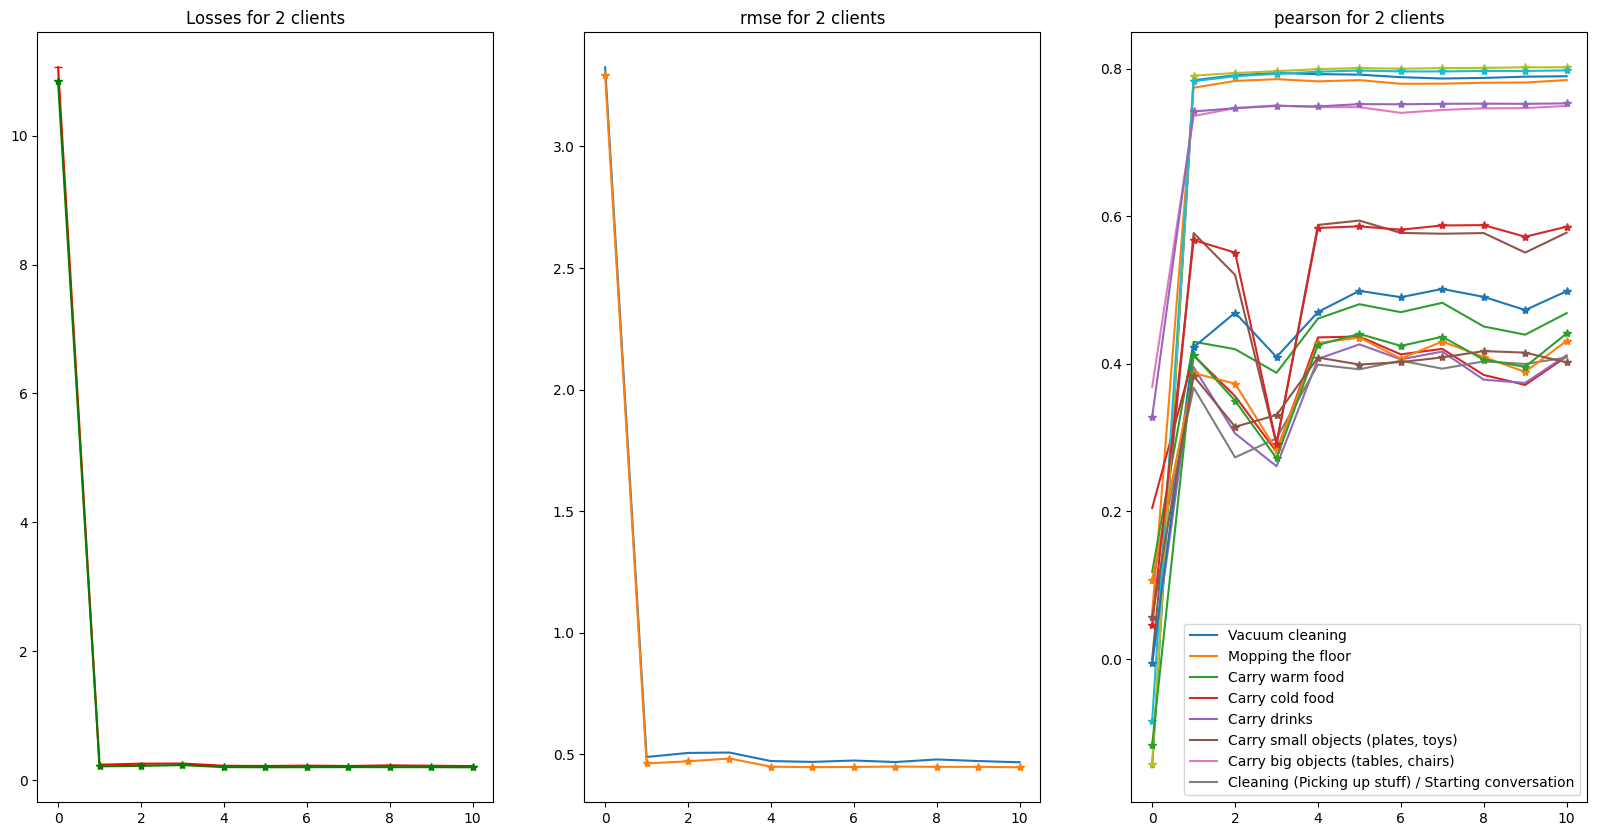

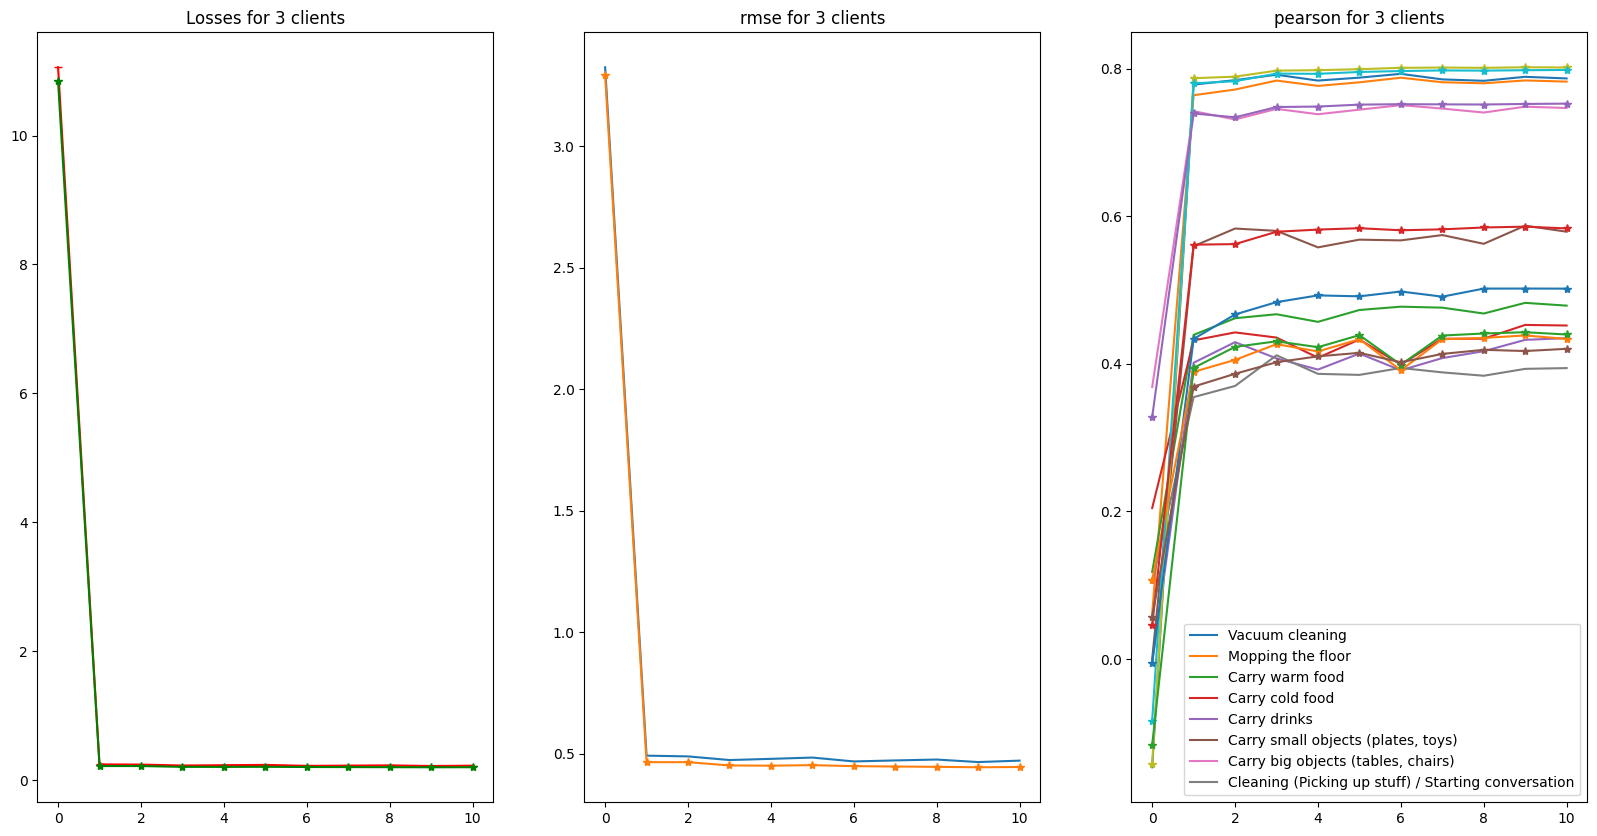

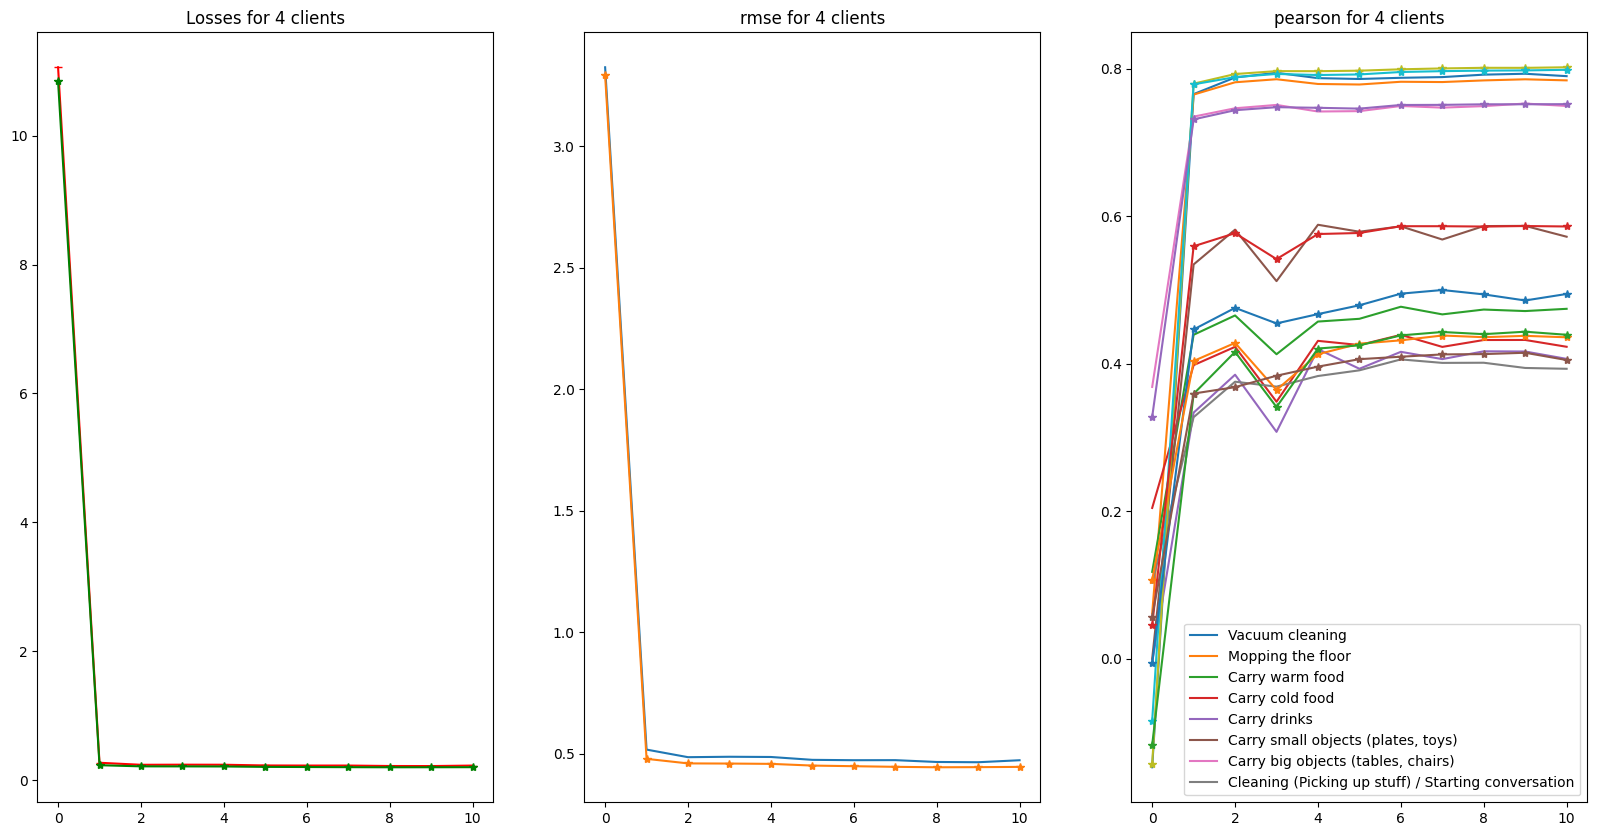

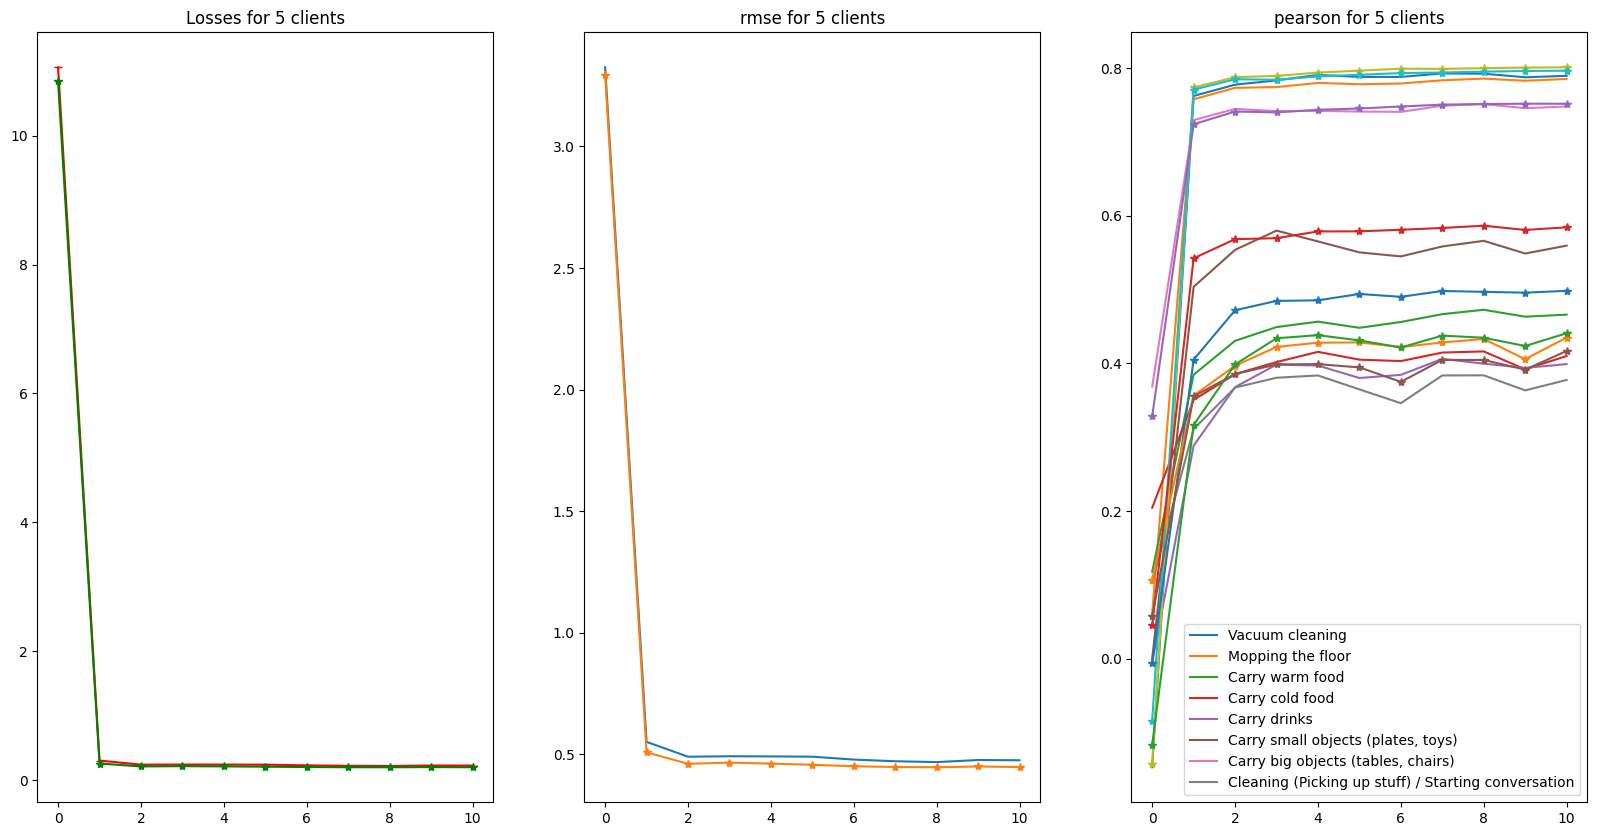

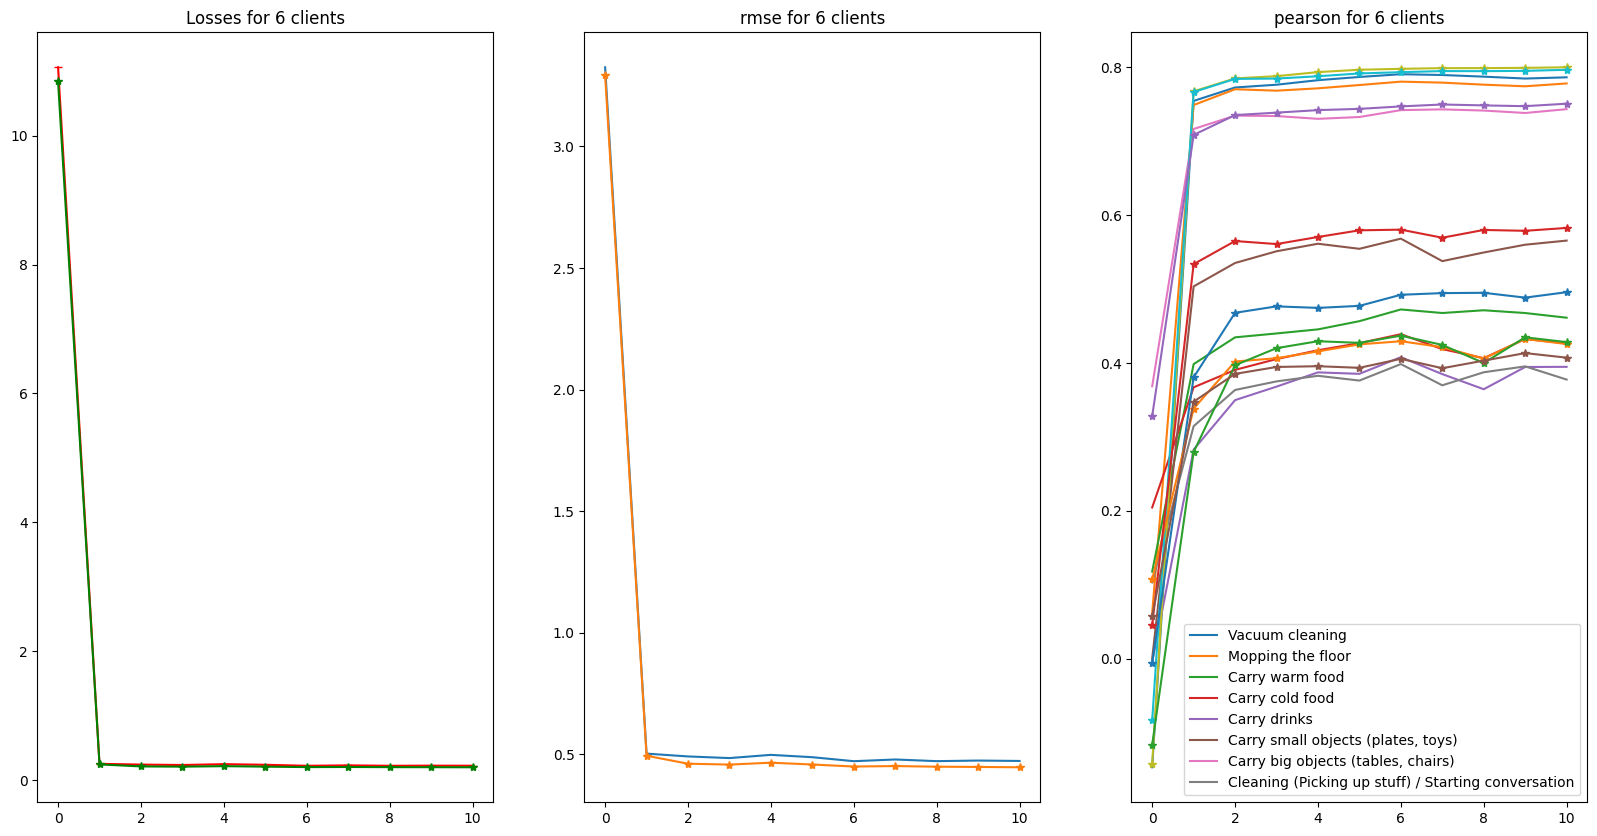

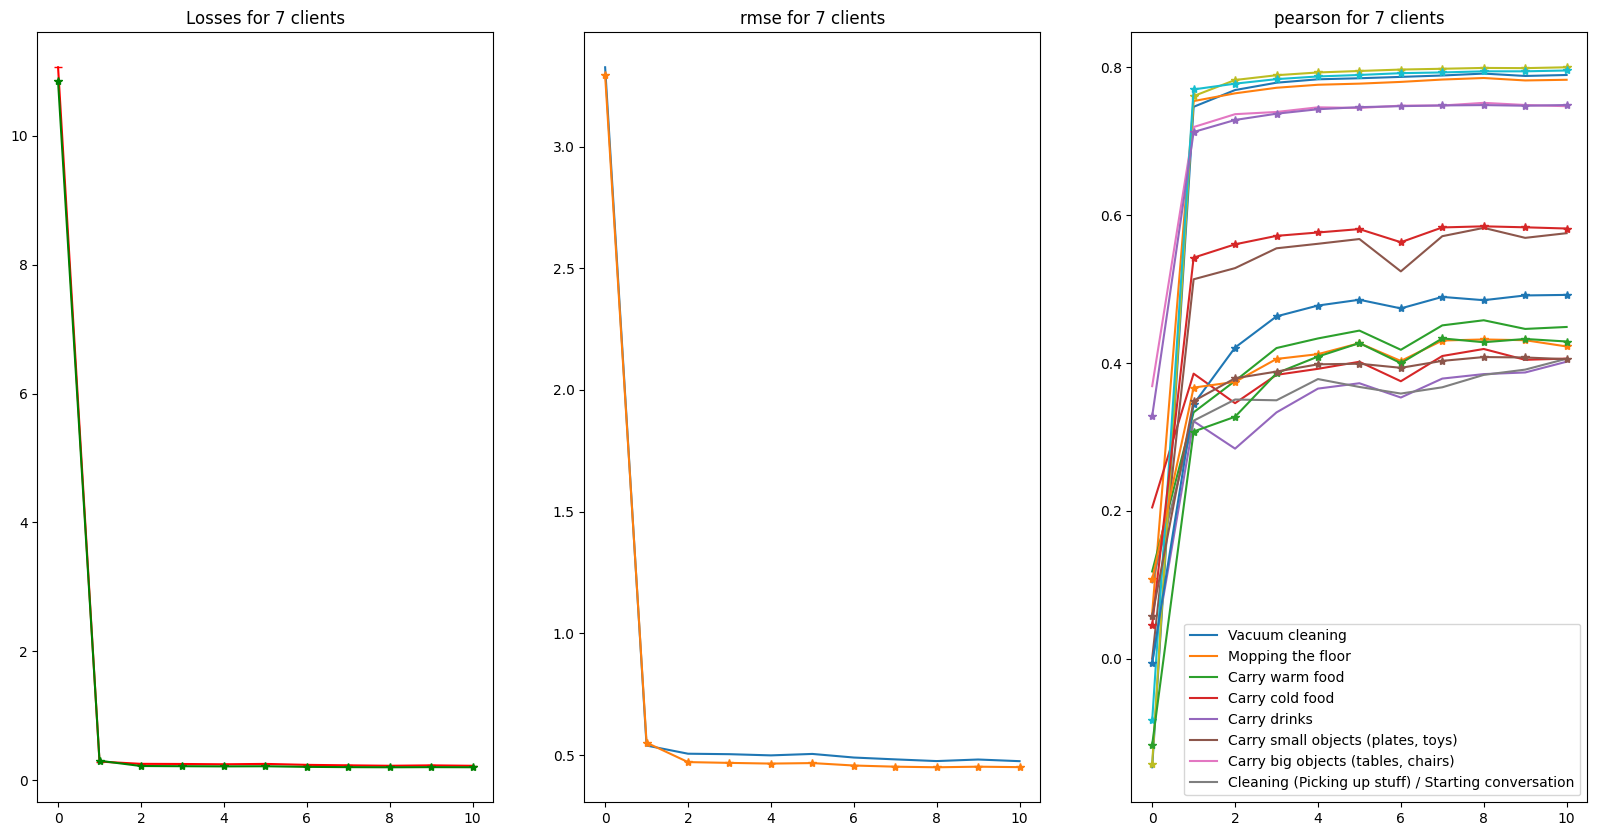

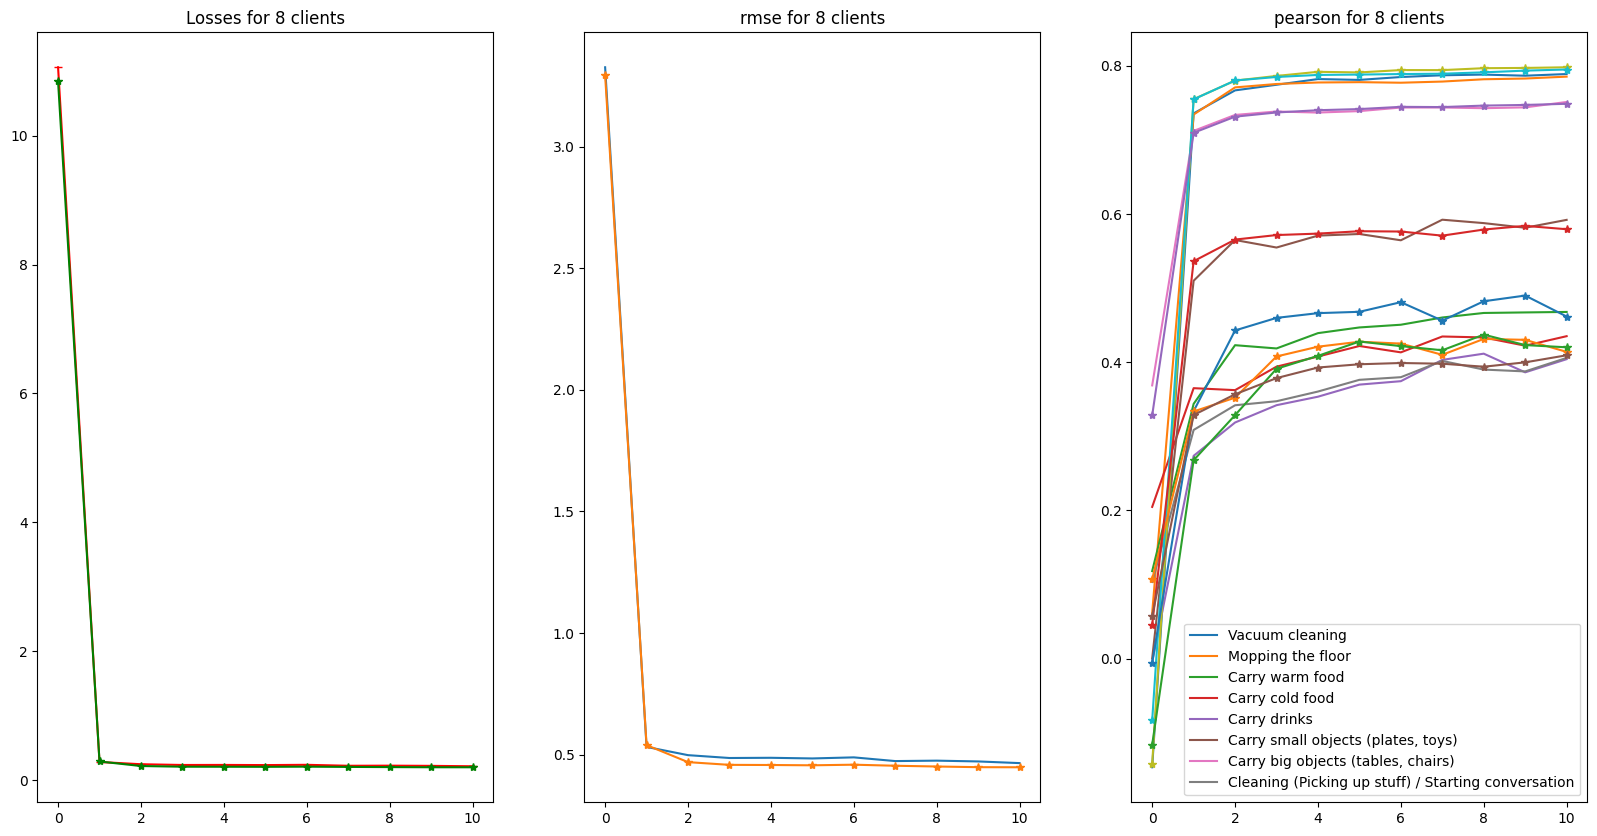

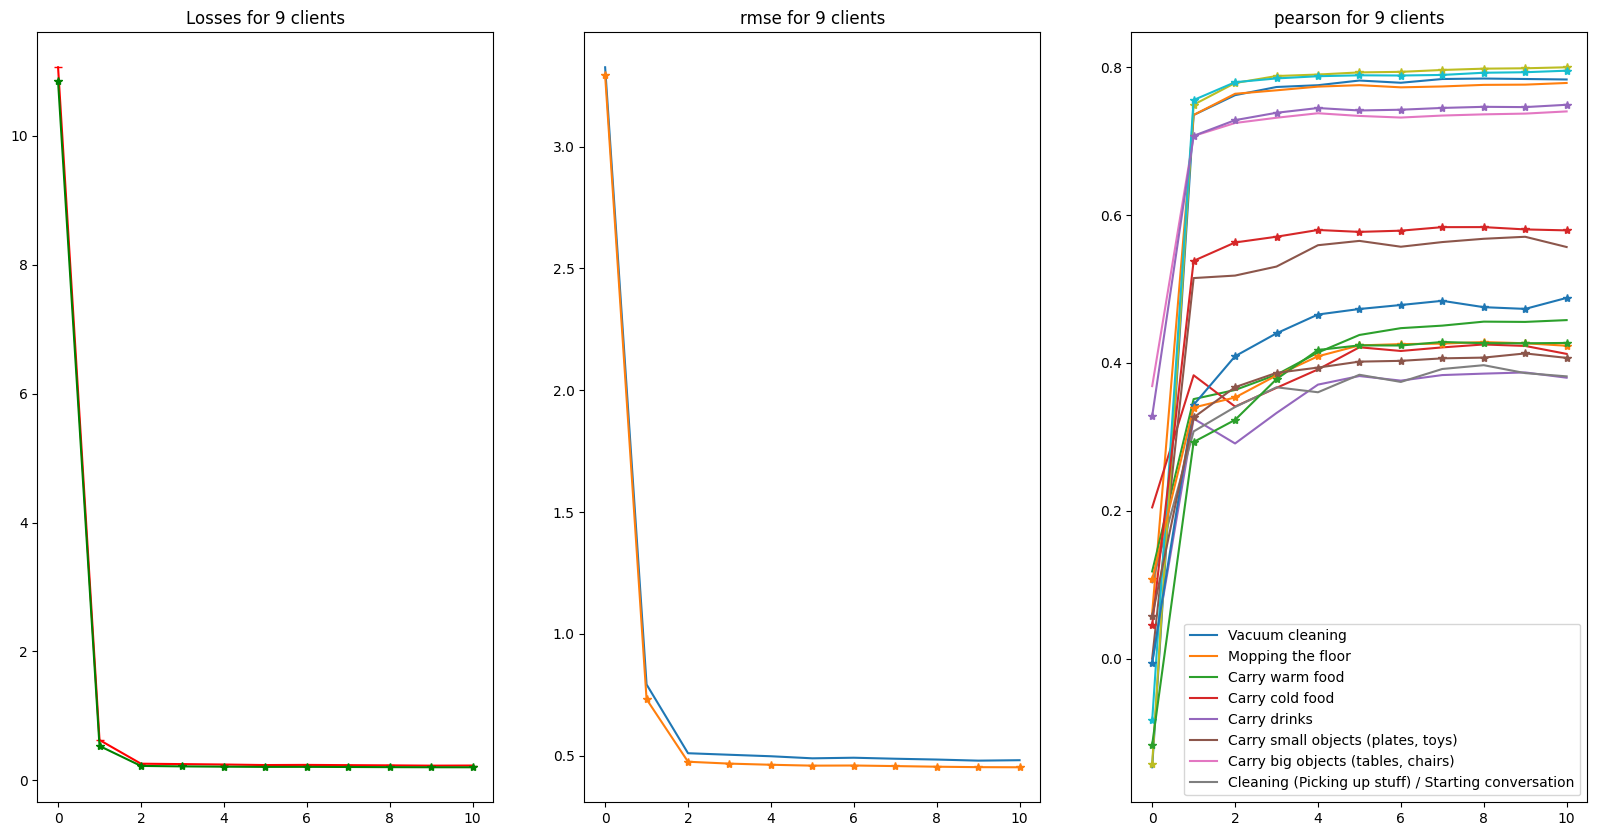

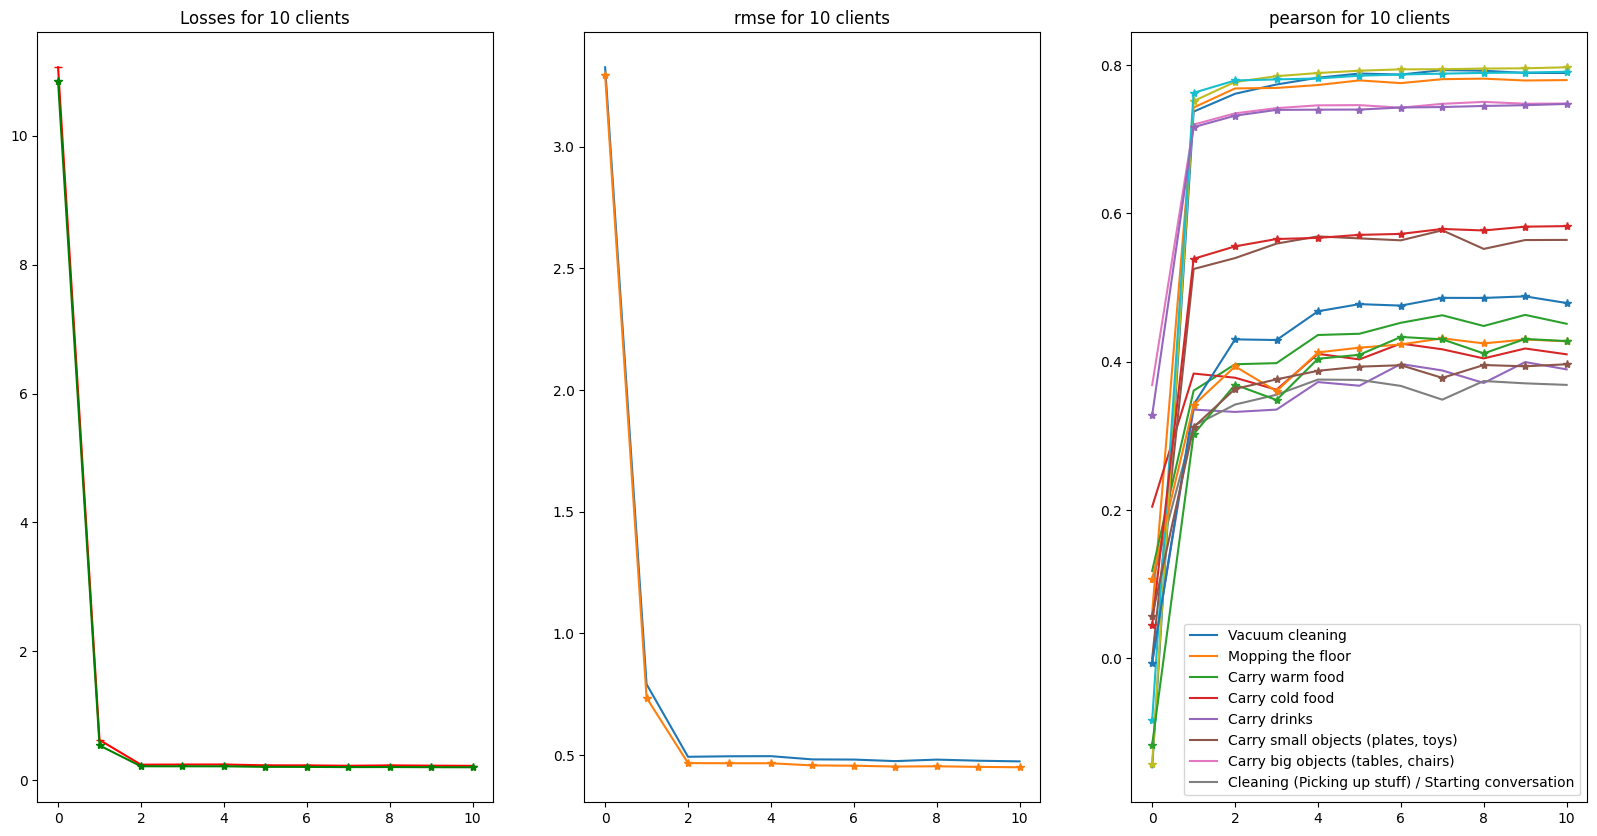

In [27]:
#for each client, plot losses, rmse in separate graphs and pearson of each label in a single graph with all labels marked in the legend
import matplotlib.pyplot as plt
for i in range(len(results)):
    plt.figure(figsize=(20,10))
    plt.subplot(1,3,1)
    plt.plot(results[i]['Losses'], marker='_', color='red')
    plt.title("Losses for "+str(results[i]['clients'])+" clients")
    # plt.figure(figsize=(10,5))
    plt.plot(results_train[i]['Losses'],marker='*', color='green')
    plt.subplot(1,3,2)
    plt.plot(results[i]['rmse'])
    plt.plot(results_train[i]['rmse'], marker='*')

    plt.title("rmse for "+str(results[i]['clients'])+" clients")
    plt.subplot(1,3,3)
    for j in range(len(y_labels)):
        plt.plot(results[i]['pearson'][y_labels[j]])
    for j in range(len(y_labels)):
        plt.plot(results_train[i]['pearson'][y_labels[j]],marker='*')
    plt.title("pearson for "+str(results[i]['clients'])+" clients")
    plt.legend(y_labels)
    plt.savefig(f"{path}/{i+2}/{strat}.png")


In [28]:
import json
for i in range(len(results)):
    with open(f"{path}/{i+2}/{strat}/"+str(results[i]['clients'])+"clients.json", "w") as outfile:
        json.dump(results[i], outfile)


In [29]:
#load the results from the path "/results/fedAvgN" and create a dataframe with losses, rmse and average pearson of every label for each client
import json
import os
results=[]
for i in range(2,11):
    with open(f"{path}/{i}/{strat}/"+str(i)+"clients.json") as json_file:
        results.append(json.load(json_file))
import pandas as pd
df=pd.DataFrame(results)
df.head()

,clients,Losses,rmse,pearson
0,2,"[11.060606956481934, 0.2396831065416336, 0.256...","[3.325749158859253, 0.4895744025707245, 0.5062...","{'Vacuum cleaning': [-0.1468226751843182, 0.78..."
1,3,"[11.060606956481934, 0.24225178360939026, 0.23...","[3.325749158859253, 0.49219080805778503, 0.489...","{'Vacuum cleaning': [-0.1468226751843182, 0.77..."
2,4,"[11.060606956481934, 0.26803067326545715, 0.23...","[3.325749158859253, 0.5177168250083923, 0.4864...","{'Vacuum cleaning': [-0.1468226751843182, 0.76..."
3,5,"[11.060606956481934, 0.30356696248054504, 0.24...","[3.325749158859253, 0.550969123840332, 0.49000...","{'Vacuum cleaning': [-0.1468226751843182, 0.76..."
4,6,"[11.060606956481934, 0.2528819739818573, 0.241...","[3.325749158859253, 0.5028737187385559, 0.4913...","{'Vacuum cleaning': [-0.1468226751843182, 0.75..."


In [30]:
df=pd.DataFrame(results)


In [31]:
#add a new column named pearson_avg
df['pearson_avg']=[[] for i in range(len(df))]


In [32]:
df.head()

,clients,Losses,rmse,pearson,pearson_avg
0,2,"[11.060606956481934, 0.2396831065416336, 0.256...","[3.325749158859253, 0.4895744025707245, 0.5062...","{'Vacuum cleaning': [-0.1468226751843182, 0.78...",[]
1,3,"[11.060606956481934, 0.24225178360939026, 0.23...","[3.325749158859253, 0.49219080805778503, 0.489...","{'Vacuum cleaning': [-0.1468226751843182, 0.77...",[]
2,4,"[11.060606956481934, 0.26803067326545715, 0.23...","[3.325749158859253, 0.5177168250083923, 0.4864...","{'Vacuum cleaning': [-0.1468226751843182, 0.76...",[]
3,5,"[11.060606956481934, 0.30356696248054504, 0.24...","[3.325749158859253, 0.550969123840332, 0.49000...","{'Vacuum cleaning': [-0.1468226751843182, 0.76...",[]
4,6,"[11.060606956481934, 0.2528819739818573, 0.241...","[3.325749158859253, 0.5028737187385559, 0.4913...","{'Vacuum cleaning': [-0.1468226751843182, 0.75...",[]


In [33]:
y_labels=list(df['pearson'][0].keys())

for i in range(df.shape[0]):
    li=[]
    for k in range(10):
        sum=0
        for j in range(len(y_labels)):
            sum=sum+df['pearson'][i][y_labels[j]][k]
        sum=sum/10
        li.append(sum)
    df['pearson_avg'][i]=li



/tmp/ipykernel_183852/1854403552.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pearson_avg'][i]=li
/tmp/ipykernel_183852/1854403552.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pearson_avg'][i]=li
/tmp/ipykernel_183852/1854403552.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pearson_avg'][i]=li
/tmp/ipykernel_183852/1854403552.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

In [34]:
for i in range(df.shape[0]):
  # mini=min(df['Losses'][i])
  # idx=df['Losses'][i].index(mini)
  # print(idx)
  idx=-1
  df['Losses'][i]=df['Losses'][i][idx]
  df['rmse'][i]=df['rmse'][i][idx]
  df['pearson_avg'][i]=df['pearson_avg'][i][idx]


/tmp/ipykernel_183852/3851578825.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Losses'][i]=df['Losses'][i][idx]
/tmp/ipykernel_183852/3851578825.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rmse'][i]=df['rmse'][i][idx]
/tmp/ipykernel_183852/3851578825.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pearson_avg'][i]=df['pearson_avg'][i][idx]
/tmp/ipykernel_183852/3851578825.py:6: SettingWithCopyWarning: 
A v

In [35]:
df

,clients,Losses,rmse,pearson,pearson_avg
0,2,0.218813,0.467774,"{'Vacuum cleaning': [-0.1468226751843182, 0.78...",0.445277
1,3,0.222463,0.47166,"{'Vacuum cleaning': [-0.1468226751843182, 0.77...",0.467144
2,4,0.224575,0.473893,"{'Vacuum cleaning': [-0.1468226751843182, 0.76...",0.463314
3,5,0.225943,0.475335,"{'Vacuum cleaning': [-0.1468226751843182, 0.76...",0.447755
4,6,0.223517,0.472776,"{'Vacuum cleaning': [-0.1468226751843182, 0.75...",0.454864
5,7,0.225112,0.474459,"{'Vacuum cleaning': [-0.1468226751843182, 0.74...",0.451692
6,8,0.217067,0.465904,"{'Vacuum cleaning': [-0.1468226751843182, 0.73...",0.455815
7,9,0.23114,0.48077,"{'Vacuum cleaning': [-0.1468226751843182, 0.73...",0.451987
8,10,0.225198,0.47455,"{'Vacuum cleaning': [-0.1468226751843182, 0.73...",0.45328


In [36]:
df.drop(['pearson'], axis=1, inplace=True)

In [37]:
for i in range(df.shape[0]):
  try:
    data=pd.read_csv(f"{path}/clients{i+2}.csv")
    data.drop(["Unnamed: 0"], axis=1, inplace=True)
  except:
    data=pd.DataFrame(columns=["methods", "Loss", "RMSE", "PCC"])
  # data=data.append(pd.Series(["FedAvg_NoAug",df['Losses'][i],df['rmse'][i],df['pearson_avg'][i]]), ignore_index=True)
  data=pd.concat([data,pd.Series([f"{strat}",df['Losses'][i],df['rmse'][i],df['pearson_avg'][i]] , index=data.columns ).to_frame().T])
  data.to_csv(f"{path}/clients{i+2}.csv")

